In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering
import plotly
plotly.offline.init_notebook_mode(connected=True)
plt.style.use('ggplot')
%matplotlib inline
from tqdm import tqdm
from geopy.geocoders import Nominatim
import seaborn as sns
pd.options.display.max_columns=100
pd.options.display.max_rows=100

In [3]:
data = pd.read_csv('Dyadic_COW_4.0.csv')
data = data.iloc[:,2:7]
data.head()

year                 importer1 importer2      flow1      flow2
0  1920  United States of America    Canada  611.85999  735.47998
1  1921  United States of America    Canada  335.44000  442.98999
2  1922  United States of America    Canada  364.01999  502.84000
3  1923  United States of America    Canada  416.00000  598.14001
4  1924  United States of America    Canada  399.14001  496.32001

Now, a first step is to reshape the data so that the flow2 column is below flow 1.

In [4]:
# Data flow1
data_flow_1 = data.loc[:, ['year', 'importer1', 'importer2', 'flow1']]
data_flow_2 = data.loc[:, ['year', 'importer1', 'importer2', 'flow2']]
data_flow_1.columns = ['year', 'Country_A', 'Country_B', 'flow']
data_flow_2.columns = ['year', 'Country_B', 'Country_A', 'flow']
# Dataset in good shape
df = pd.concat([data_flow_1, data_flow_2]).sort_index().reset_index(drop=True)
# Replace -9 by NaN
df = df.replace({'flow': {-9: np.nan}})
df.head()

Country_A                 Country_B       flow  year
0  United States of America                    Canada  611.85999  1920
1                    Canada  United States of America  735.47998  1920
2  United States of America                    Canada  335.44000  1921
3                    Canada  United States of America  442.98999  1921
4  United States of America                    Canada  364.01999  1922

The flow represents the imports of Country_A from Country_B, in US millions of current dollars.

### Descriptive statistics about the evolution of the network

In [5]:
n_nodes = []
n_edges = []
for i in range(1950,2015):
    data_more_1950 = df.loc[np.where(df.year==i)[0], :]
    n_nodes.append(data_more_1950['Country_A'].nunique())
    n_edges.append(len(data_more_1950))

In [6]:
df_resume = pd.DataFrame({'year':[i for i in range(1950,2015)], 'Nb_nodes': n_nodes, 'Nb_edges':n_edges})

Text(0,0.5,'Number of nodes')

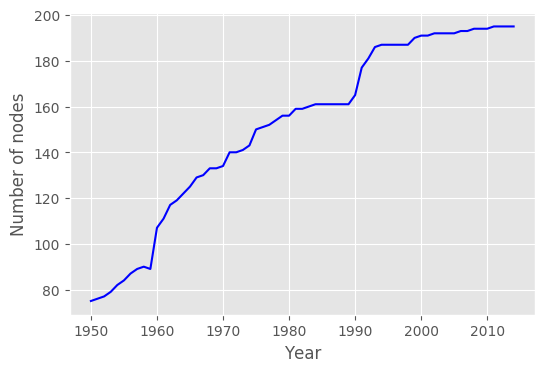

In [7]:
plt.plot(df_resume.year, df_resume.Nb_nodes, c = 'blue')
plt.xlabel('Year')
plt.ylabel('Number of nodes')

The number of country in the network increases.

Text(0,0.5,'Number of edges')

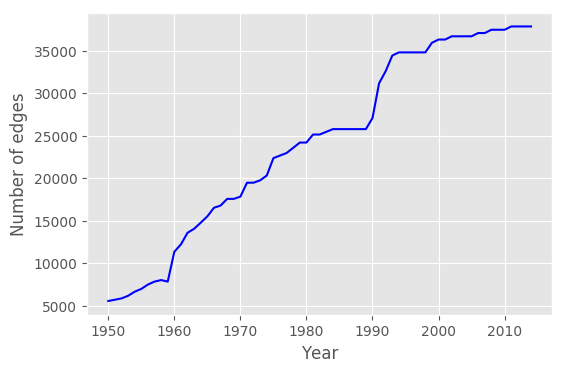

In [8]:
plt.plot(df_resume.year, df_resume.Nb_edges, c = 'blue')
plt.xlabel('Year')
plt.ylabel('Number of edges')

The number of exchanges increases.

Text(0,0.5,'Number of exchanges per country')

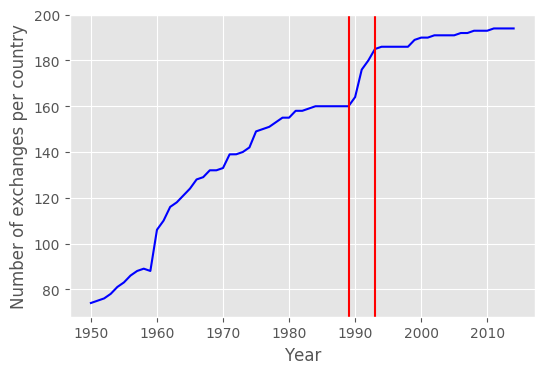

In [9]:
plt.plot(df_resume.year, df_resume.Nb_edges / df_resume.Nb_nodes, c = 'blue')
plt.axvline(x=1989, c = 'red')
plt.axvline(x=1993, c = 'red')
plt.xlabel('Year')
plt.ylabel('Number of exchanges per country')

The number of relation per country increases.

We can notice a drop in the years 1991-1993. It can come from the explosion of URSS. I will verify it.

In [10]:
lost_countries = list(set(df.loc[np.where(df.year==1989)[0],:].Country_A) - 
                      set(df.loc[np.where(df.year==1993)[0],:].Country_A))
new_countries = list(set(df.loc[np.where(df.year==1993)[0],:].Country_A) - 
                      set(df.loc[np.where(df.year==1989)[0],:].Country_A))

In [11]:
geolocator = Nominatim()
# Get coordinated of new countries
coordinates_new_countries = []
for i in new_countries:
    try:
        location = geolocator.geocode(i)
        coordinates_new_countries.append((location.latitude, location.longitude))
    except:
        coordinates_new_countries.append(('lat not found', 'lon not found'))
# Get coordinated of lost countries
coordinates_lost_countries = []
for i in lost_countries:
    try:
        location = geolocator.geocode(i)
        coordinates_lost_countries.append((location.latitude, location.longitude))
    except:
        coordinates_lost_countries.append(('lat not found', 'lon not found'))

In [12]:
df = pd.DataFrame({'Name': new_countries, 'lat': [i[0] for i in coordinates_new_countries], 'long': [i[1] for i in coordinates_new_countries]})

In [13]:
data = [ dict(
        type = 'scattergeo',
        lon = df['long'],
        lat = df['lat'],
        text = df['Name'],
        mode = 'markers',
        marker = dict(
            size = 3,
            opacity = 1,
            reversescale = True,
            autocolorscale = False,
            symbol = 'square',
            color='red'
        ))]

layout = dict(
        title = 'New countries between 1989 and 1993',
        colorbar = True,
        geo = dict(
            scope = 'europe',
            projection=dict( type='mollweide' ),
            showland = True,
            landcolor = "rgb(250, 250, 250)",
            subunitcolor = "rgb(217, 217, 217)",
            countrycolor = "rgb(217, 217, 217)",
            countrywidth = 0.5,
            subunitwidth = 0.5
        ),
    )

fig = dict( data=data, layout=layout )
py.iplot( fig, validate=False)

### Compute the evolution of the similarity between similarity matrices over time

In [3]:
data = pd.read_csv('Dyadic_COW_4.0.csv')
data = data.iloc[:,2:7]
data.head()

year                 importer1 importer2      flow1      flow2
0  1920  United States of America    Canada  611.85999  735.47998
1  1921  United States of America    Canada  335.44000  442.98999
2  1922  United States of America    Canada  364.01999  502.84000
3  1923  United States of America    Canada  416.00000  598.14001
4  1924  United States of America    Canada  399.14001  496.32001

In [4]:
# Data flow1
data_flow_1 = data.loc[:, ['year', 'importer1', 'importer2', 'flow1']]
data_flow_2 = data.loc[:, ['year', 'importer1', 'importer2', 'flow2']]
data_flow_1.columns = ['year', 'Country_A', 'Country_B', 'flow']
data_flow_1['key'] = data_flow_1['Country_A'] + '-' + data_flow_1['Country_B']
data_flow_2.columns = ['year', 'Country_B', 'Country_A', 'flow']
data_flow_2['key'] = data_flow_2['Country_B'] + '-' + data_flow_2['Country_A']
# Dataset in good shape
df = pd.concat([data_flow_1, data_flow_2]).sort_index().reset_index(drop=True)
# Replace -9 by NaN
df = df.replace({'flow': {-9: np.nan}})
# drop nan
df = df.dropna()
# We keep years from 1950
df = df[df.year>=1950].reset_index(drop=True)

In [5]:
# This gives us the proportion of importation of Country_A from Country_B at for each yer
df['flow'] = df['flow'] / df.groupby(['year', 'Country_A'])['flow'].transform(sum) * 100
# drop nan
df = df.dropna().reset_index(drop=True)

Here, we delete countries for which we do not know the value of their import.

For each year, we compute squared symmetric average exchanges' intensity matrix.

In [6]:
list_intensity_matrix = []
list_intensity_matrix_col = []
list_intensity_matrix_index = []
for i in list(df.year.unique()):
    inter_df = df[df.year==i]
    # Get squared similarity matrix
    data = pd.pivot_table(inter_df, values='flow', index=['Country_A'], columns=['Country_B'], fill_value=0)
    list_intensity_matrix.append(data)
    list_intensity_matrix_col.append(list(data.columns))
    list_intensity_matrix_index.append(list(data.index))

In [7]:
diff_frobenius_norm = []
for i in range(len(list_intensity_matrix)-1):
    aligned_mat_left = list_intensity_matrix[i].align(list_intensity_matrix[i+1], join='inner')[0].as_matrix()
    aligned_mat_right = list_intensity_matrix[i].align(list_intensity_matrix[i+1], join='inner')[1].as_matrix()
    diff_frobenius_norm.append(np.linalg.norm(aligned_mat_left-aligned_mat_right, 'fro'))

__Bollinger bands method__

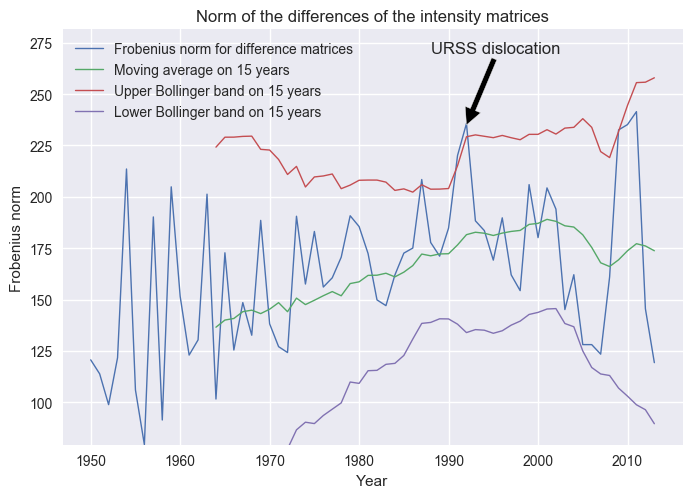

In [8]:
window_size = 15

ma_y = pd.Series(diff_frobenius_norm).rolling(window=window_size).mean()
std_y = pd.Series(diff_frobenius_norm).rolling(window=window_size).std()
Bollinger_dict = {'MA_y': ma_y, 'UB_y': ma_y+1.96*std_y, 'LB_y': ma_y-1.96*std_y}

fig = plt.figure()
ax = fig.add_subplot(111)

line, = ax.plot(list(df.year.unique())[:-1], diff_frobenius_norm, lw=1)
line, = ax.plot(list(df.year.unique())[:-1], Bollinger_dict['MA_y'], lw=1)
line, = ax.plot(list(df.year.unique())[:-1], Bollinger_dict['UB_y'], lw=1)
line, = ax.plot(list(df.year.unique())[:-1], Bollinger_dict['LB_y'], lw=1)

ax.annotate('URSS dislocation', xy=(1992, 235), xytext=(1988, 270),
            arrowprops=dict(facecolor='black'),)
ax.set_ylim(min(diff_frobenius_norm),max(diff_frobenius_norm)+40)
plt.title('Norm of the differences of the intensity matrices')
plt.xlabel('Year')
plt.ylabel('Frobenius norm')
plt.legend(loc = 'upper left', labels = ['Frobenius norm for difference matrices',
                                         'Moving average on {} years'.format(window_size),
                                         'Upper Bollinger band on {} years'.format(window_size),
                                         'Lower Bollinger band on {} years'.format(window_size)])

In [9]:
from itertools import compress
'The years where values of the norm are greater than the upper Bollinger band are {}'.format(
    list(compress(list(df.year.unique())[:-1], list(diff_frobenius_norm > Bollinger_dict['UB_y']))))

'The years where values of the norm are greater than the upper Bollinger band are [1987, 1991, 1992, 2009]'

We know from the previous analysis that the anomaly detected in 1991 and 1992 come from the URSS dislication. Now, we try to understand what happened in 2009.

In [10]:
loc_2009 = np.where(df.year.unique()==2009)[0][0]
mat_2009 = list_intensity_matrix[loc_2009]
mat_2010 = list_intensity_matrix[loc_2009+1]
aligned_mat_2009 = mat_2009.align(mat_2010, join='inner')[0].as_matrix()
aligned_mat_2010 = mat_2009.align(mat_2010, join='inner')[1].as_matrix()

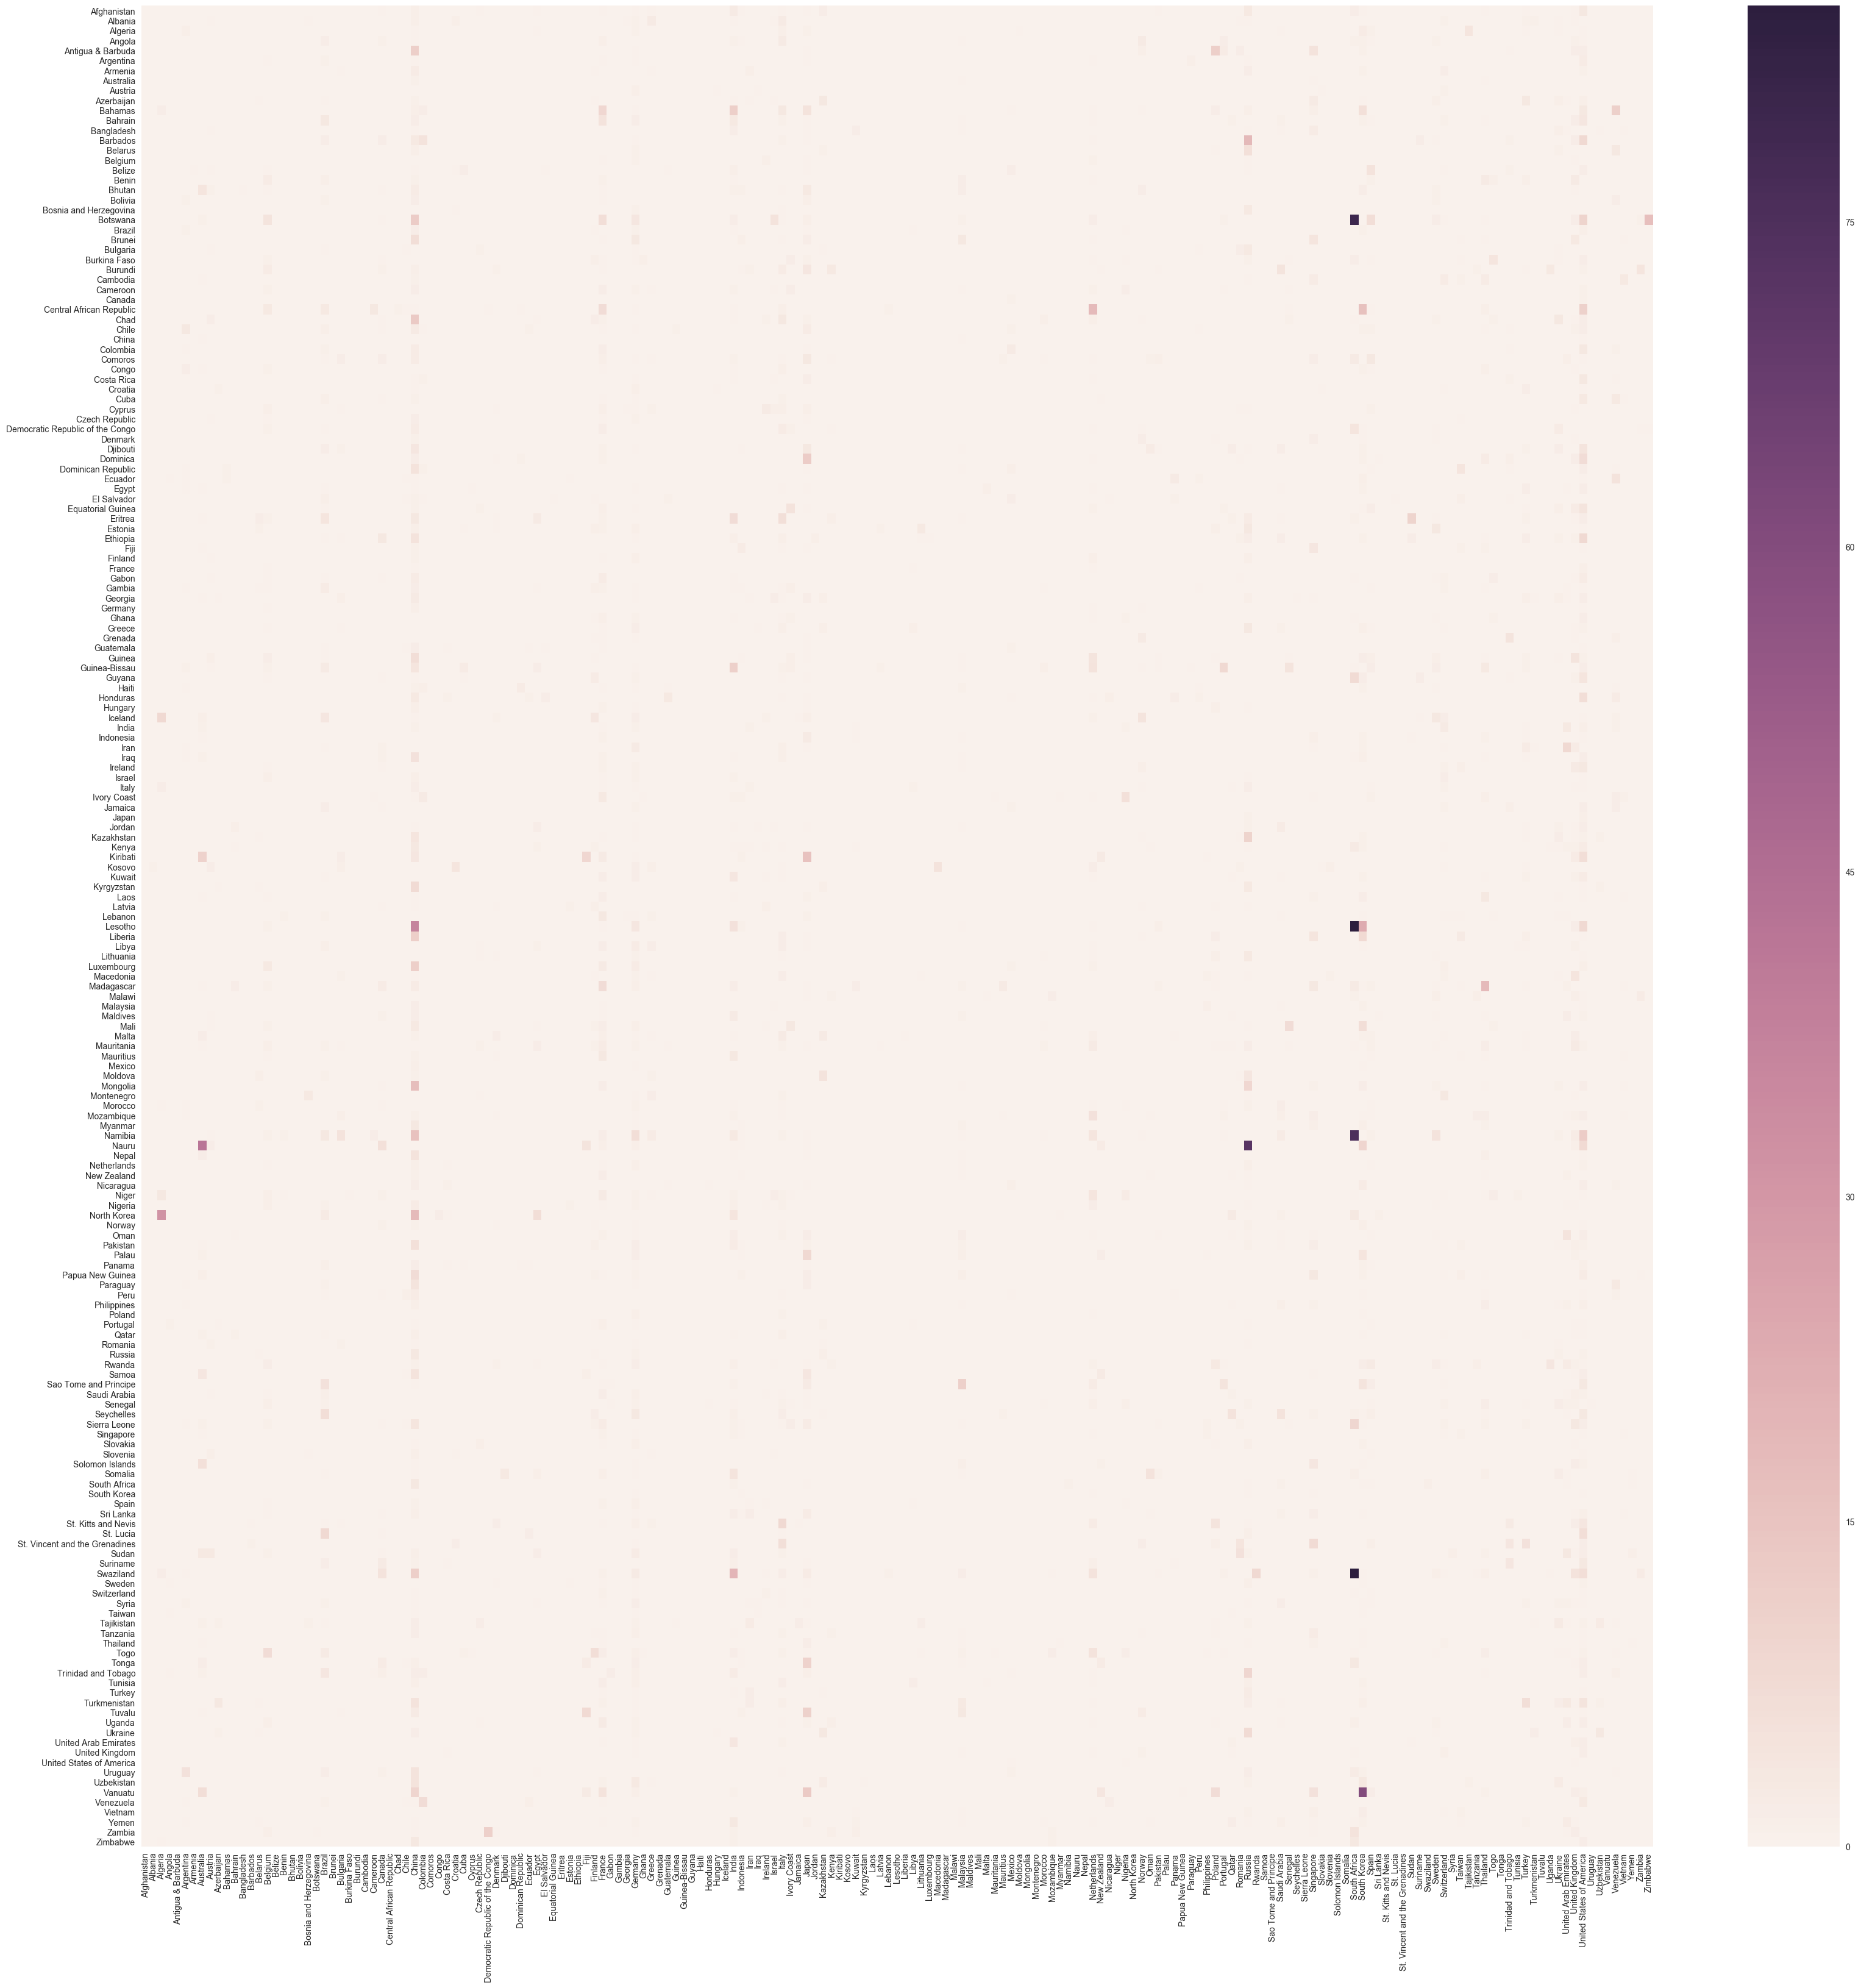

In [11]:
fig, ax = plt.subplots(figsize=(40,40)) 
sns.heatmap(abs(aligned_mat_2010-aligned_mat_2009), xticklabels = list_intensity_matrix_col[loc_2009],
           yticklabels = list_intensity_matrix_index[loc_2009])

From this heatmap, it is hard to say which country contributes the most to the increase of the Frobenius norm. Theredore, we are going to look at the evolution of the Frobenius norm inside each continent.

__Twitter detection anomalie method__ <-- NOT WORKING FOR OUR PROBLEM

In [389]:
from pyculiarity import detect_ts
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
matplotlib.style.use('ggplot')

In [475]:
twitter_example_data = pd.read_csv('raw_data.csv', usecols=['timestamp', 'count'])
twitter_example_data.timestamp = twitter_example_data.timestamp.apply(lambda x: time.mktime(datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S").timetuple()))

/Users/Linger/anaconda/lib/python3.5/site-packages/pyculiarity/detect_anoms.py:81: FutureWarning:

convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.



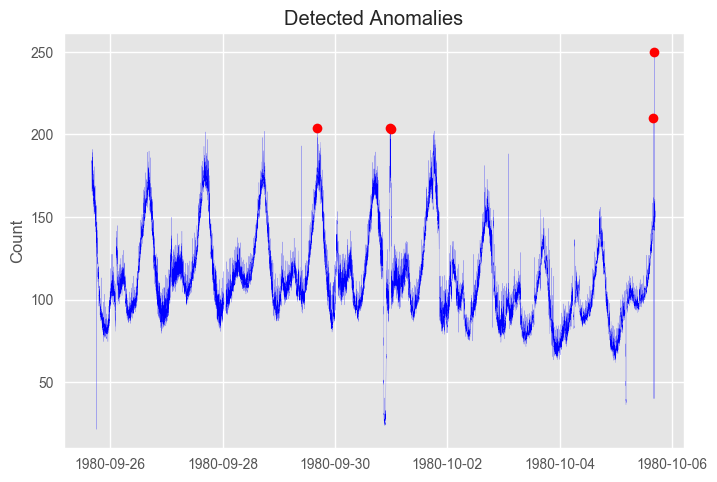

In [476]:
# first run the models
results = detect_ts(twitter_example_data, max_anoms=0.1, alpha=0.1, direction='both')

# format the twitter data nicely
twitter_example_data['timestamp'] = pd.to_datetime(twitter_example_data['timestamp'])
twitter_example_data.set_index('timestamp', drop=True)

# make a nice plot
f, ax = plt.subplots(1, 1, sharex=True)
ax.plot(twitter_example_data['timestamp'], twitter_example_data['count'], 'b', lw=0.1)
ax.plot(results['anoms'].index, results['anoms']['anoms'], 'ro')
ax.set_title('Detected Anomalies')
ax.set_ylabel('Count')
plt.show()

__Other method here__

In [477]:
import pickdetect

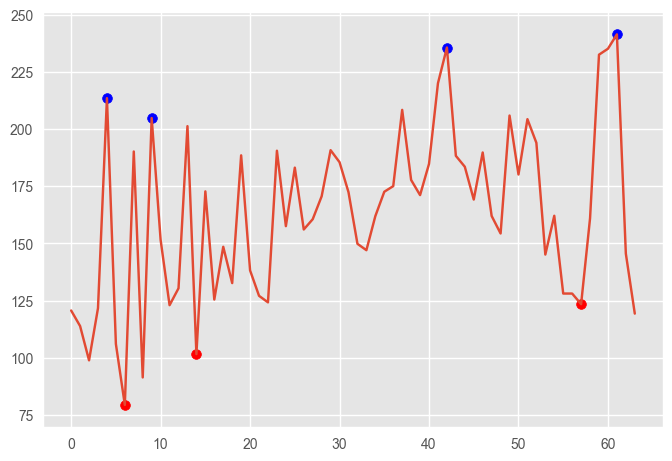

In [488]:
from matplotlib.pyplot import plot, scatter, show
series = diff_frobenius_norm
maxtab, mintab = pickdetect.peakdet(series,100)
plot(series)
scatter(np.array(maxtab)[:,0], np.array(maxtab)[:,1], color='blue')
scatter(np.array(mintab)[:,0], np.array(mintab)[:,1], color='red')
show()

This method is too naive so we would make use of the Bollinger bands.

### We look at continents subgraphs

In [12]:
continent = eval(open("continent.py").read())

In [13]:
continent_dict = {}
for i, j in enumerate(continent):
    continent_dict.update({continent[i]['name']: continent[i]['continent']})

In [14]:
countries = list(df.Country_A.unique())

In [15]:
len([i for i in list(map(continent_dict.get, countries)) if i != None])/len(list(map(continent_dict.get, countries)))

0.8814432989690721

On a 88% des pays attachés à un continent en utilisant la méthode du dict. Je vais rajouter les autres à la main...

In [16]:
continent_dict.update({'United States of America': 'North America', 'St. Lucia':'North America','St. Vincent and the Grenadines':'North America',
 'Antigua & Barbuda':'North America', 'St. Kitts and Nevis':'North America', 'Ireland':'Europe', 'Netherlands':'Europe',
 'German Federal Republic':'Europe', 'German Democratic Republic':'Europe', 'Czechoslovakia':'Europe',
 'Yugoslavia':'Europe', 'Kosovo':'Europe', 'Sao Tome and Principe':'Africa','Gambia':'Africa', 'Ivory Coast':'Africa',
 'Congo':'Africa','Zanzibar':'Africa','South Sudan':'Africa', 'Yemen Arab Republic':'Asia',
 'Yemen People\'s Republic':'Asia', 'China':'Asia', 'Taiwan':'Asia', 'Republic of Vietnam':'Asia', 'Brunei':'Asia'})

In [17]:
len([i for i in list(map(continent_dict.get, countries)) if i != None])/len(list(map(continent_dict.get, countries)))

1.0

Maintenant on a un mapping parfait

In [18]:
df['continent'] = list(map(continent_dict.get, df.Country_A))
df['continent_B'] = list(map(continent_dict.get, df.Country_B))

On coupe les liens entre des pays de continents différents de manière à travailler sur les sous-graphes.

In [19]:
df_sub_cont = df.iloc[np.where(df.continent == df.continent_B)[0], :]
df_sub_cont = df_sub_cont.drop(['continent_B'], axis=1)

L'analyse par continent peut maintenant commencer

In [20]:
df_sub_cont = [df_sub_cont[df_sub_cont.continent==i] for i in list(df_sub_cont.continent.unique())]

In [21]:
[i.continent.unique() for i in df_sub_cont]

[array(['North America'], dtype=object),
 array(['South America'], dtype=object),
 array(['Europe'], dtype=object),
 array(['Asia'], dtype=object),
 array(['Africa'], dtype=object),
 array(['Oceania'], dtype=object)]

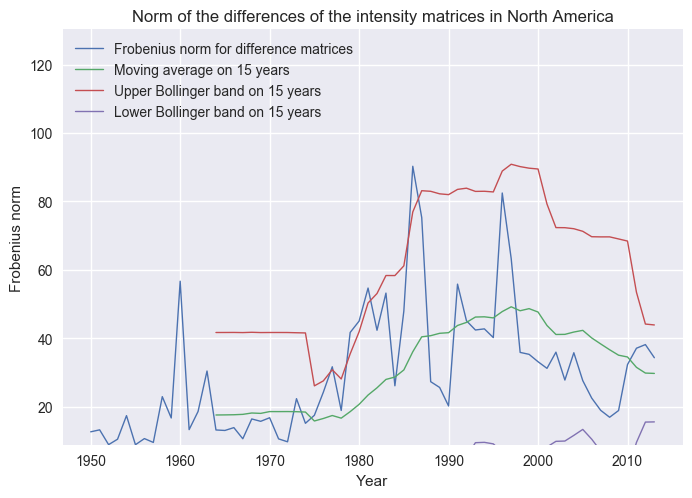

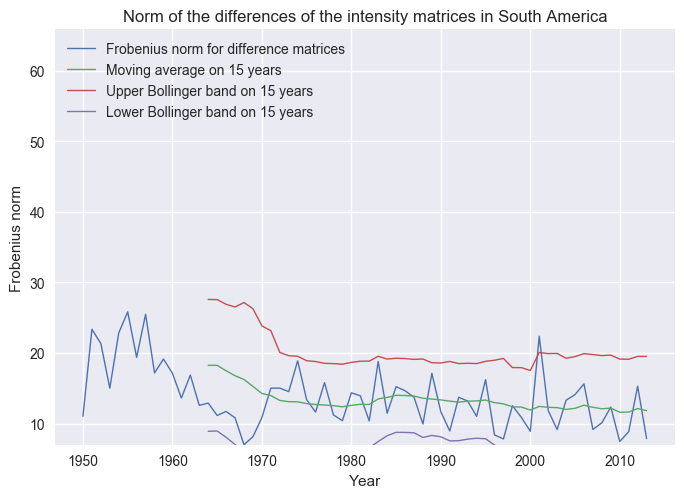

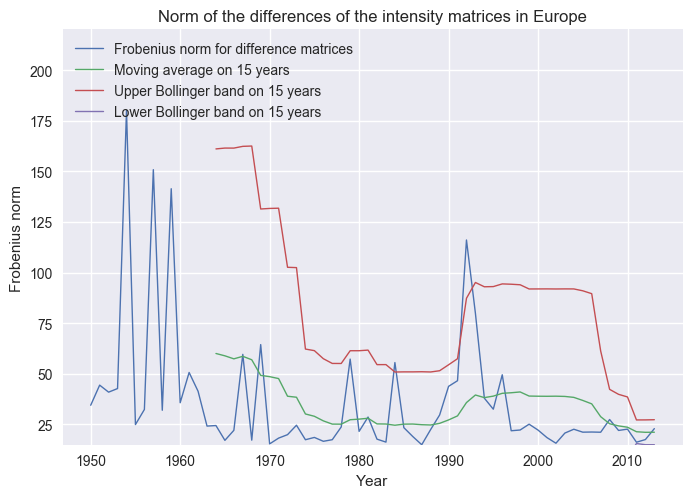

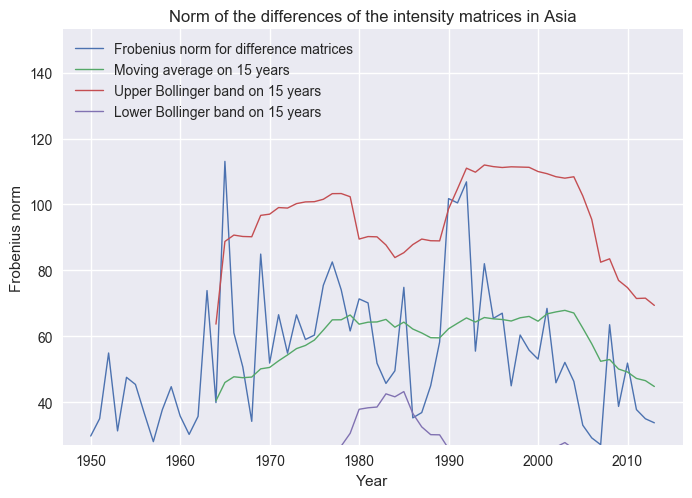

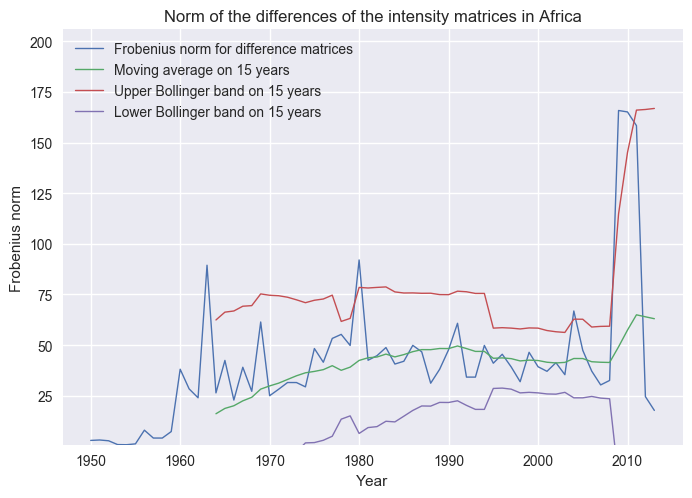

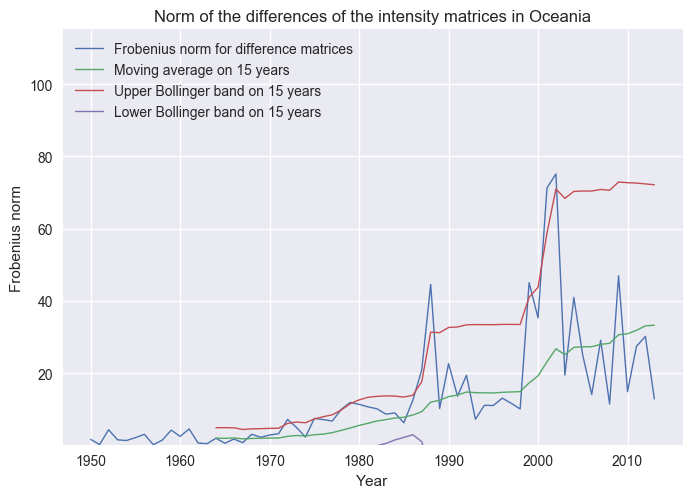

In [22]:
window_size = 15

years = list(df_sub_cont[0].year.unique())
pics = {'North America': [], 'South America': [], 'Europe': [], 'Asia': [], 'Africa': [], 'Oceania': []}
list_intensity_matrix = {'North America': [], 'South America': [], 'Europe': [], 'Asia': [], 'Africa': [], 'Oceania': []}
list_intensity_matrix_col = {'North America': [], 'South America': [], 'Europe': [], 'Asia': [], 'Africa': [], 'Oceania': []}
list_intensity_matrix_index = {'North America': [], 'South America': [], 'Europe': [], 'Asia': [], 'Africa': [], 'Oceania': []}
for z, data in enumerate(df_sub_cont):
    continent = data.continent.unique()[0]
    for j in years:
        inter_df = data[data.year==j]
        # Get squared similarity matrix
        inter_df = pd.pivot_table(inter_df, values='flow', index=['Country_A'], columns=['Country_B'], fill_value=0)
        list_intensity_matrix[continent].append(inter_df)
        list_intensity_matrix_col[continent].append(list(inter_df.columns))
        list_intensity_matrix_index[continent].append(list(inter_df.index))
    diff_frobenius_norm = []
    for i in range(len(list_intensity_matrix[continent])-1):
        aligned_mat_left = list_intensity_matrix[continent][i].align(list_intensity_matrix[continent][i+1], join='inner')[0].as_matrix()
        aligned_mat_right = list_intensity_matrix[continent][i].align(list_intensity_matrix[continent][i+1], join='inner')[1].as_matrix()
        diff_frobenius_norm.append(np.linalg.norm(aligned_mat_left-aligned_mat_right, 'fro'))
        
    ma_y = pd.Series(diff_frobenius_norm).rolling(window=window_size).mean()
    std_y = pd.Series(diff_frobenius_norm).rolling(window=window_size).std()
    Bollinger_dict = {'MA_y': ma_y, 'UB_y': ma_y+1.96*std_y, 'LB_y': ma_y-1.96*std_y}
    
    pics[data.continent.unique()[0]].append(list(compress(list(years)[:-1], list(diff_frobenius_norm > Bollinger_dict['UB_y']))))
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    line, = ax.plot(list(df.year.unique())[:-1], diff_frobenius_norm, lw=1)
    line, = ax.plot(list(df.year.unique())[:-1], Bollinger_dict['MA_y'], lw=1)
    line, = ax.plot(list(df.year.unique())[:-1], Bollinger_dict['UB_y'], lw=1)
    line, = ax.plot(list(df.year.unique())[:-1], Bollinger_dict['LB_y'], lw=1)
    
    ax.set_ylim(min(diff_frobenius_norm),max(diff_frobenius_norm)+40)
    plt.title('Norm of the differences of the intensity matrices in ' + list(df.continent.unique())[z])
    plt.xlabel('Year')
    plt.ylabel('Frobenius norm')
    plt.legend(loc = 'upper left', labels = ['Frobenius norm for difference matrices',
                                             'Moving average on {} years'.format(window_size),
                                             'Upper Bollinger band on {} years'.format(window_size),
                                             'Lower Bollinger band on {} years'.format(window_size)])
    plt.show()

Le contiennt le plus calme semble être l'Amérique du sud dans le mesure où il ne recense qu'un pic significatif.

In [23]:
[i for i in list_intensity_matrix]

['South America', 'Europe', 'Oceania', 'Africa', 'Asia', 'North America']

Pour ces années, nous allons plotter les heatmaps par continent de manière à voir quels pays sont impliqués dans le changement de la structure des échanges.

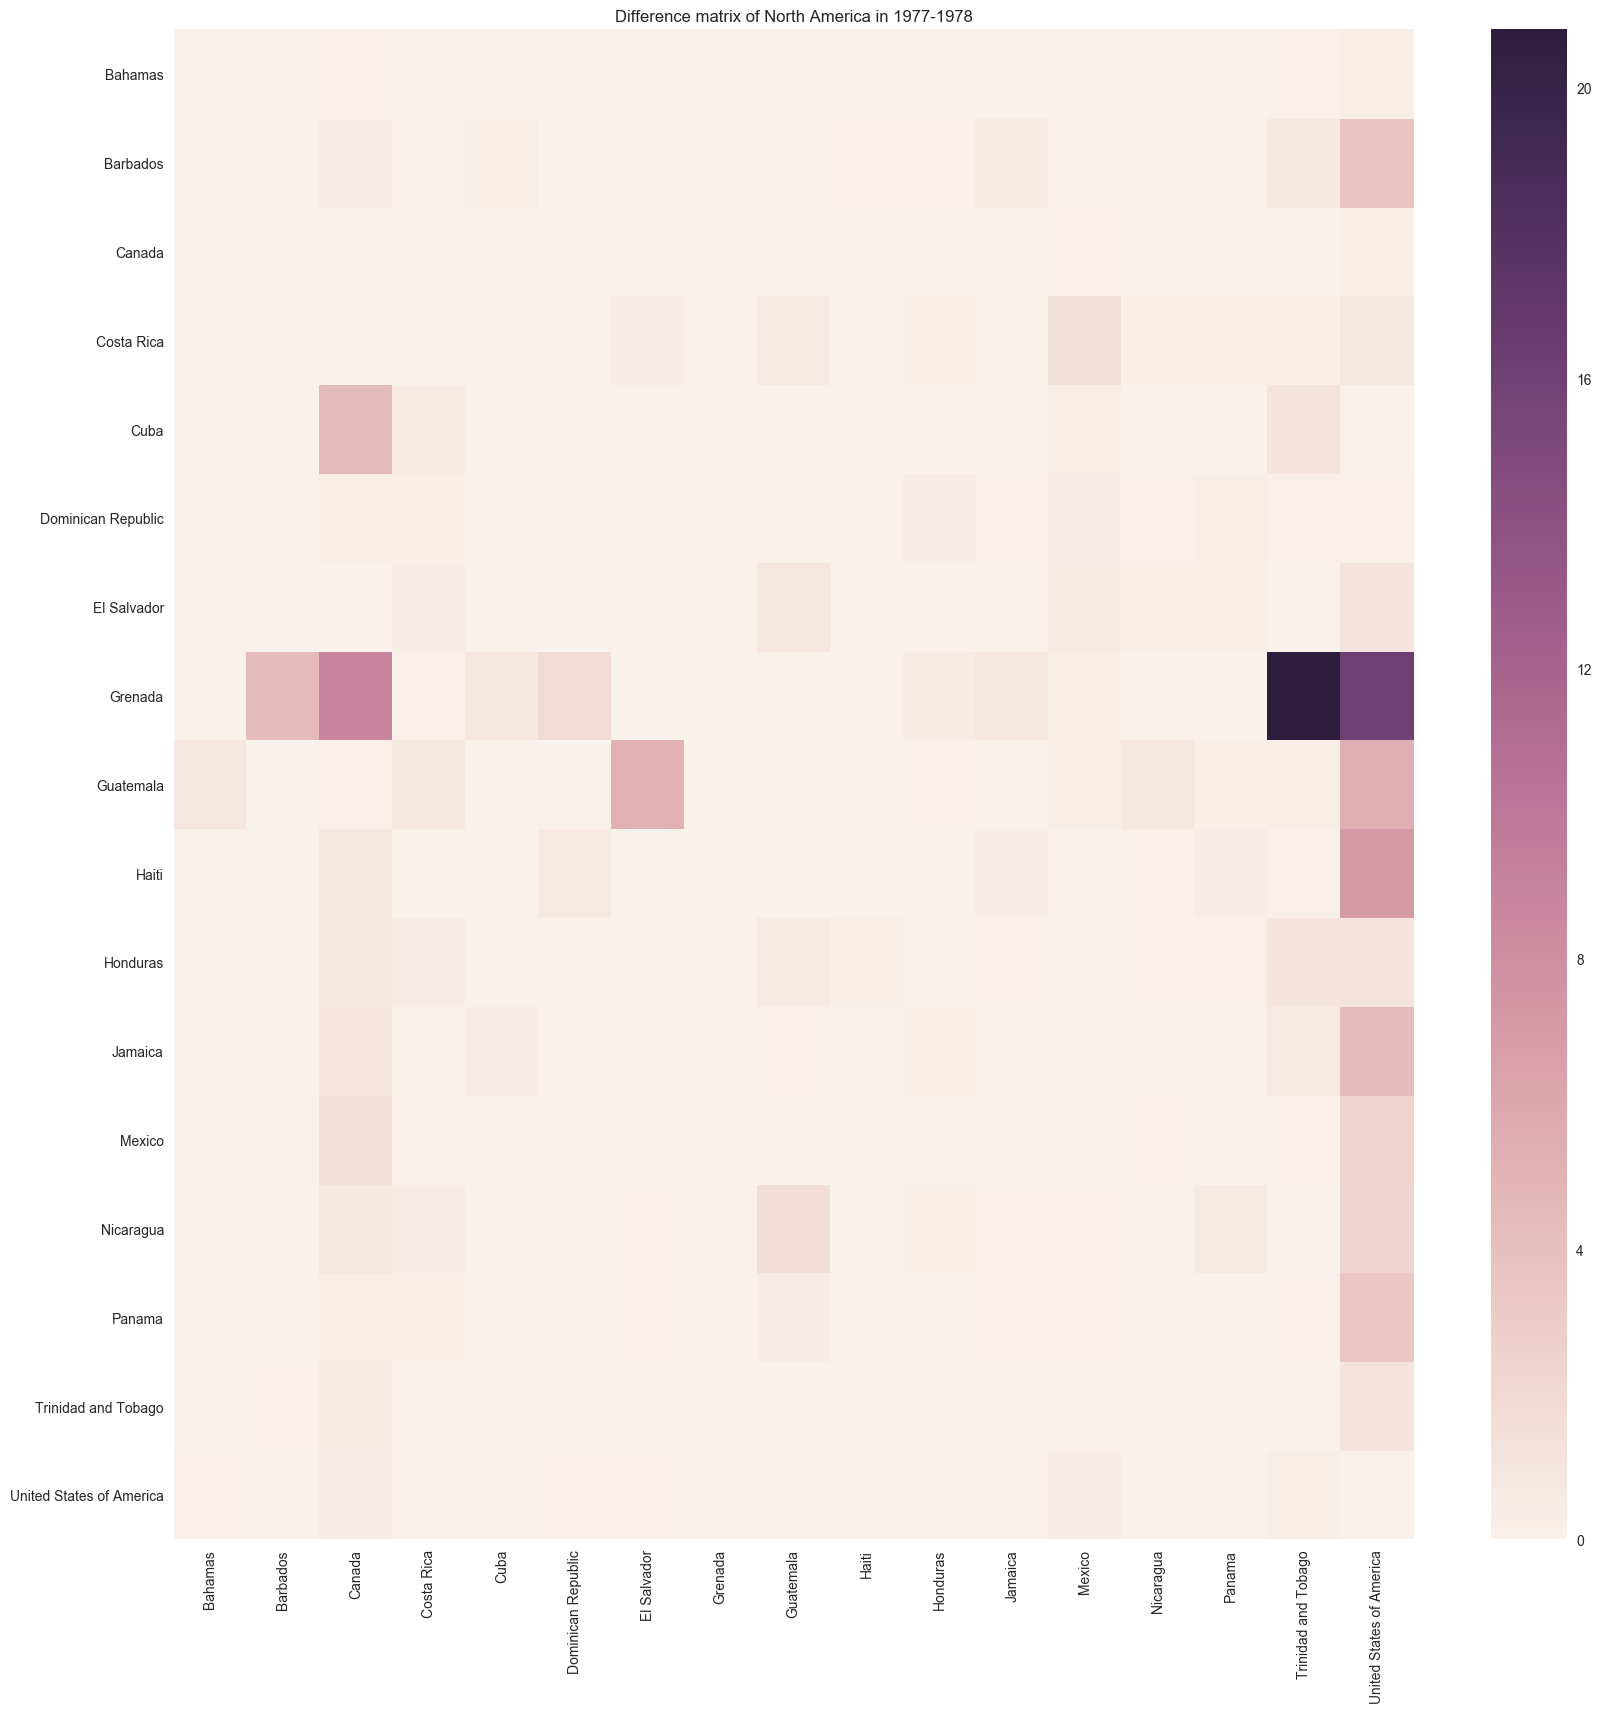

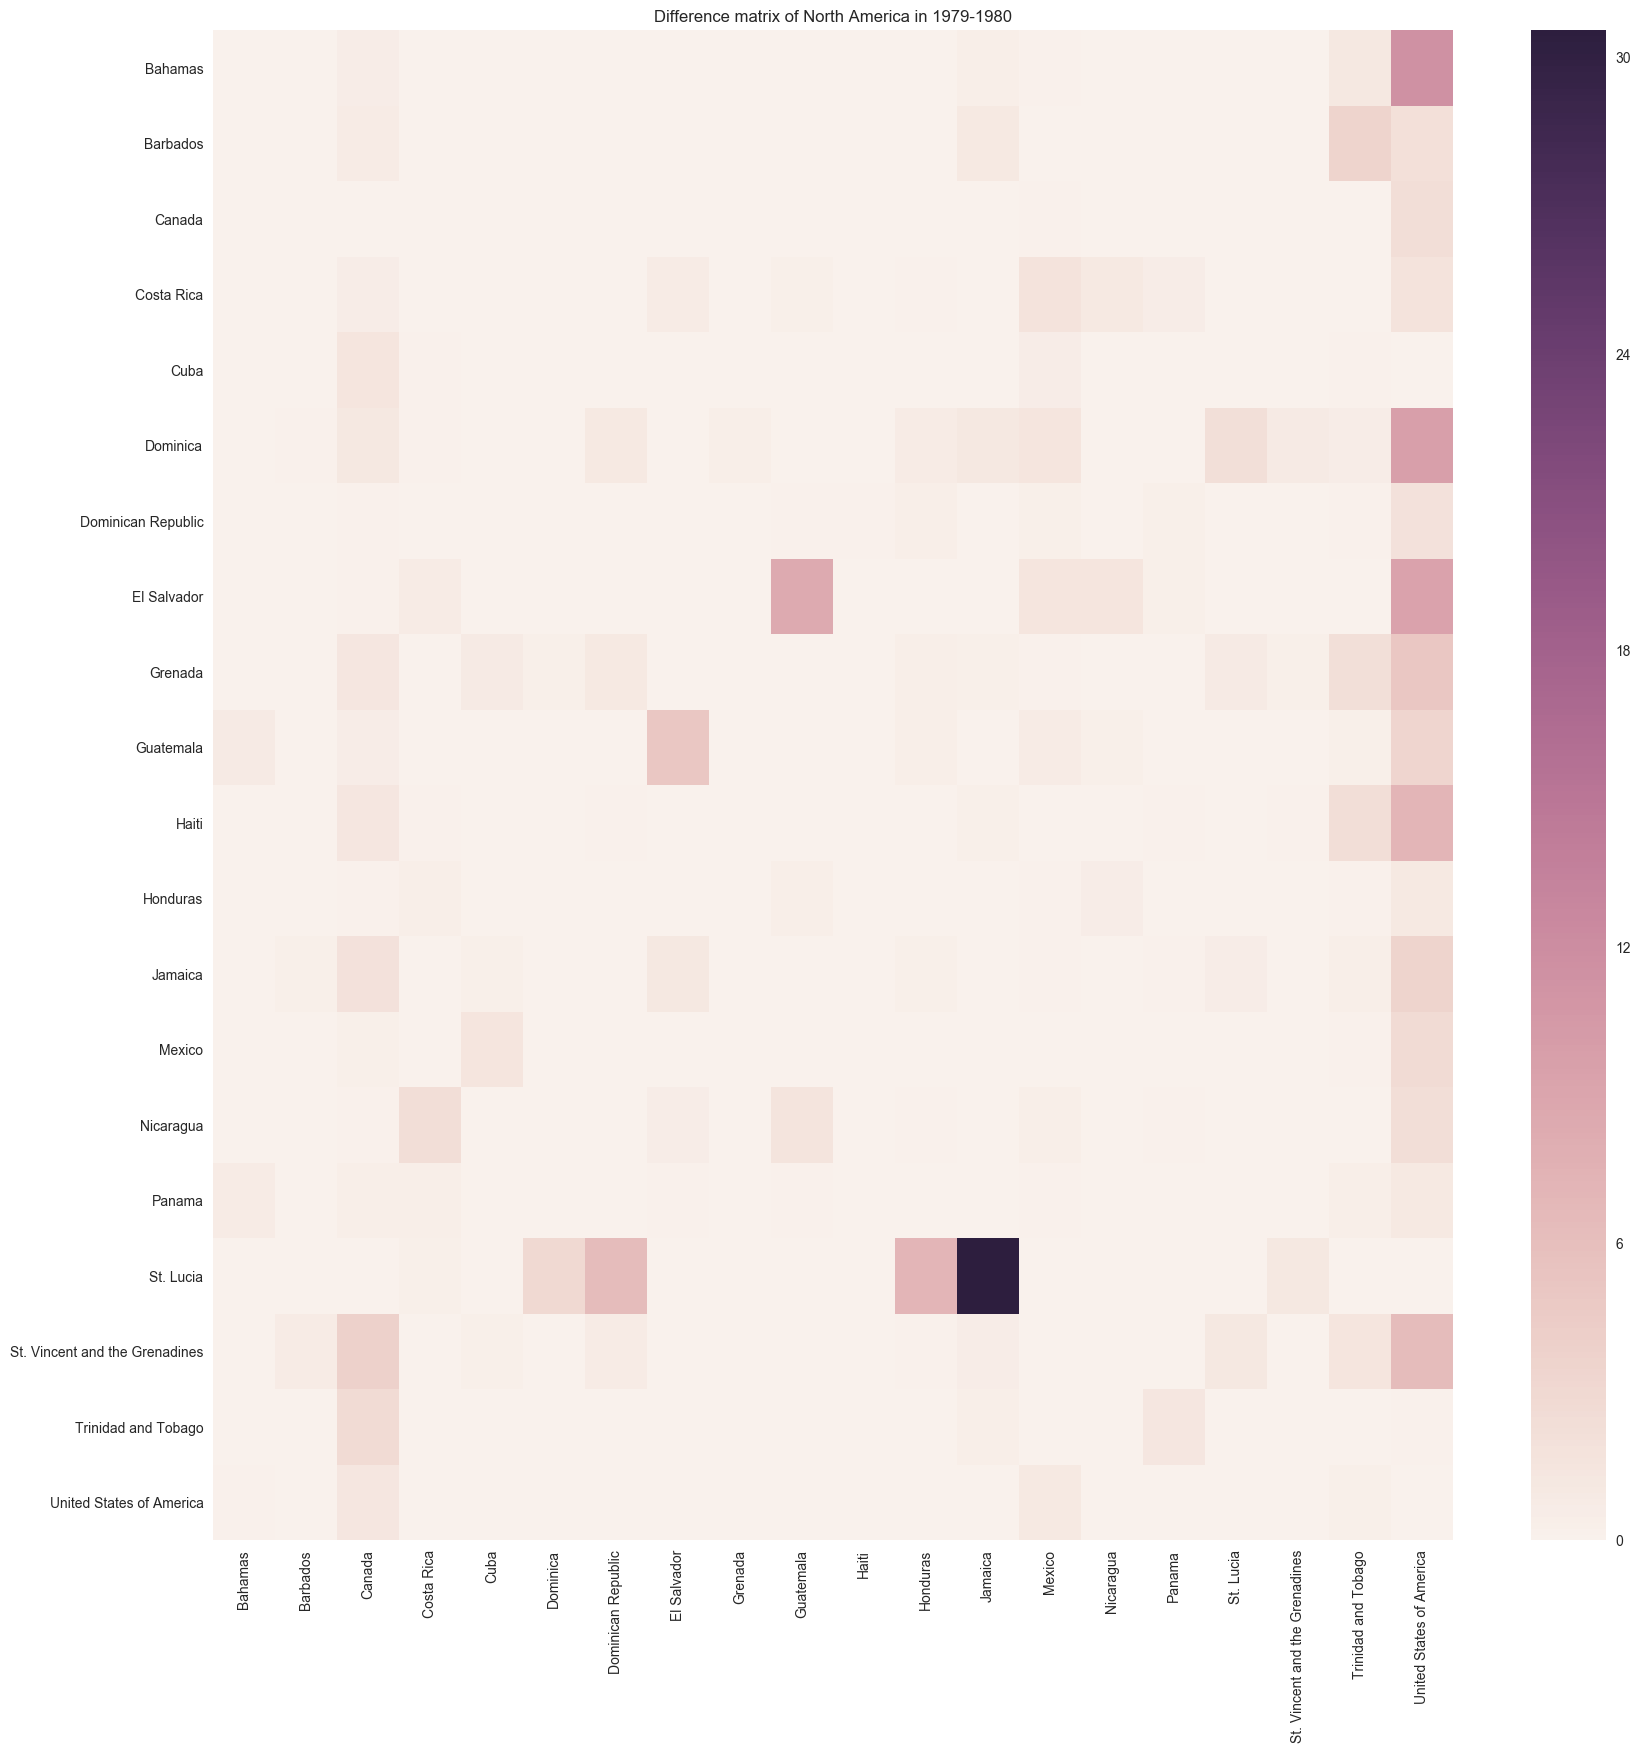

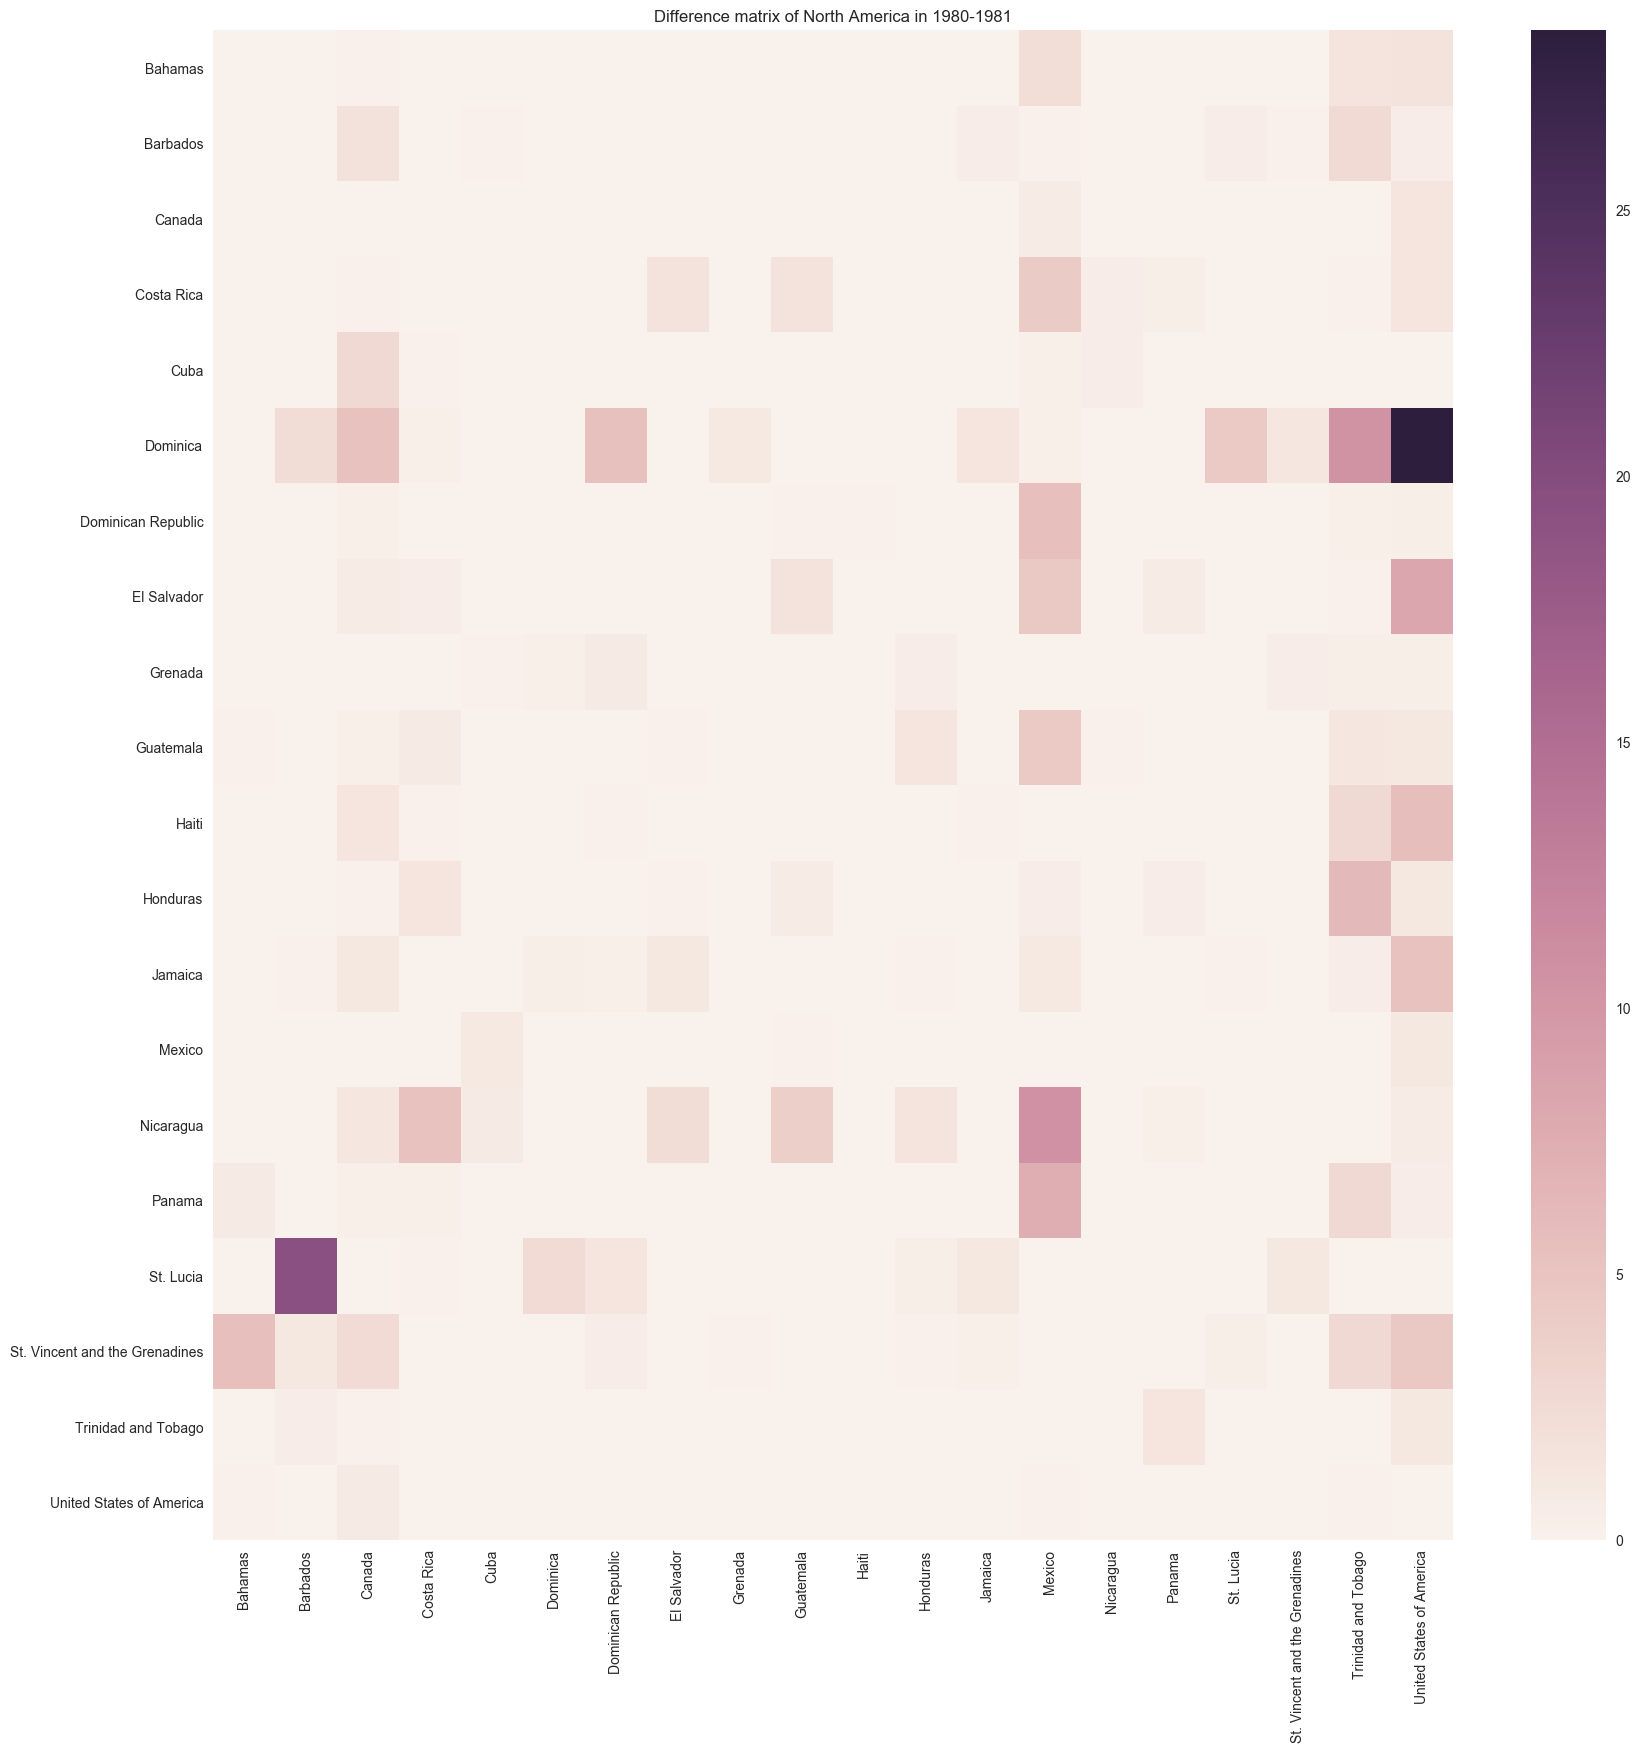

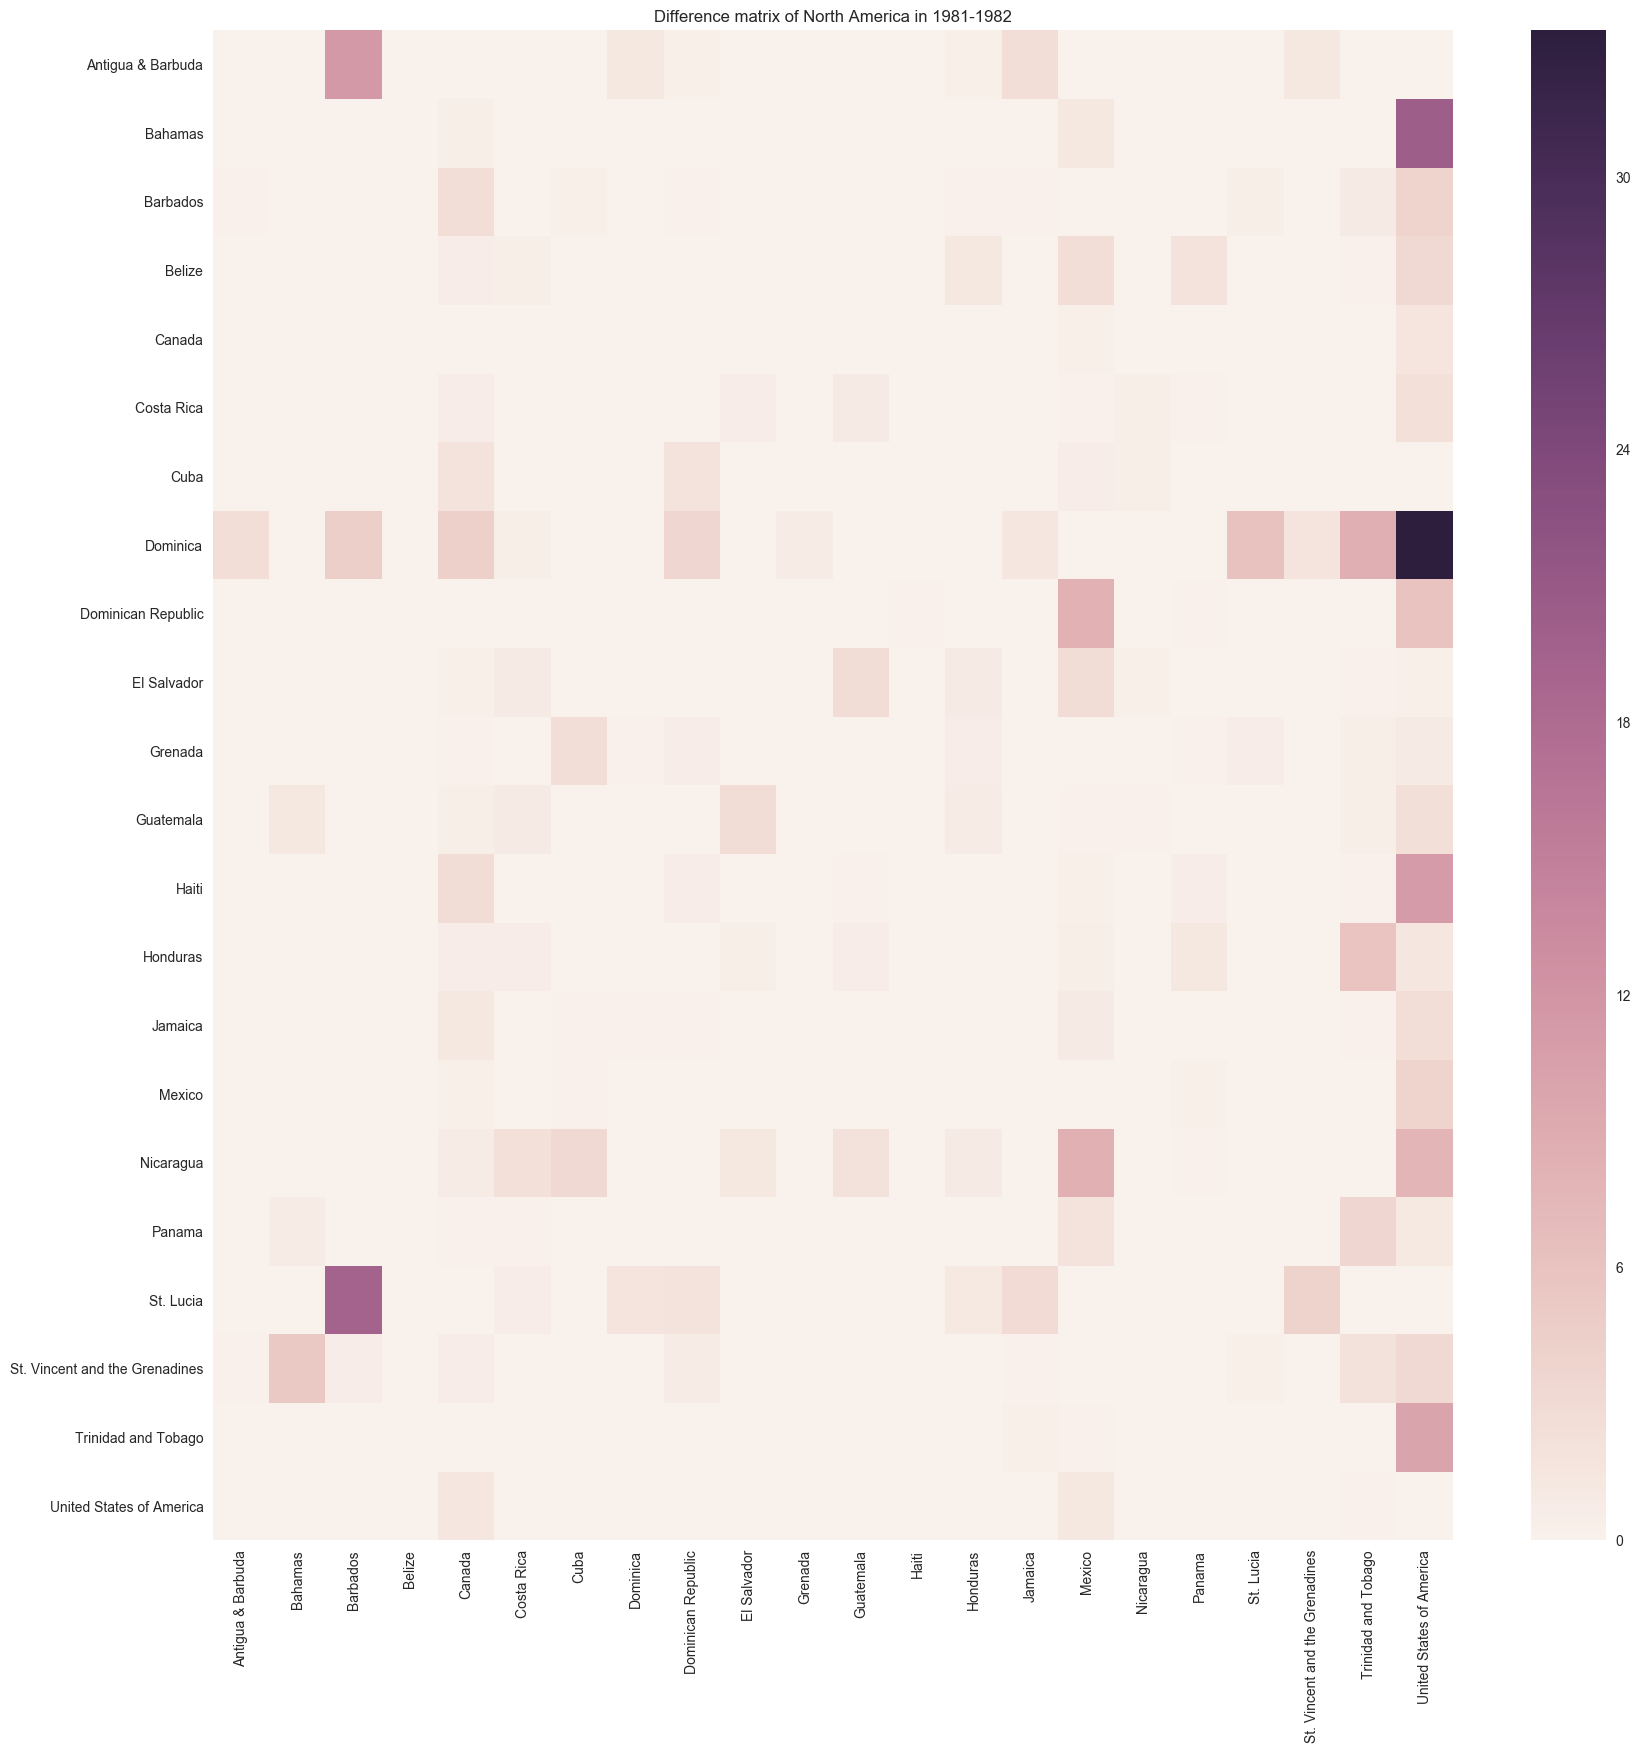

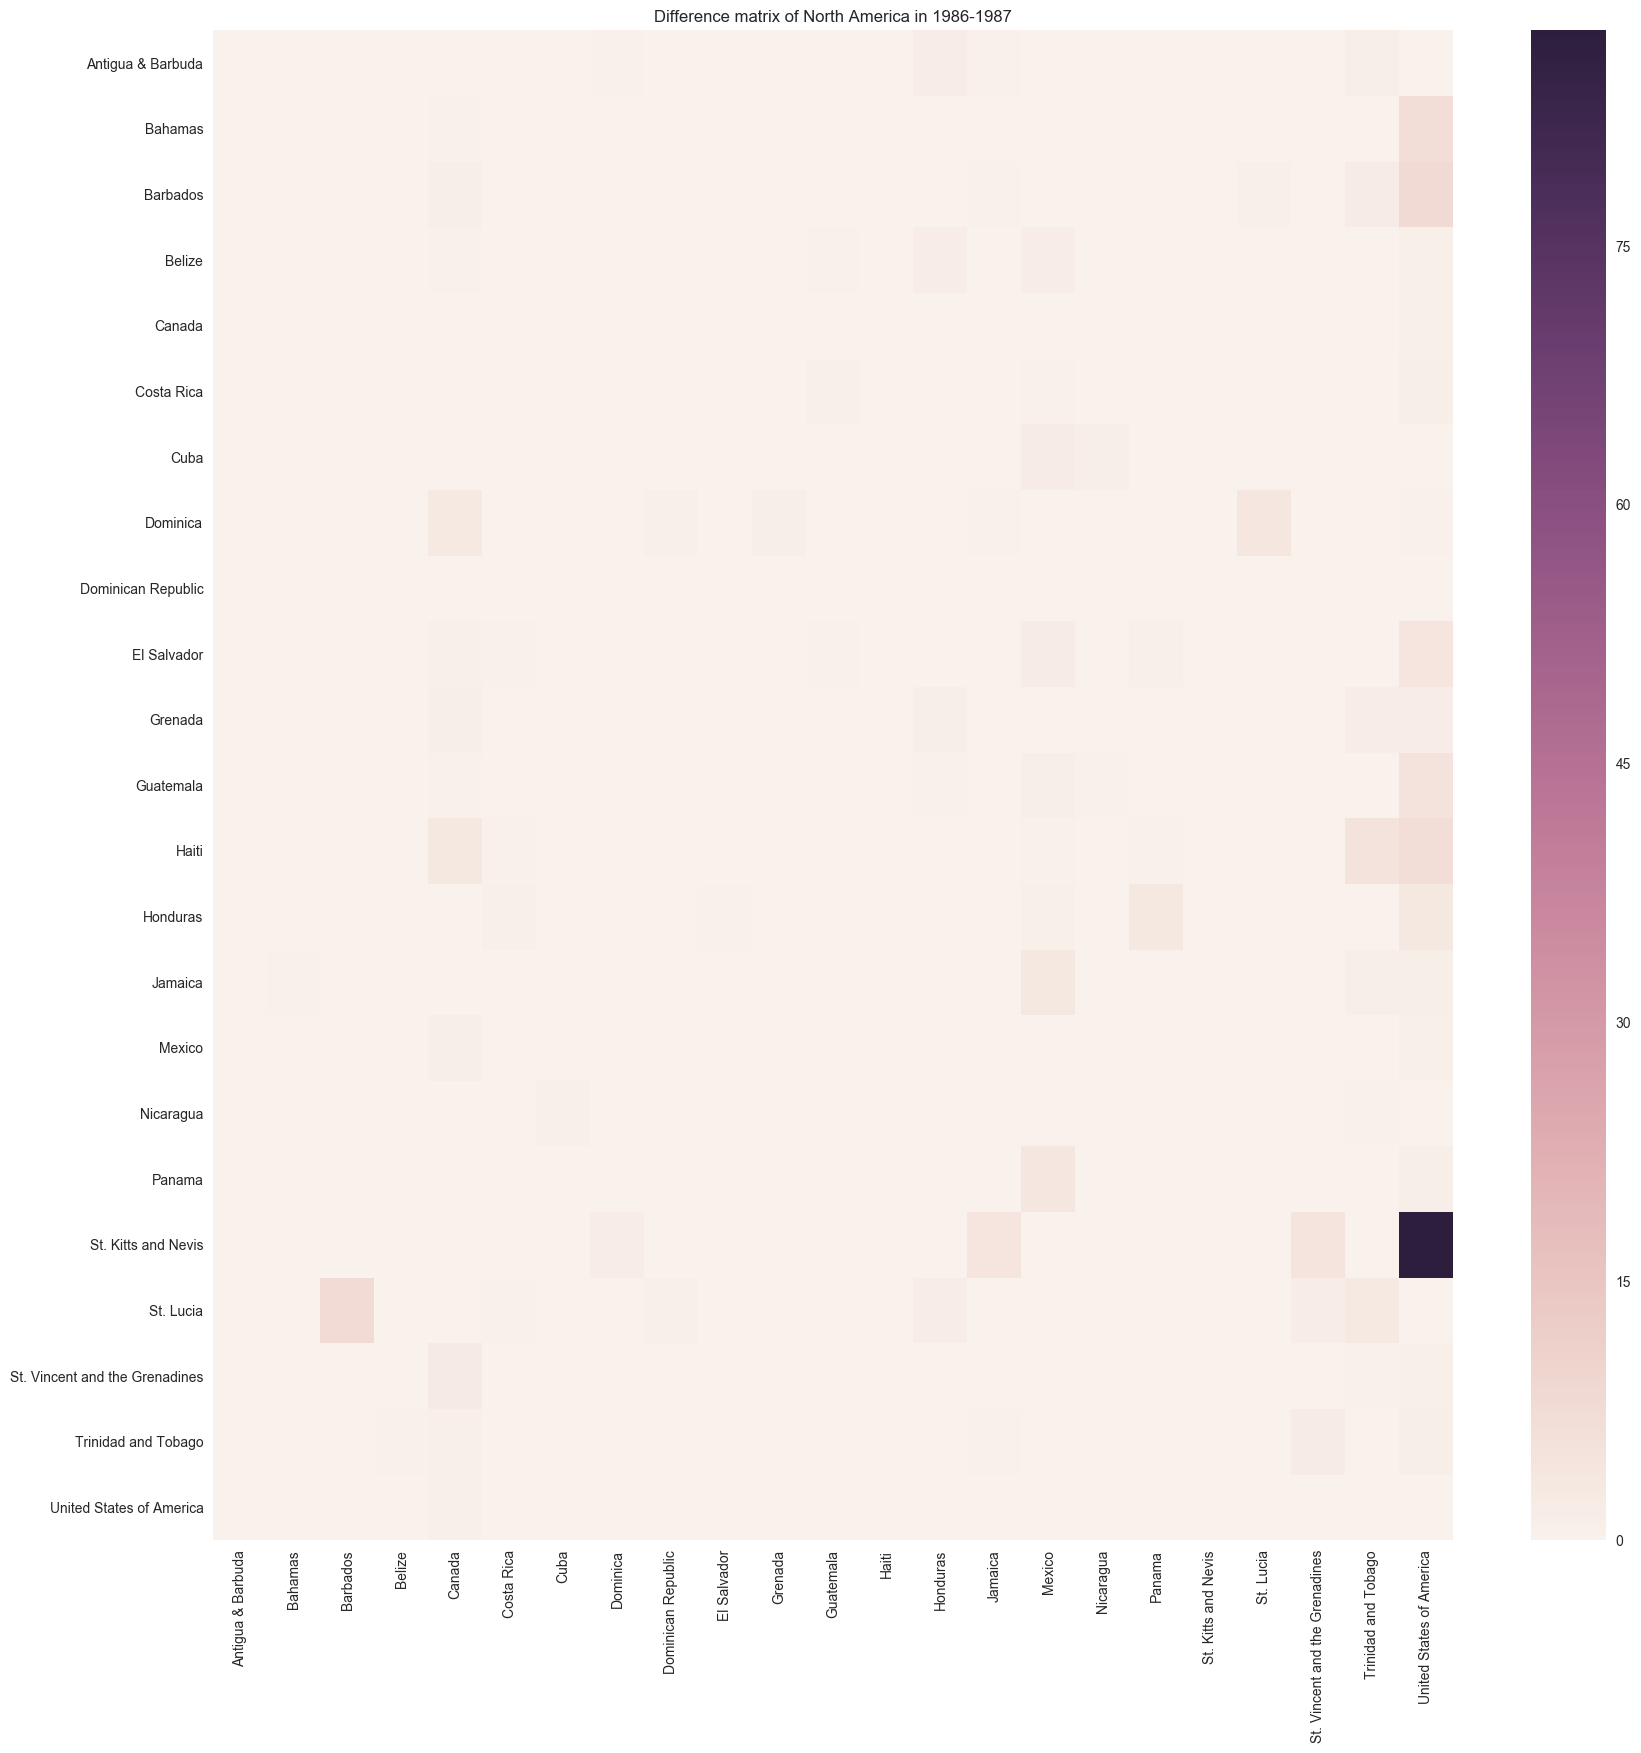

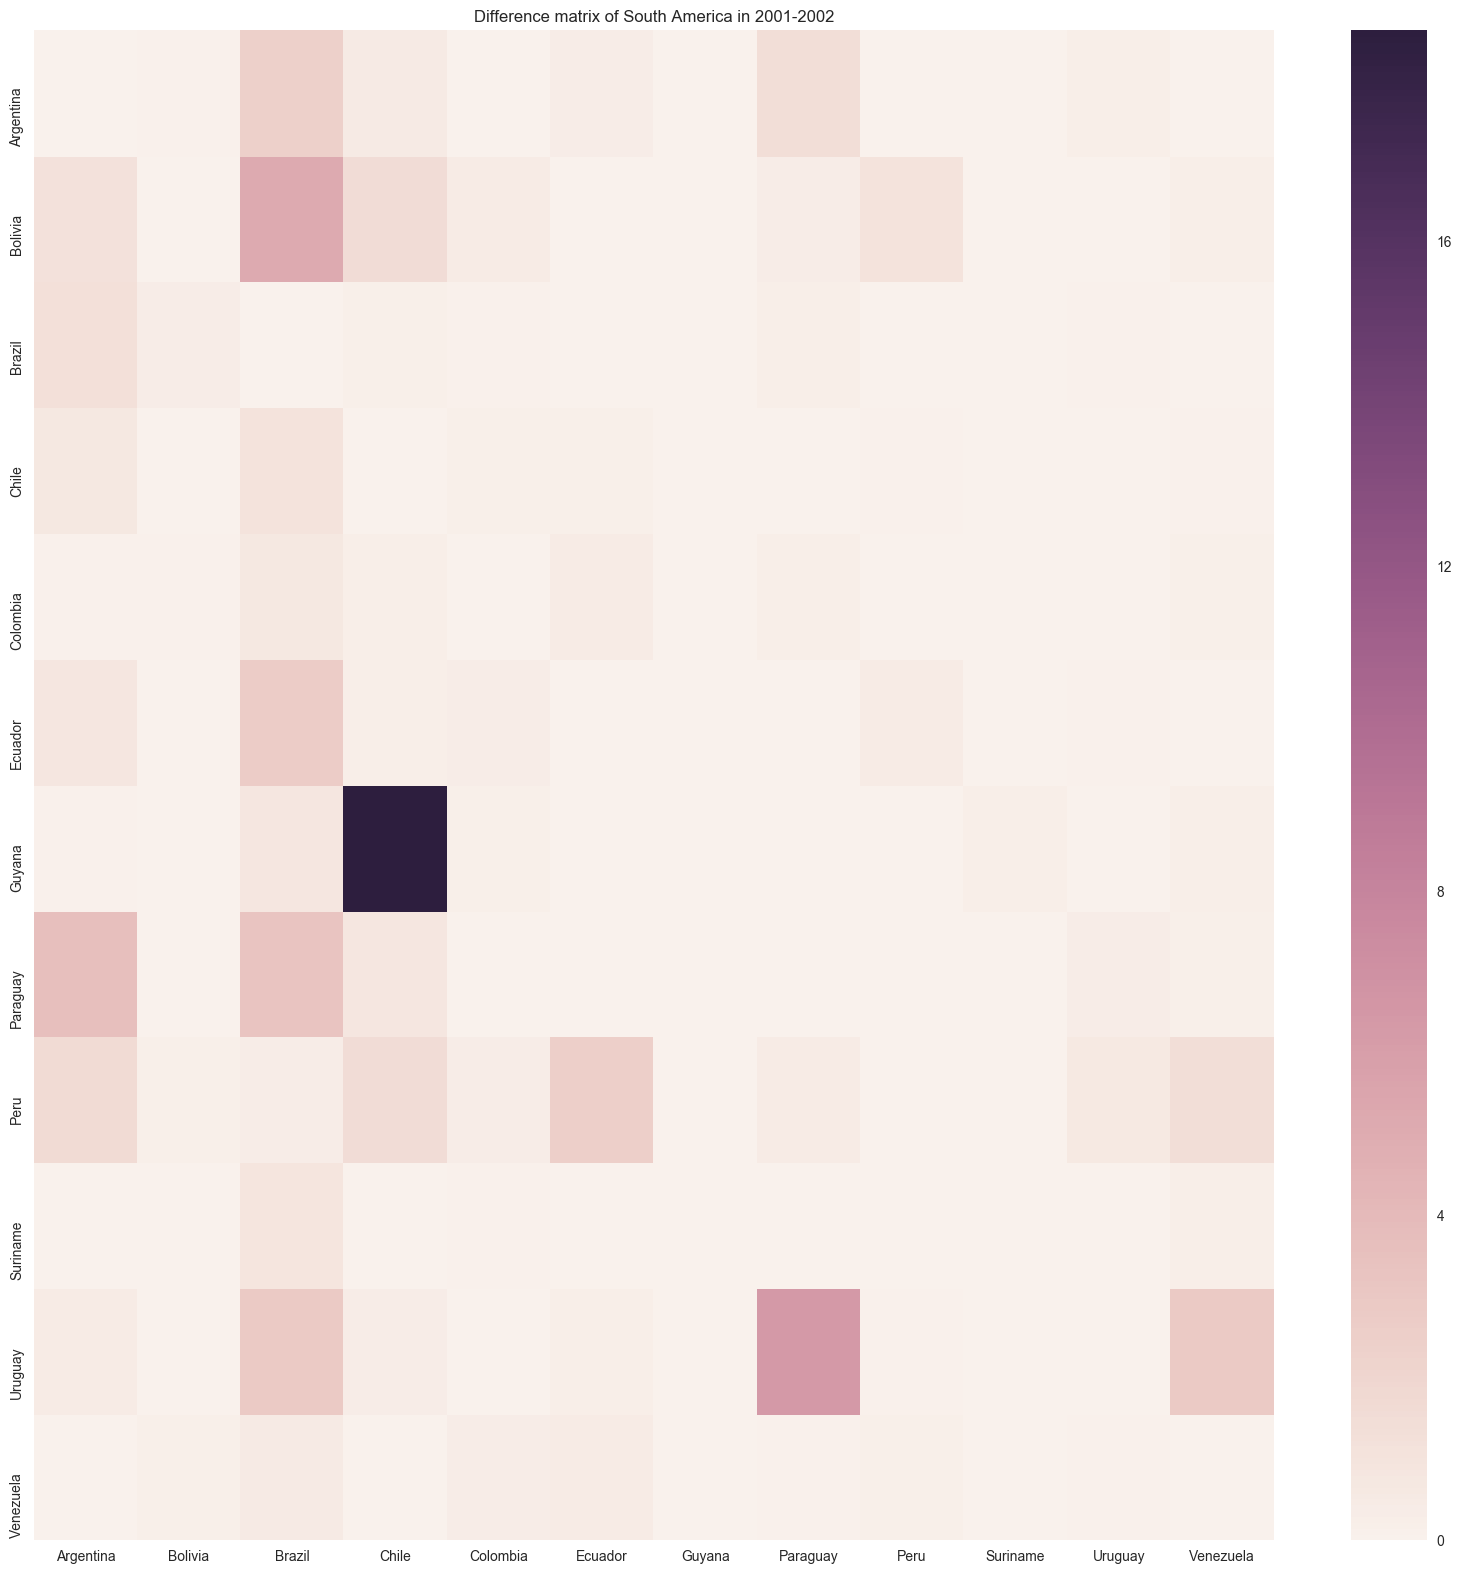

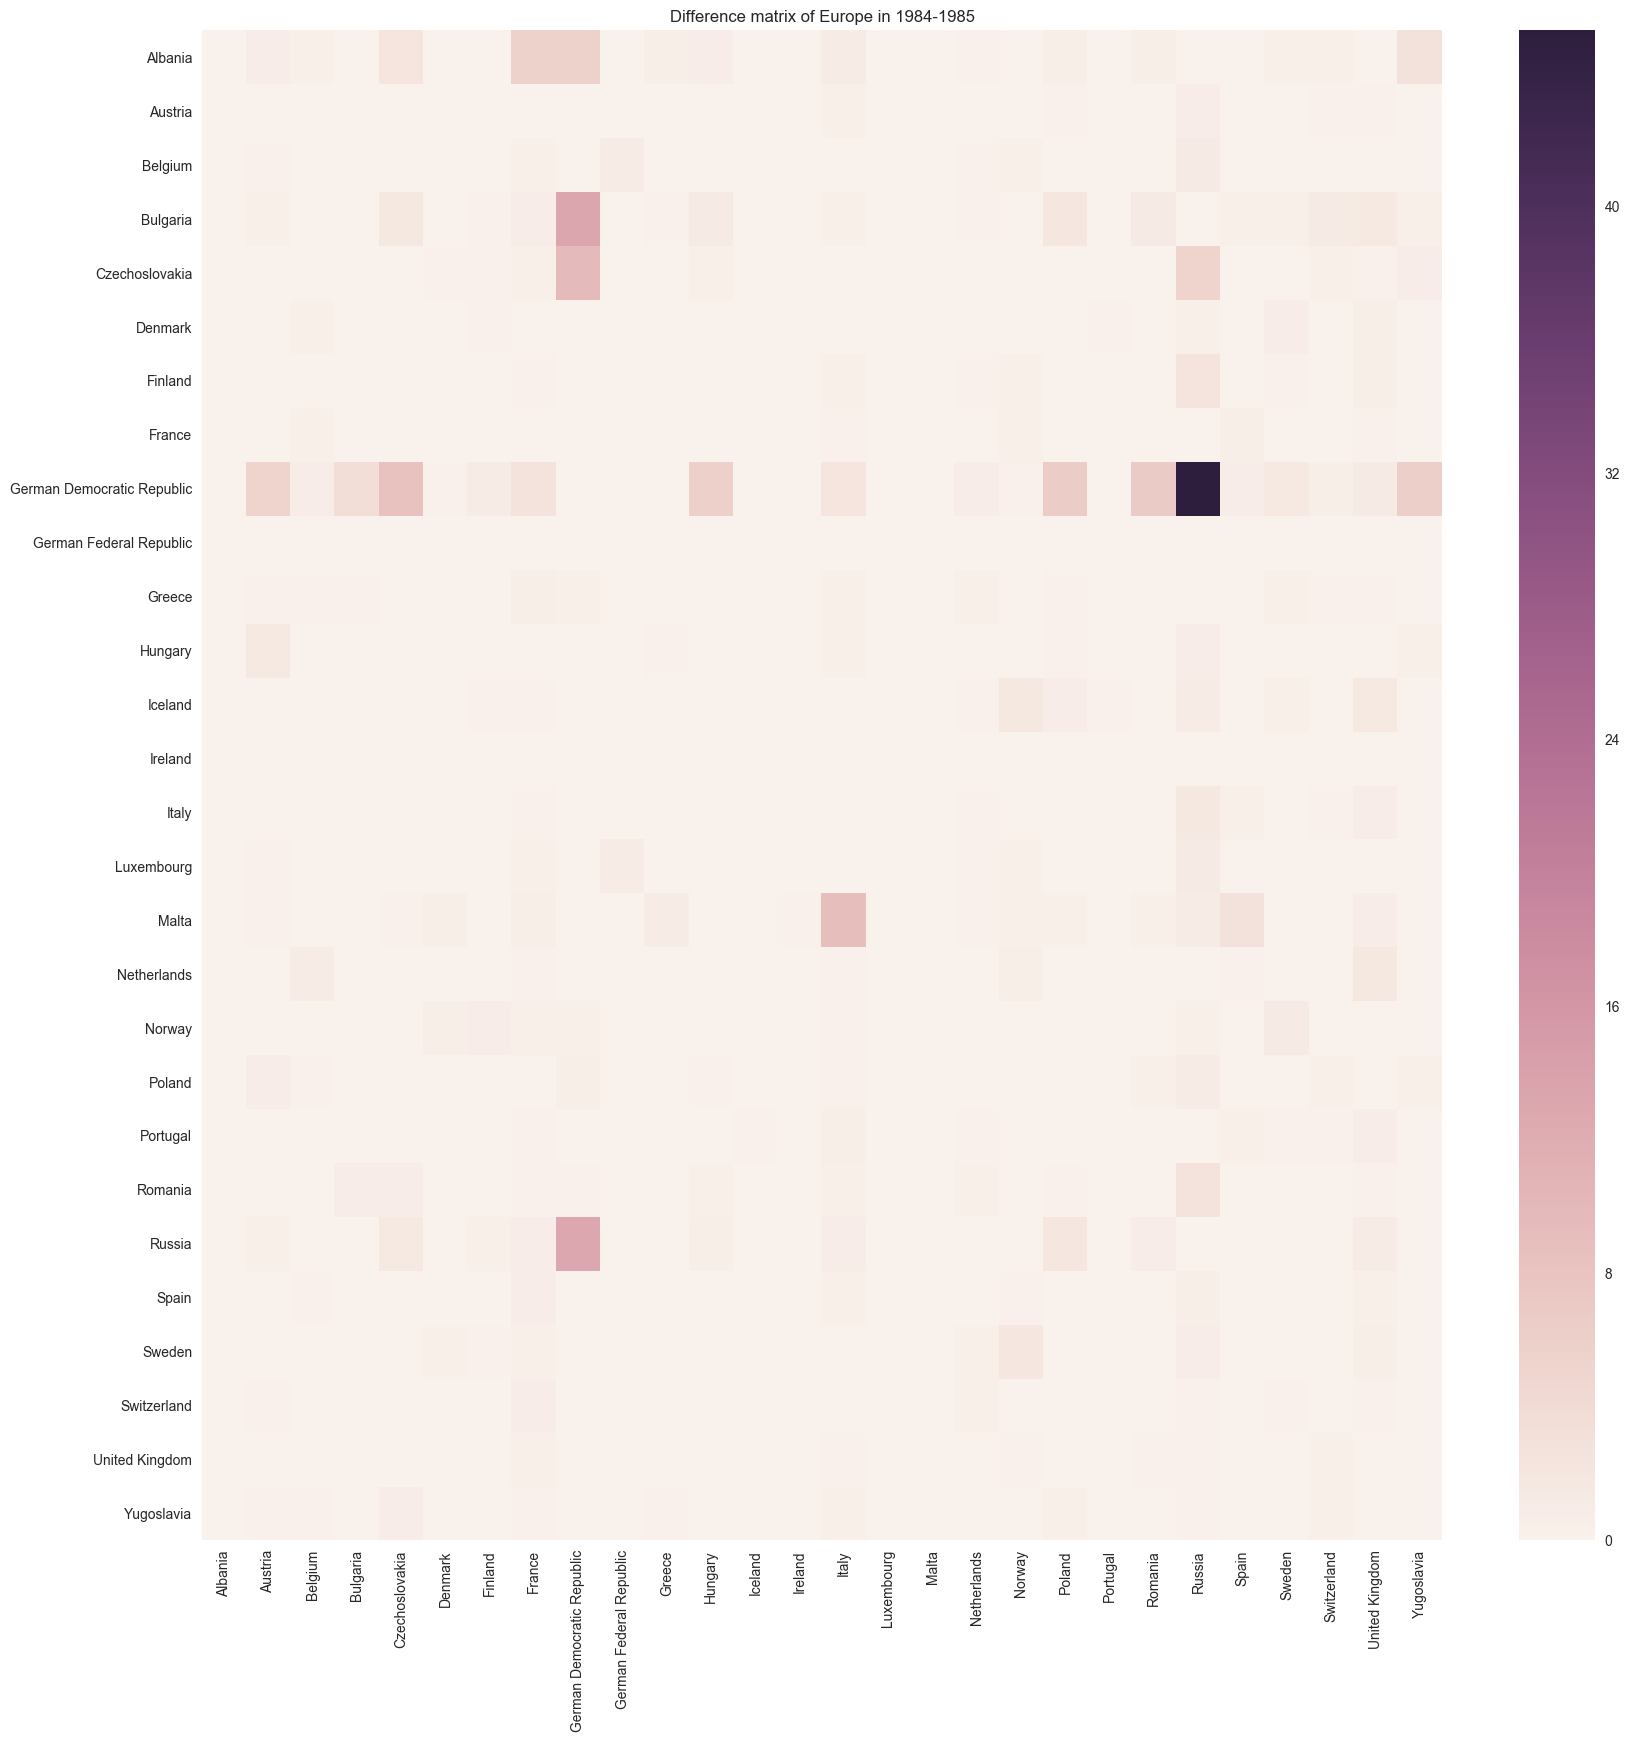

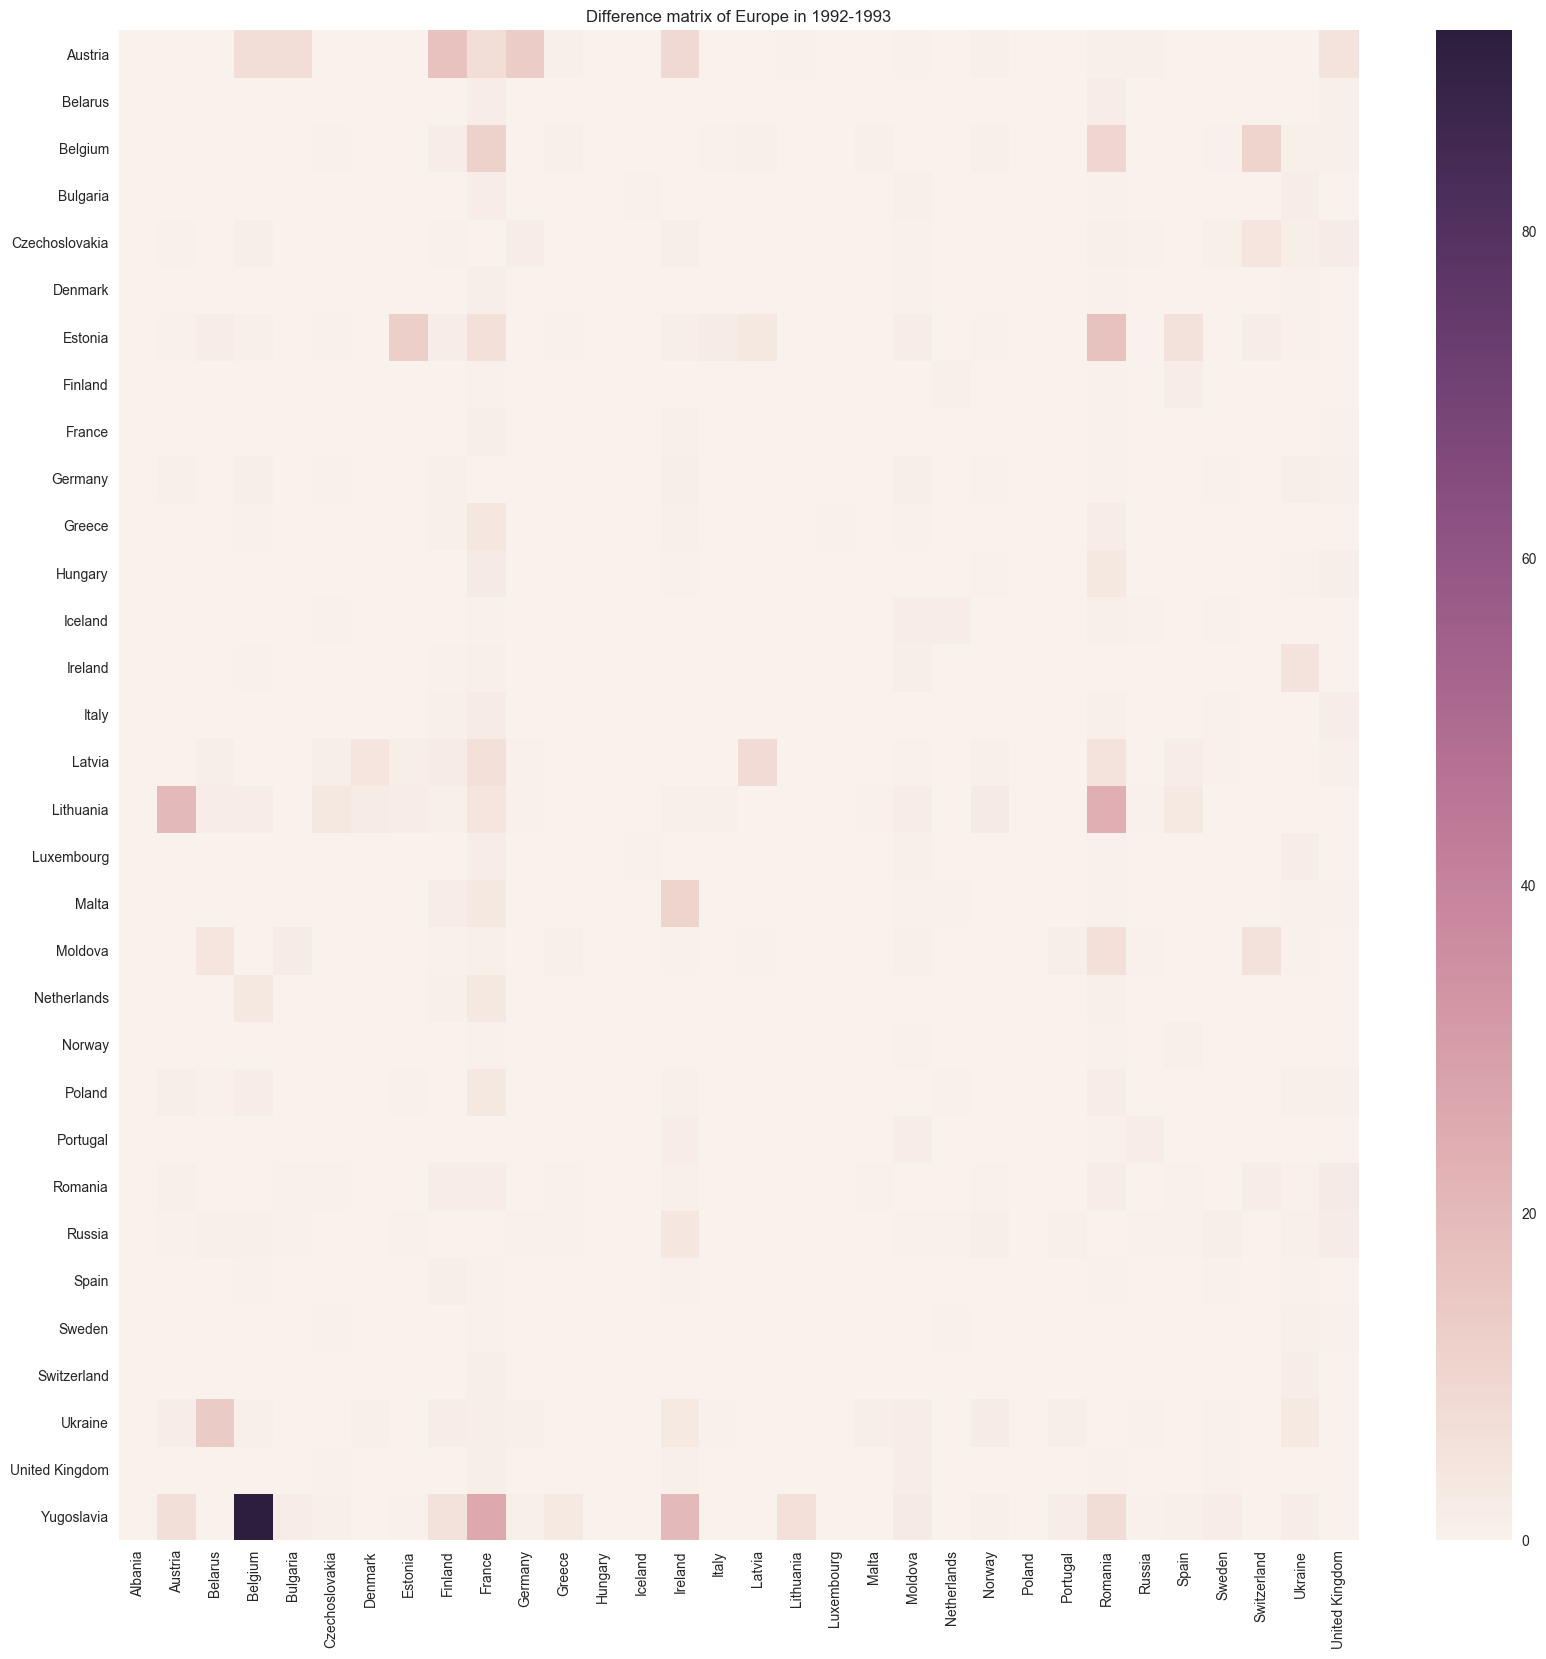

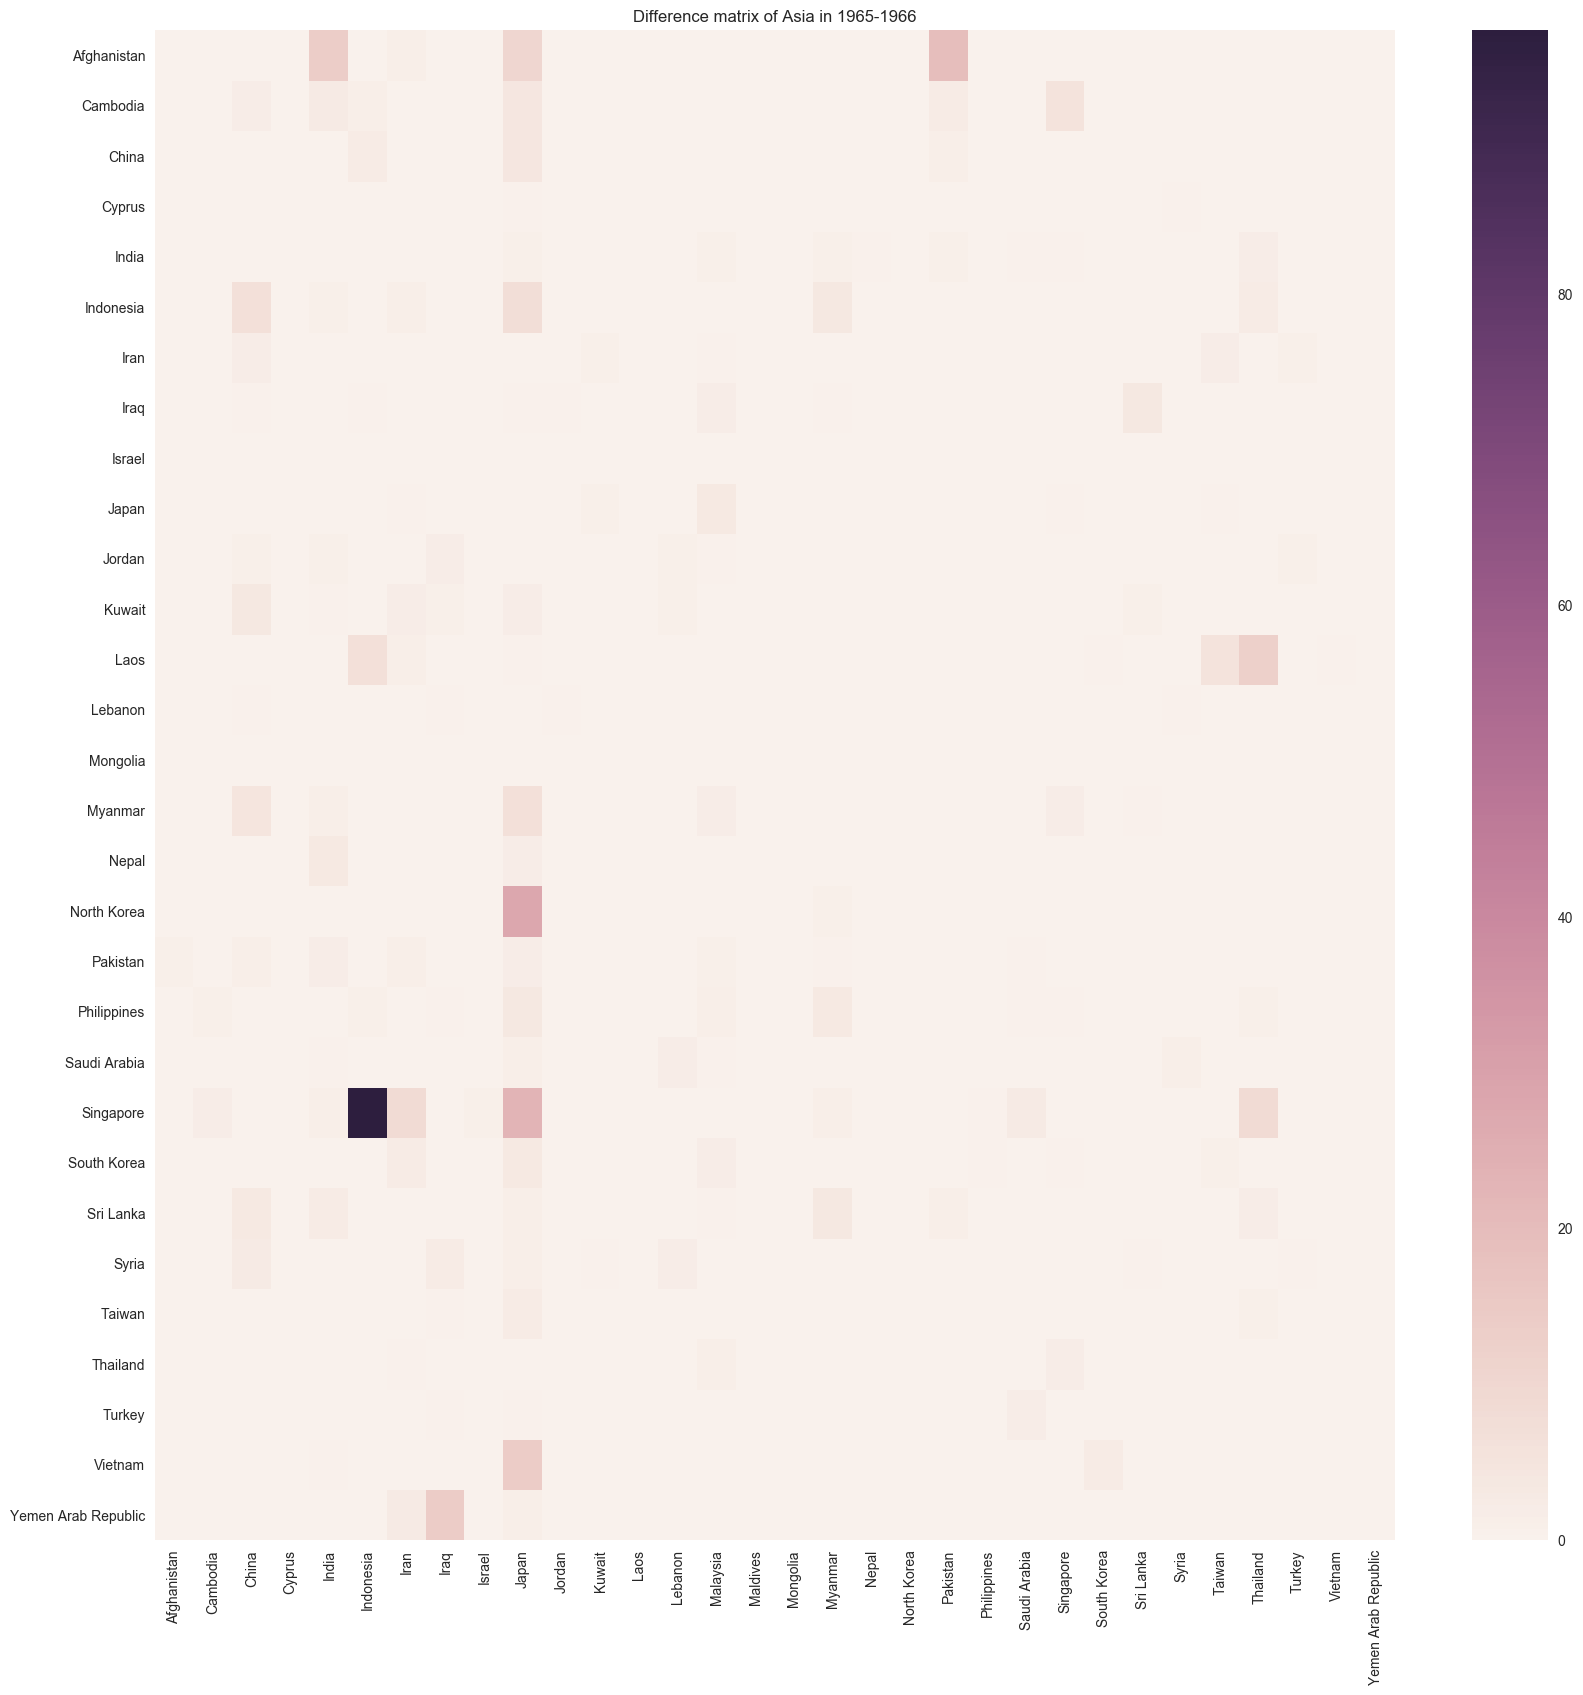

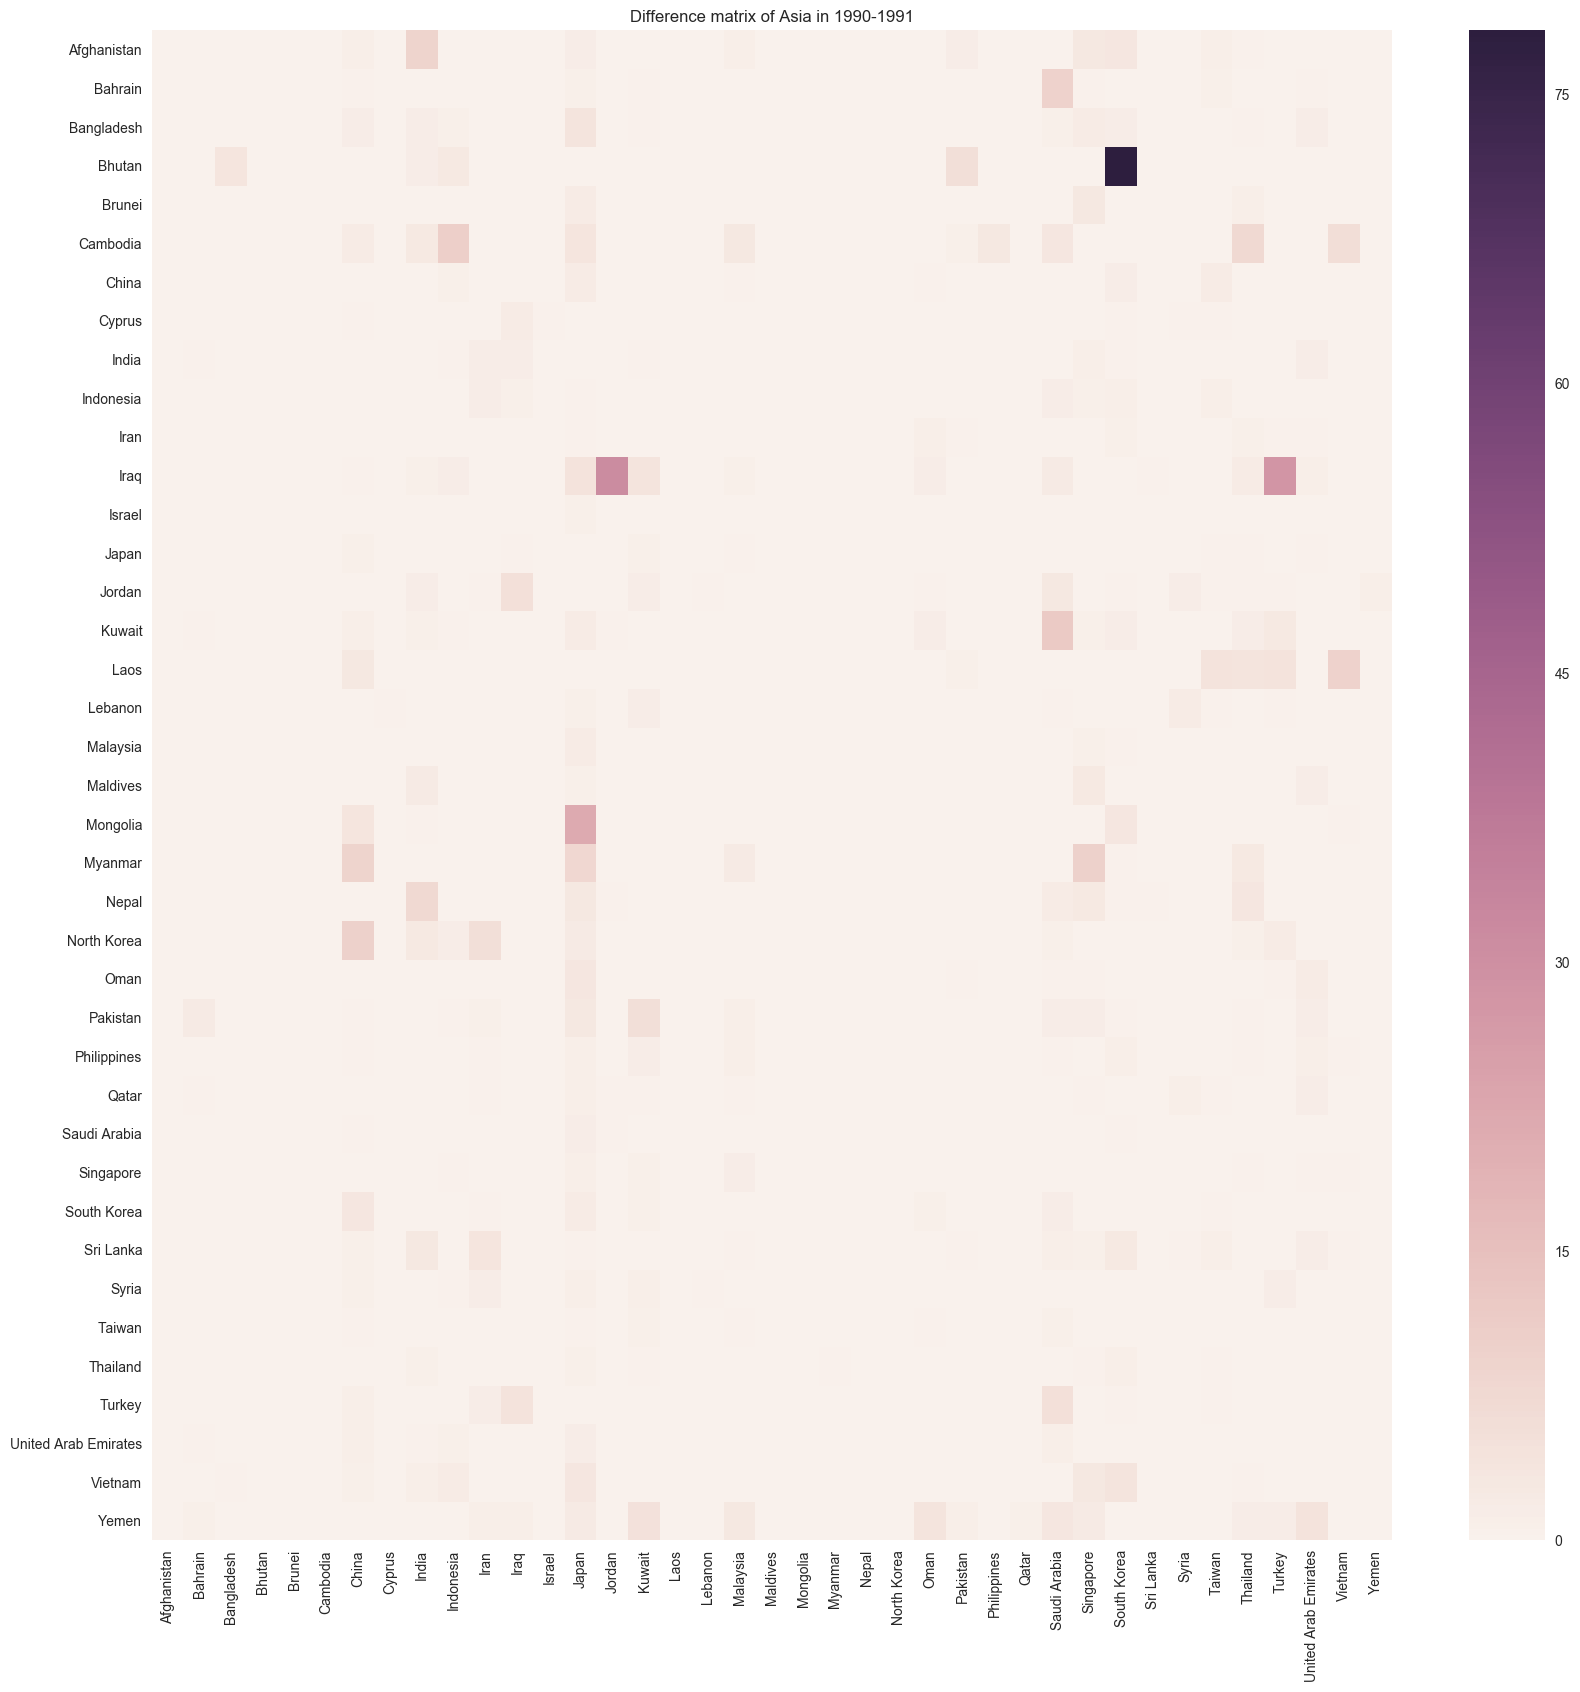

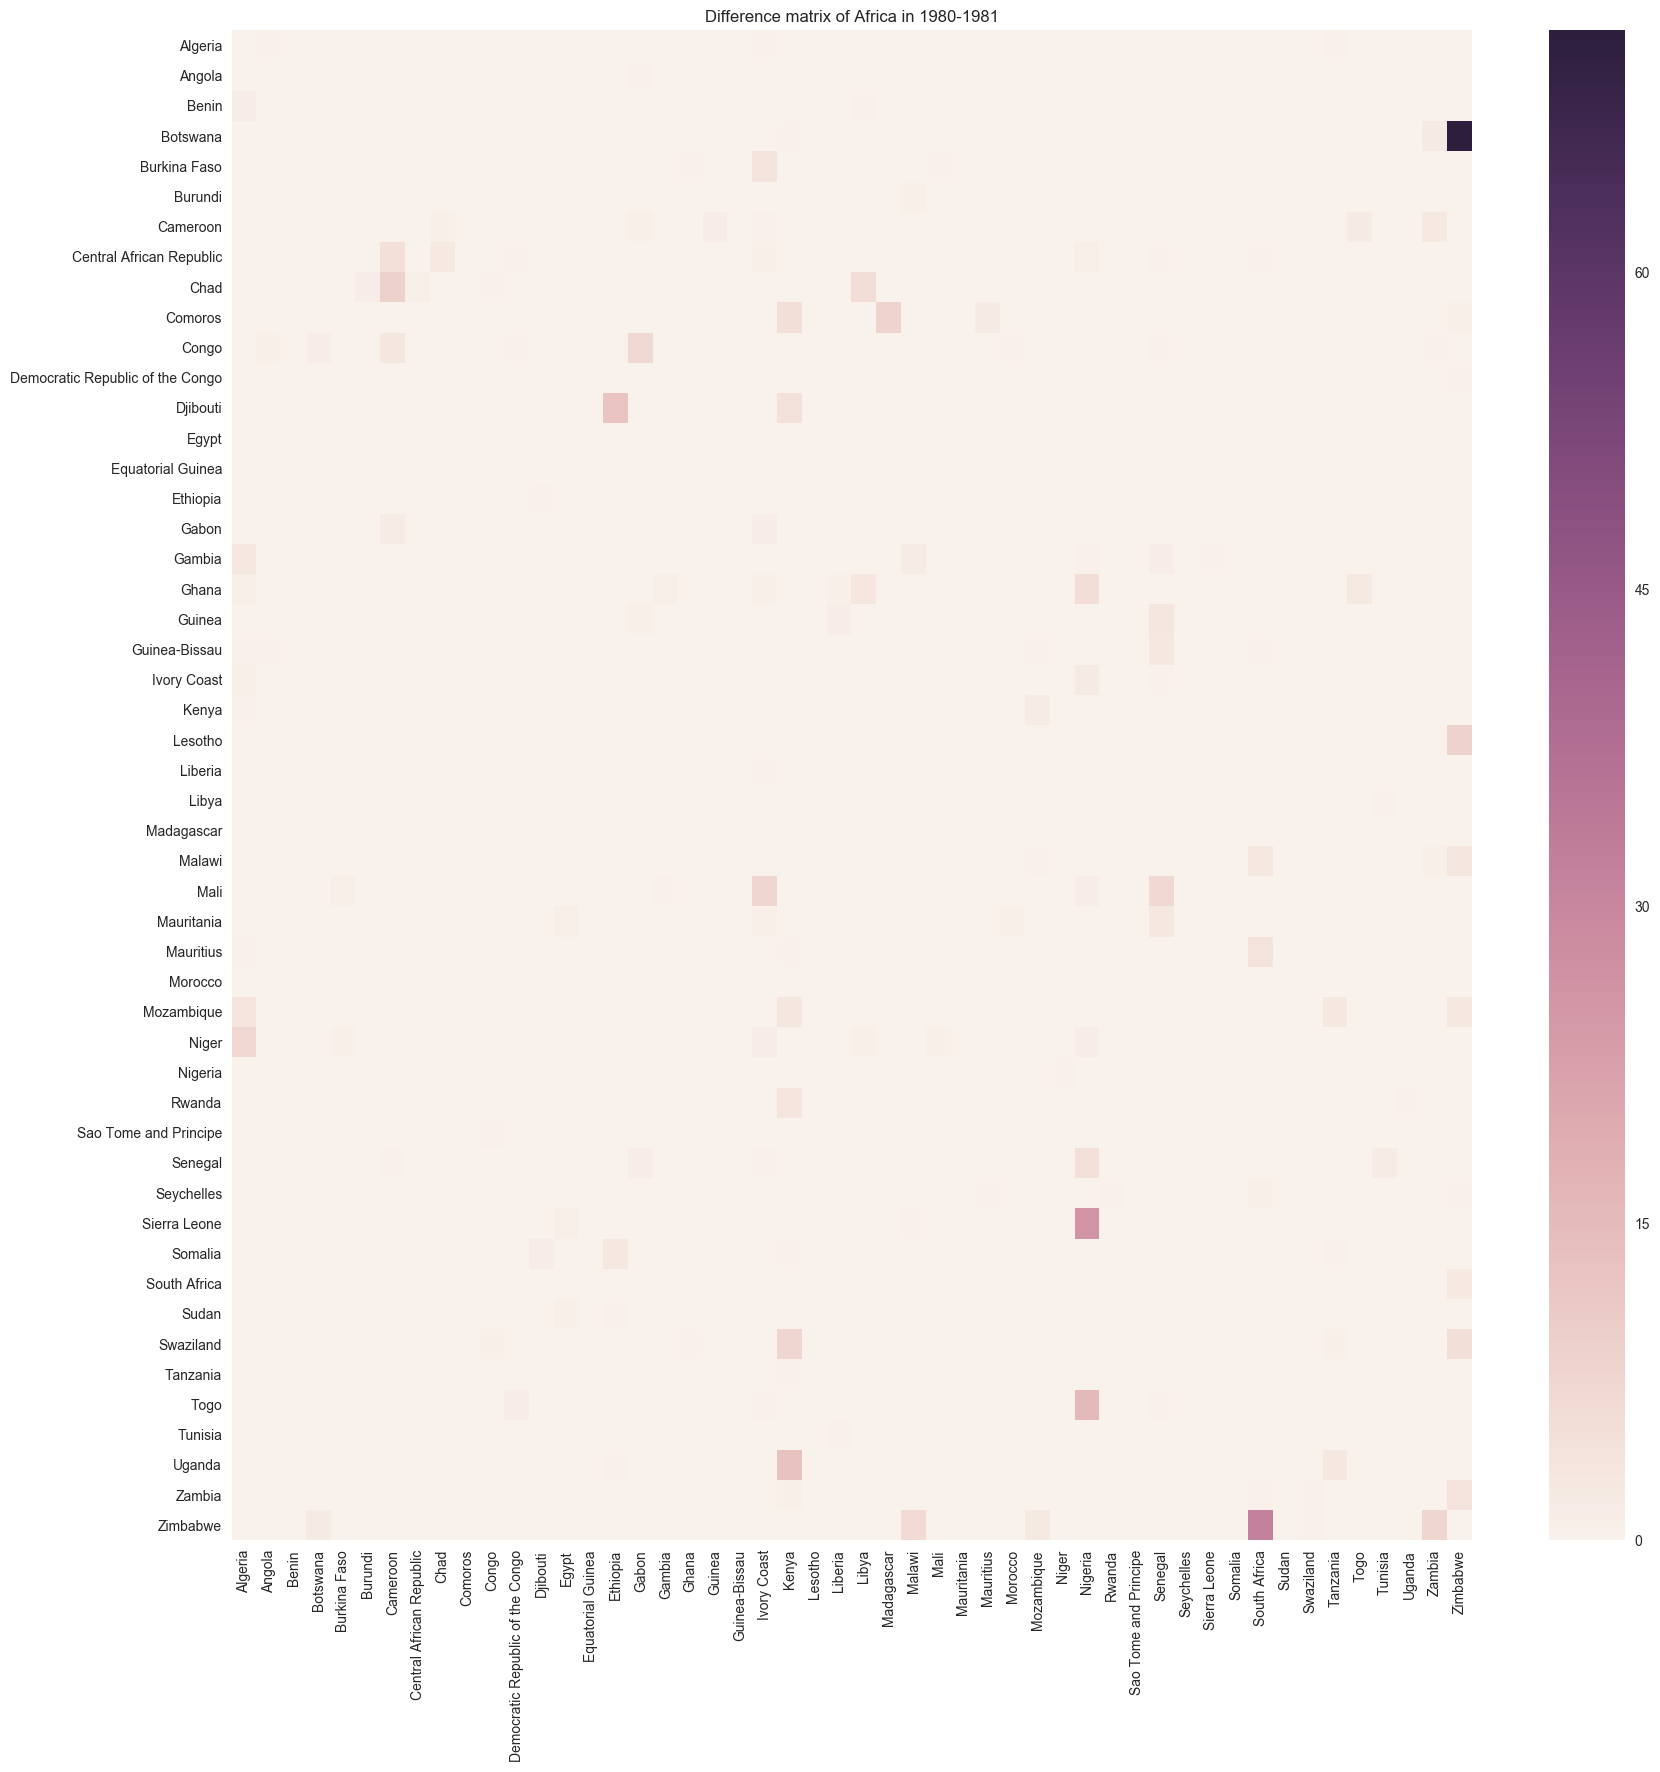

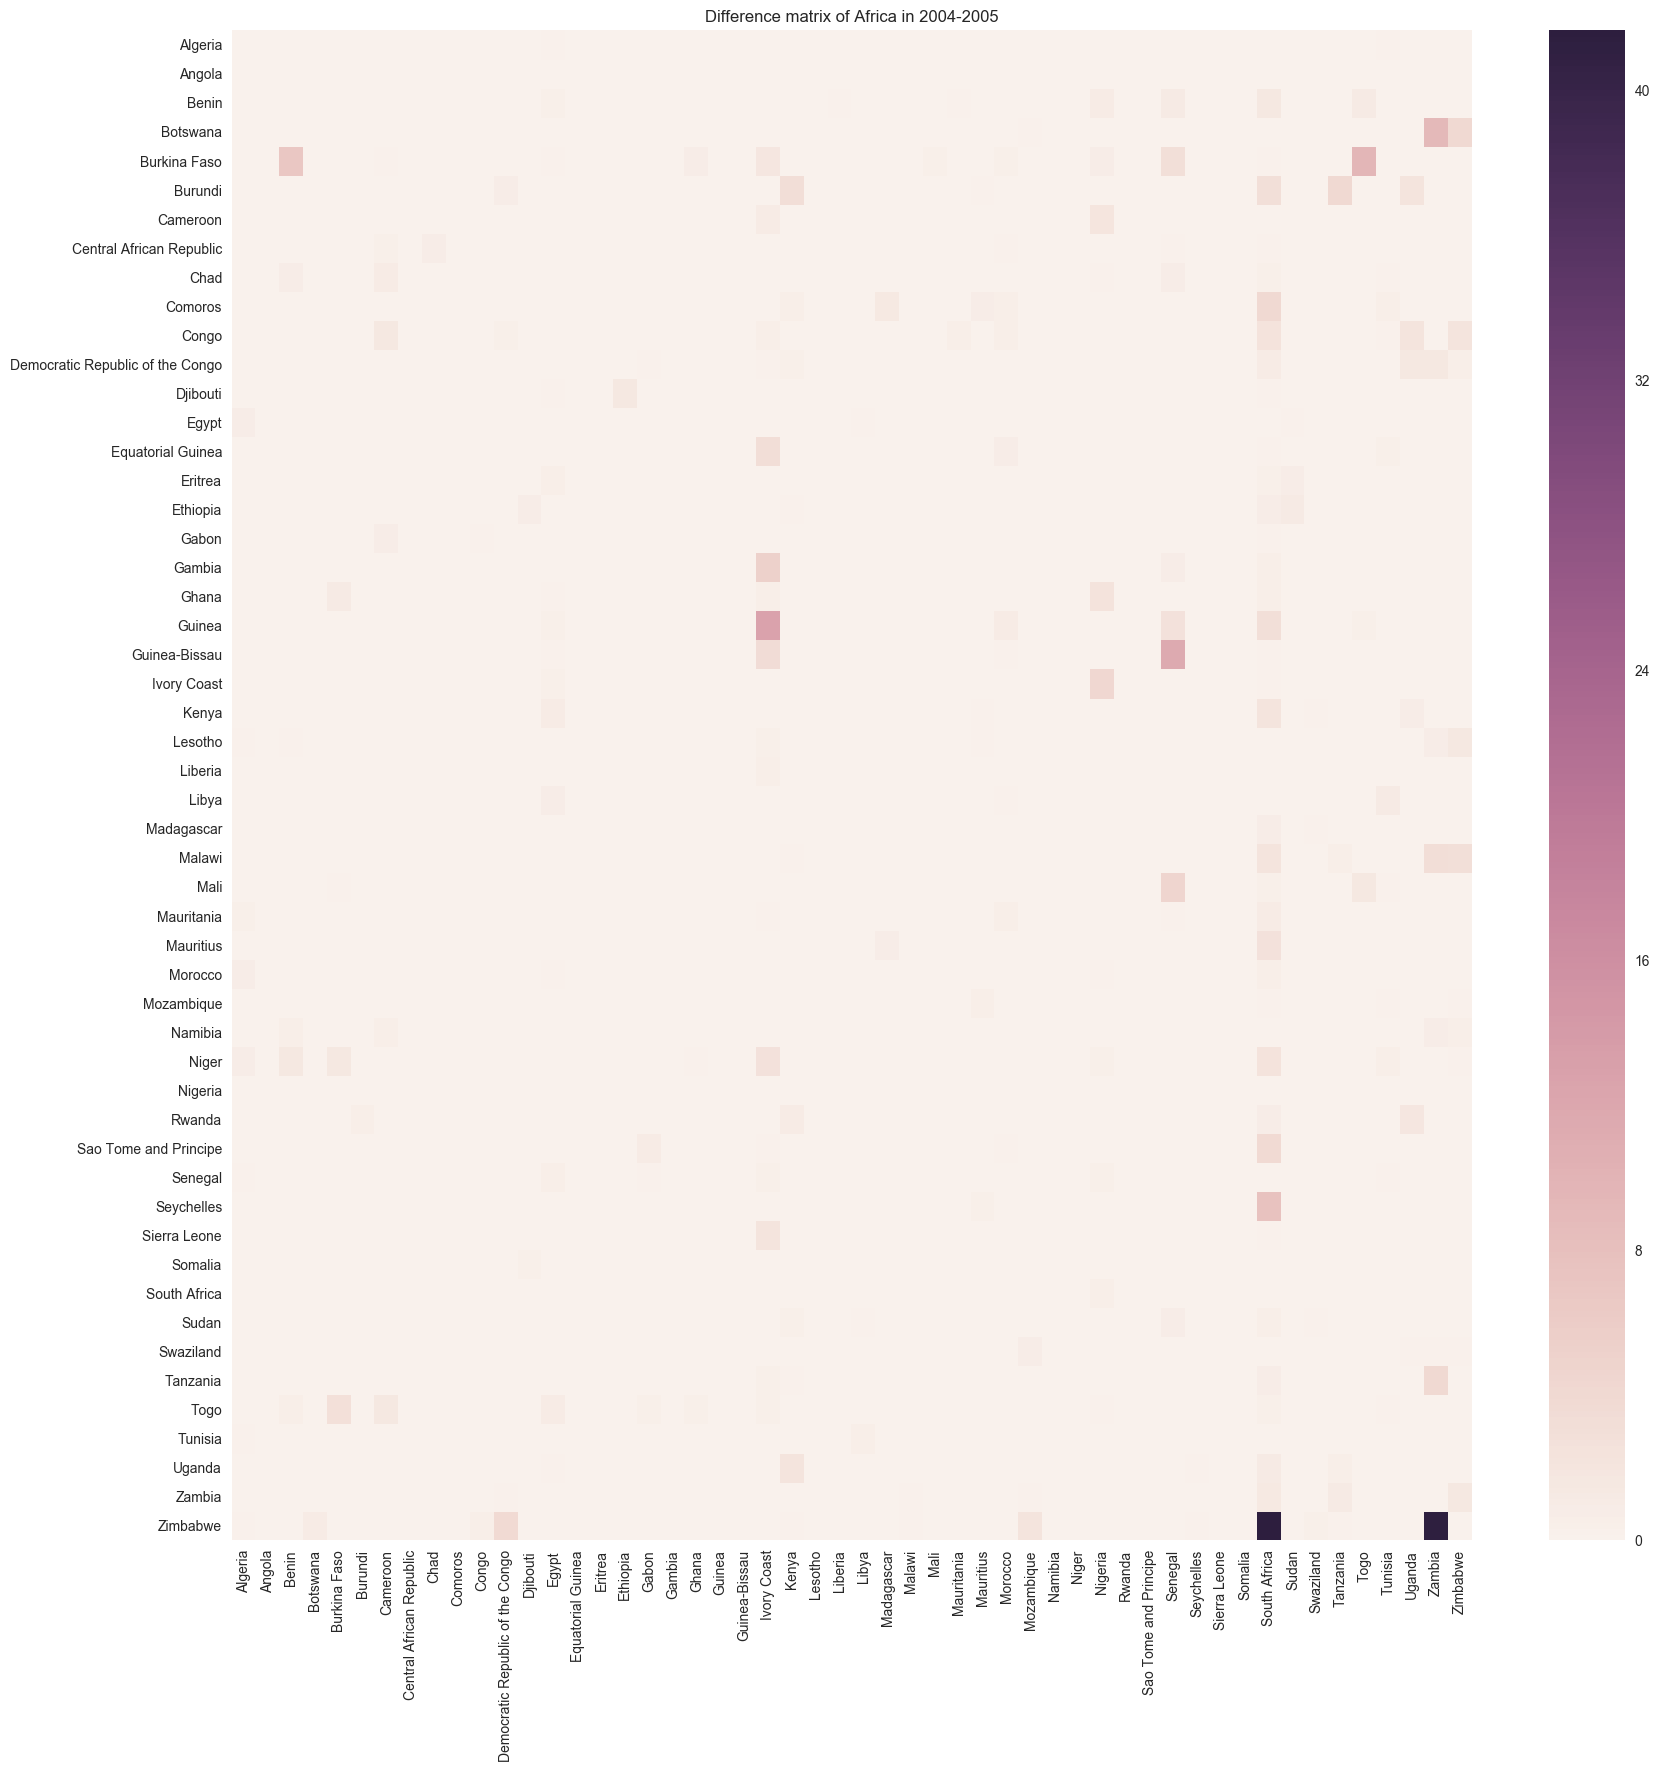

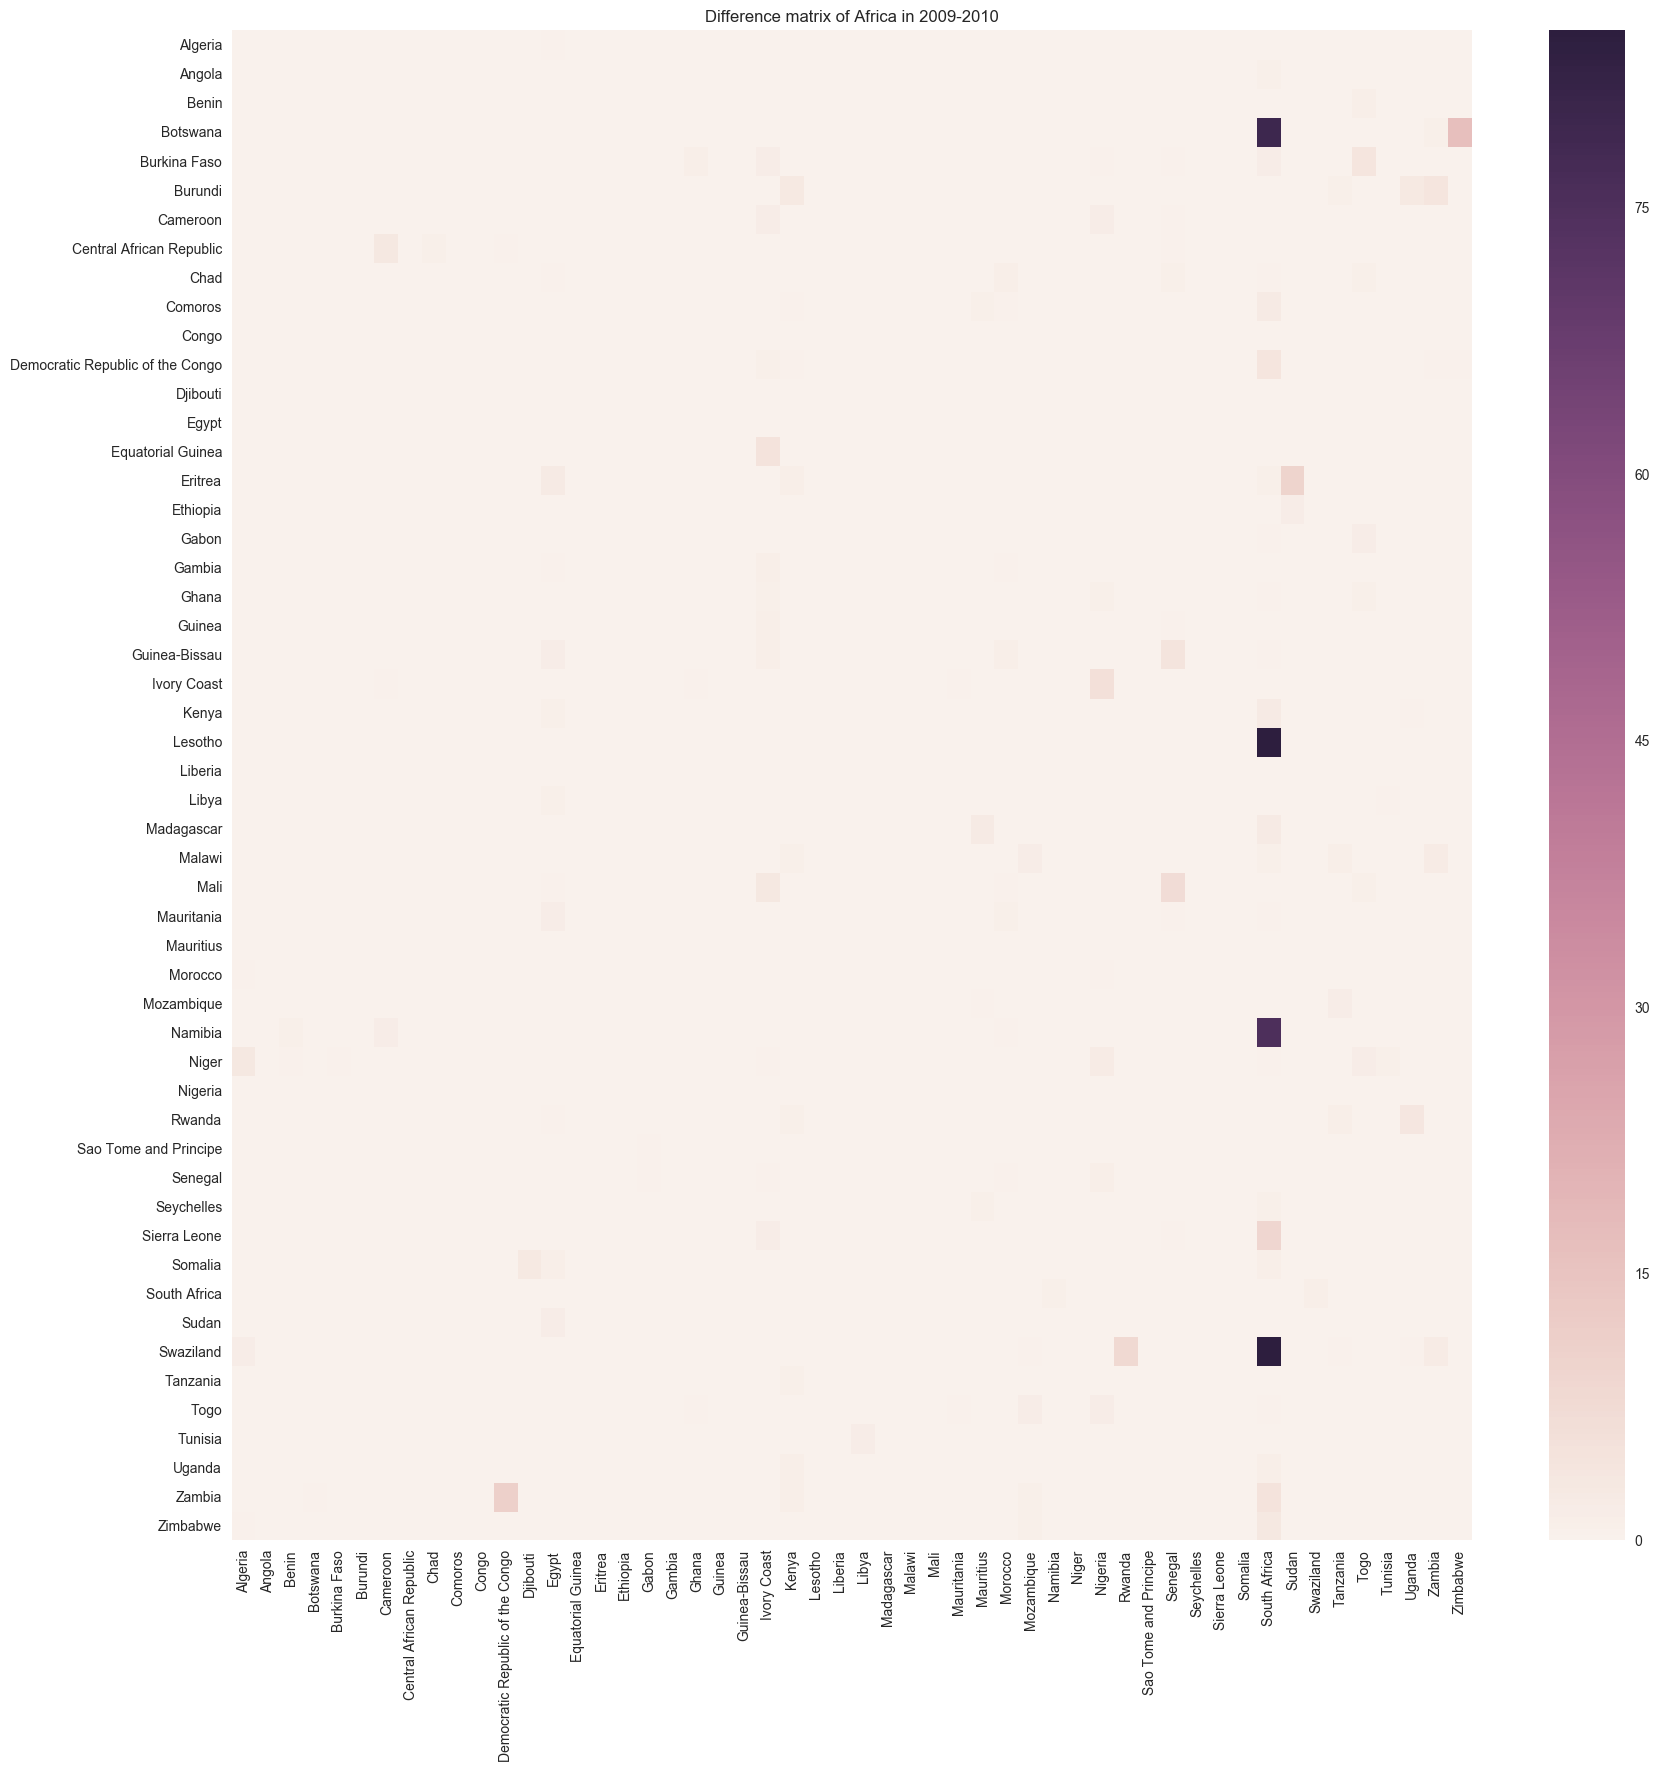

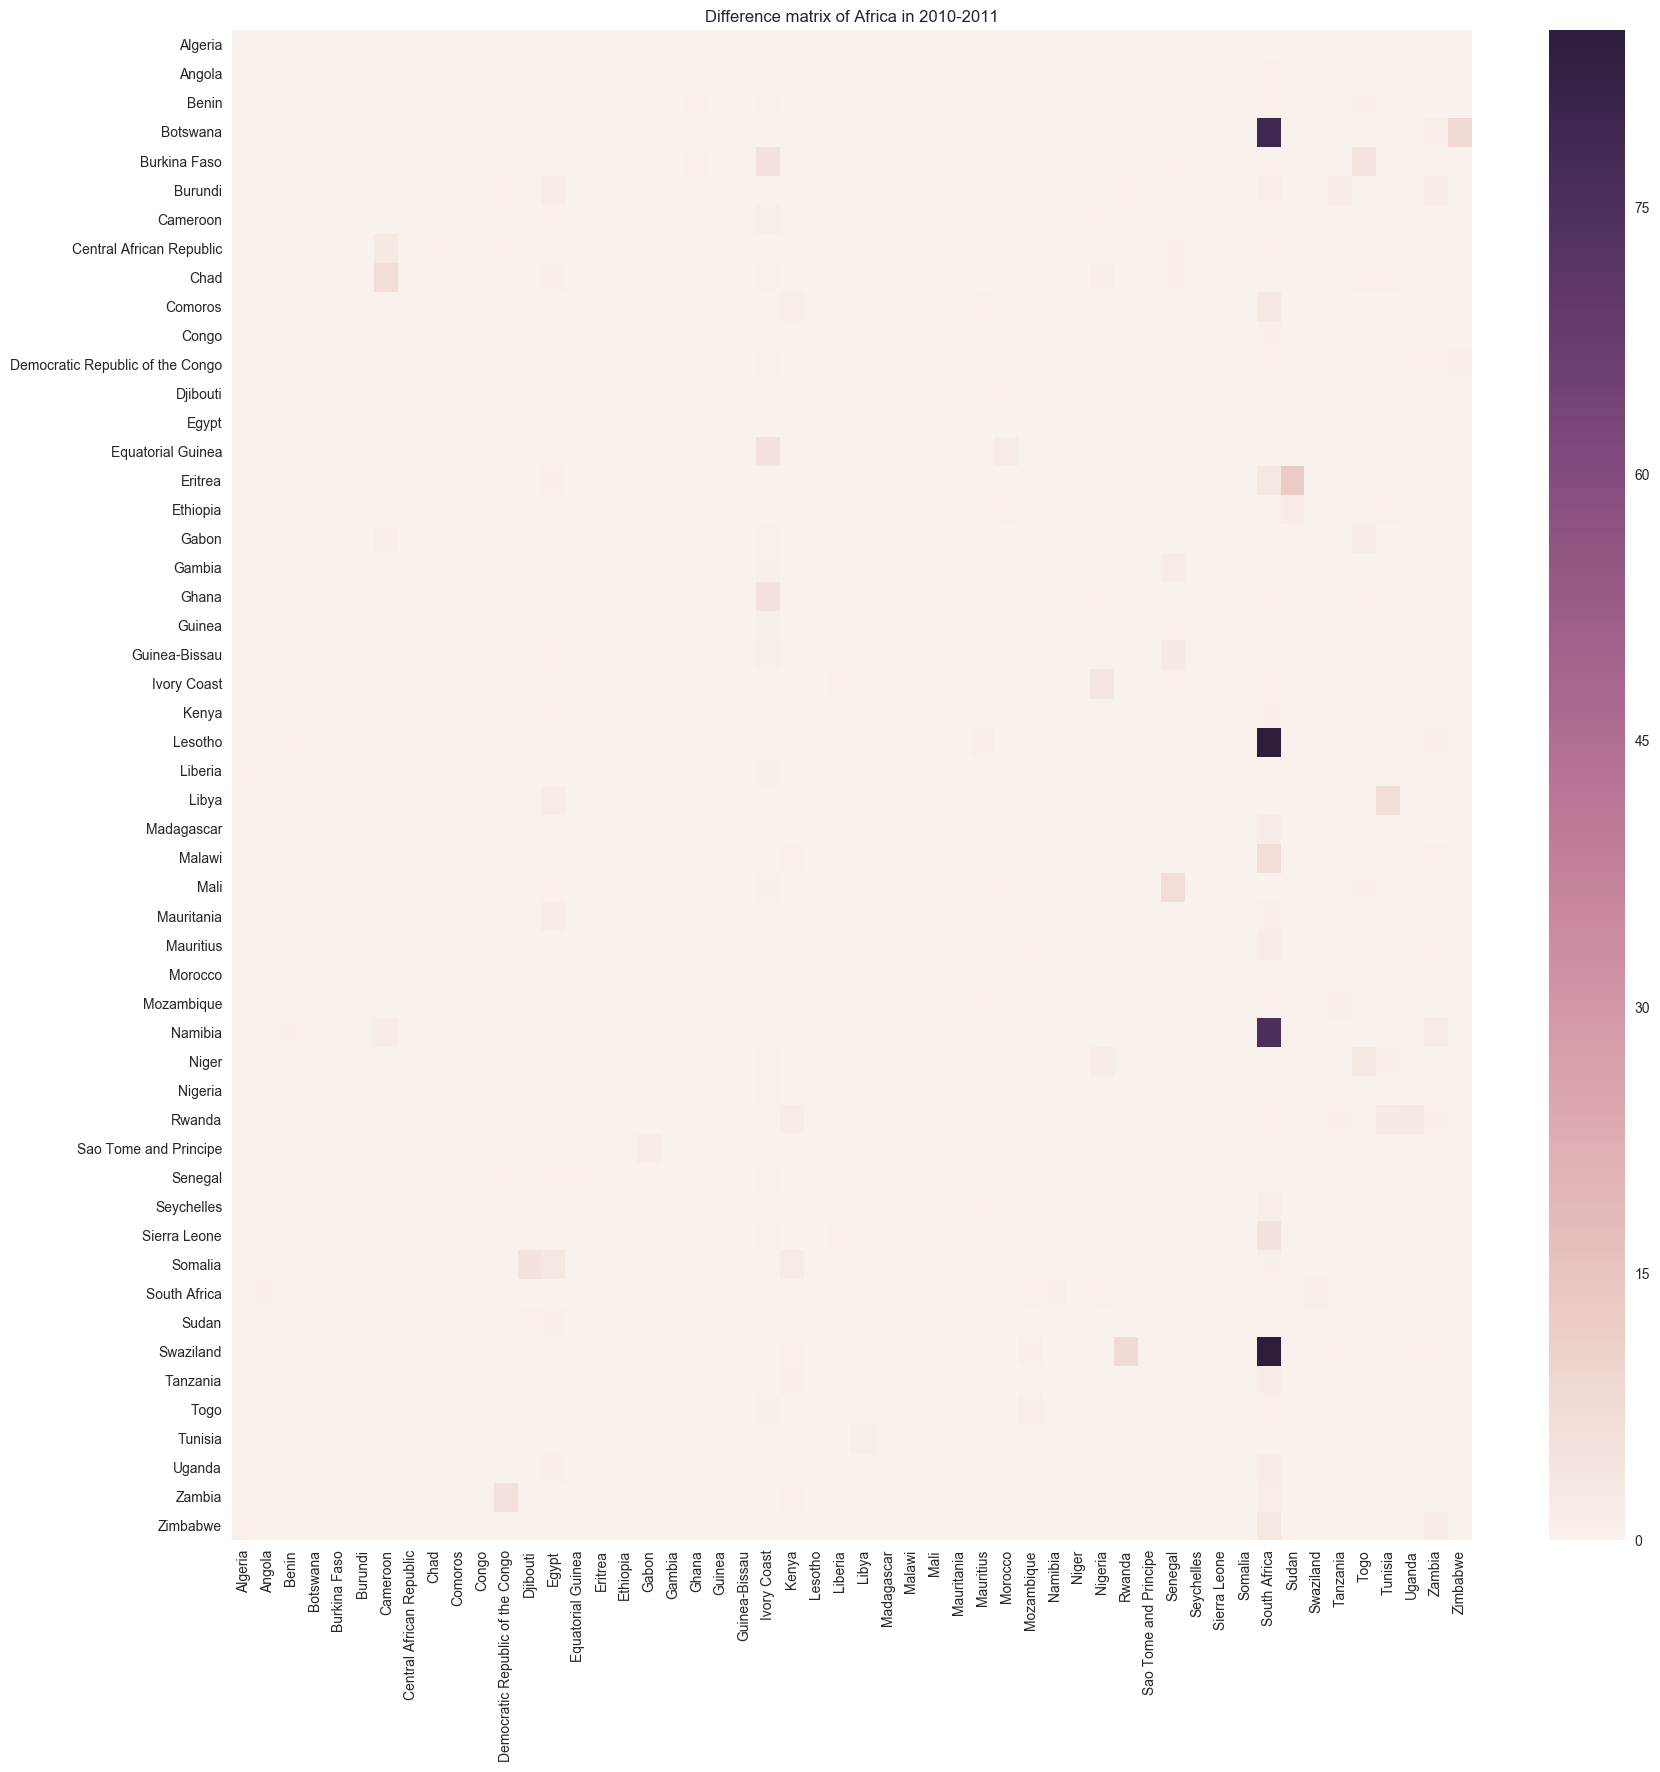

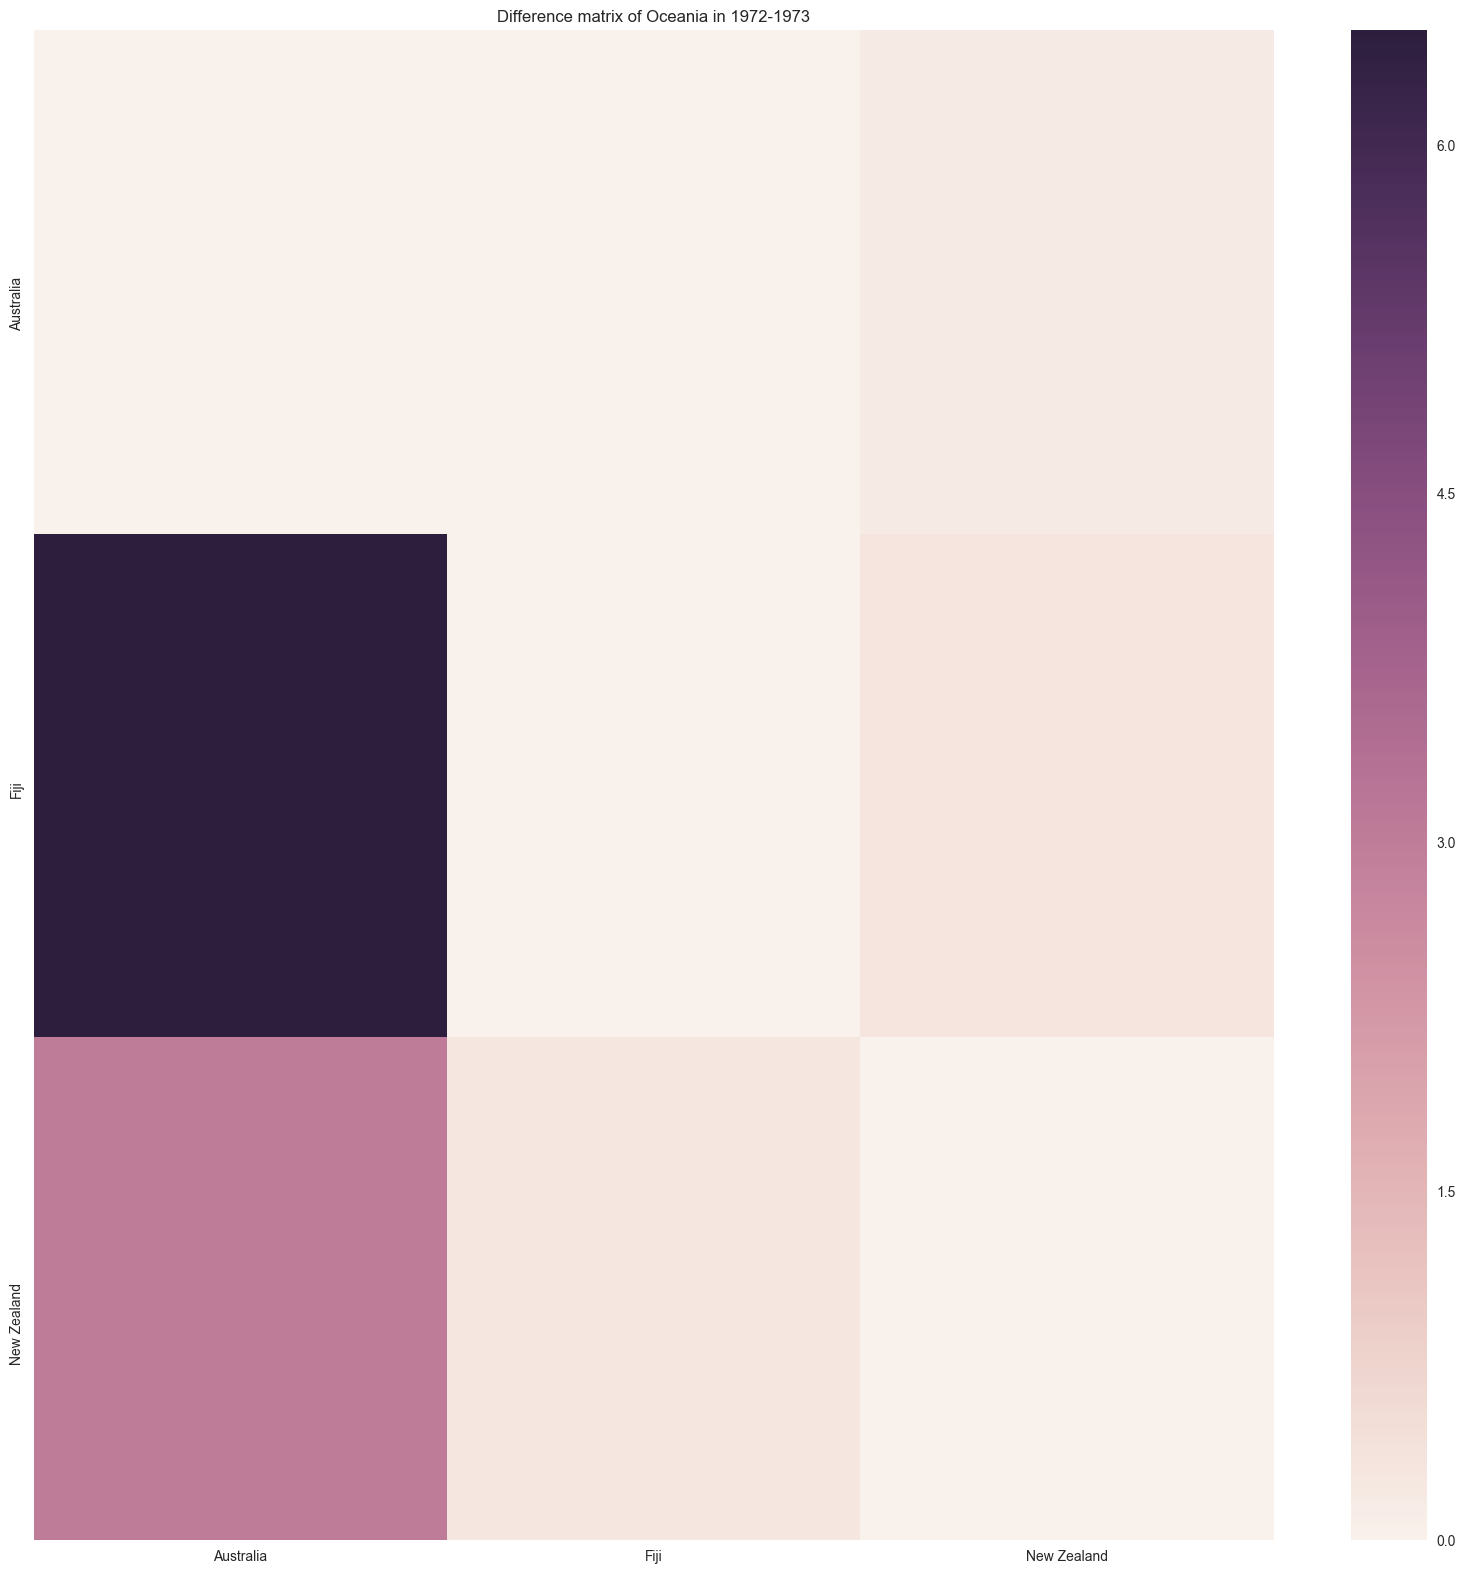

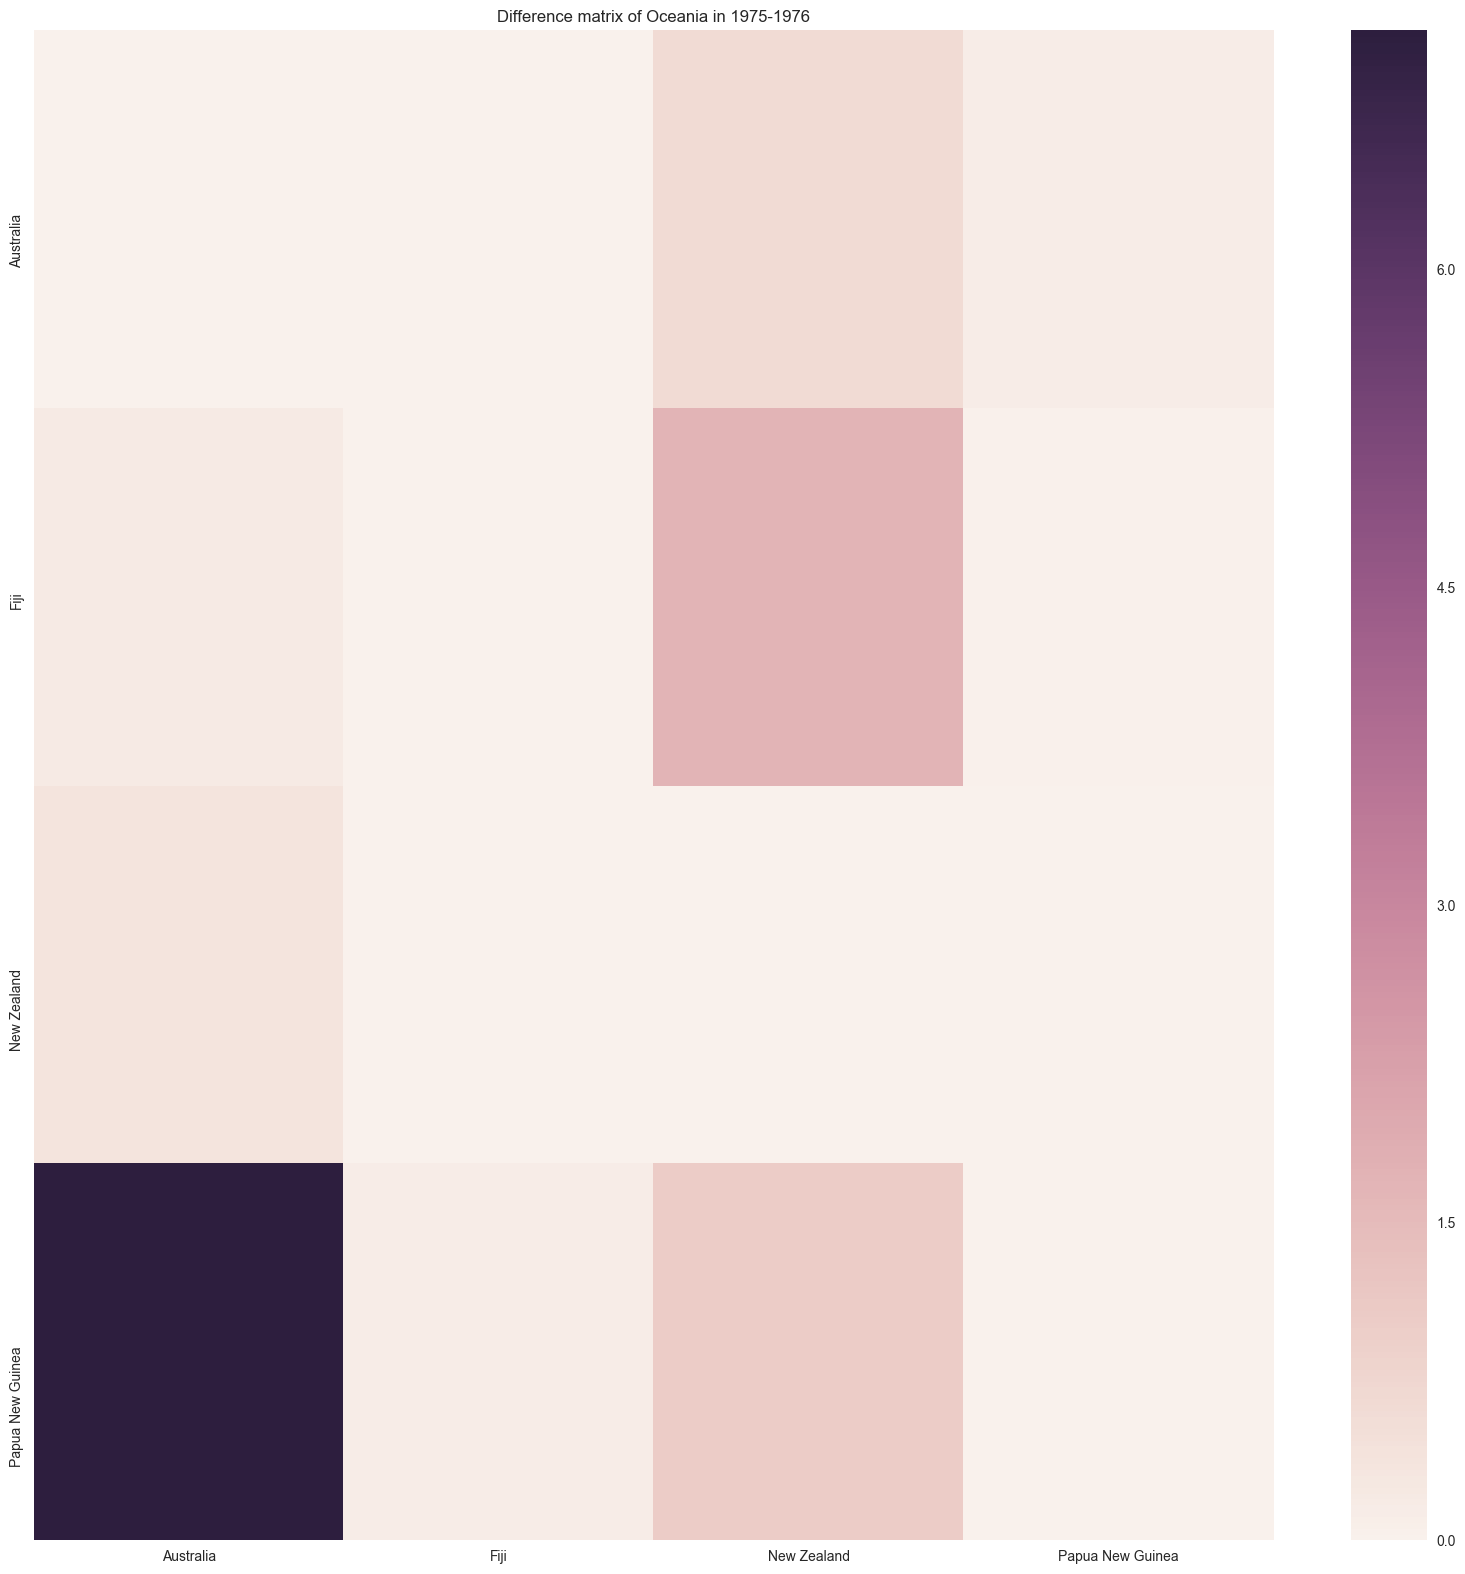

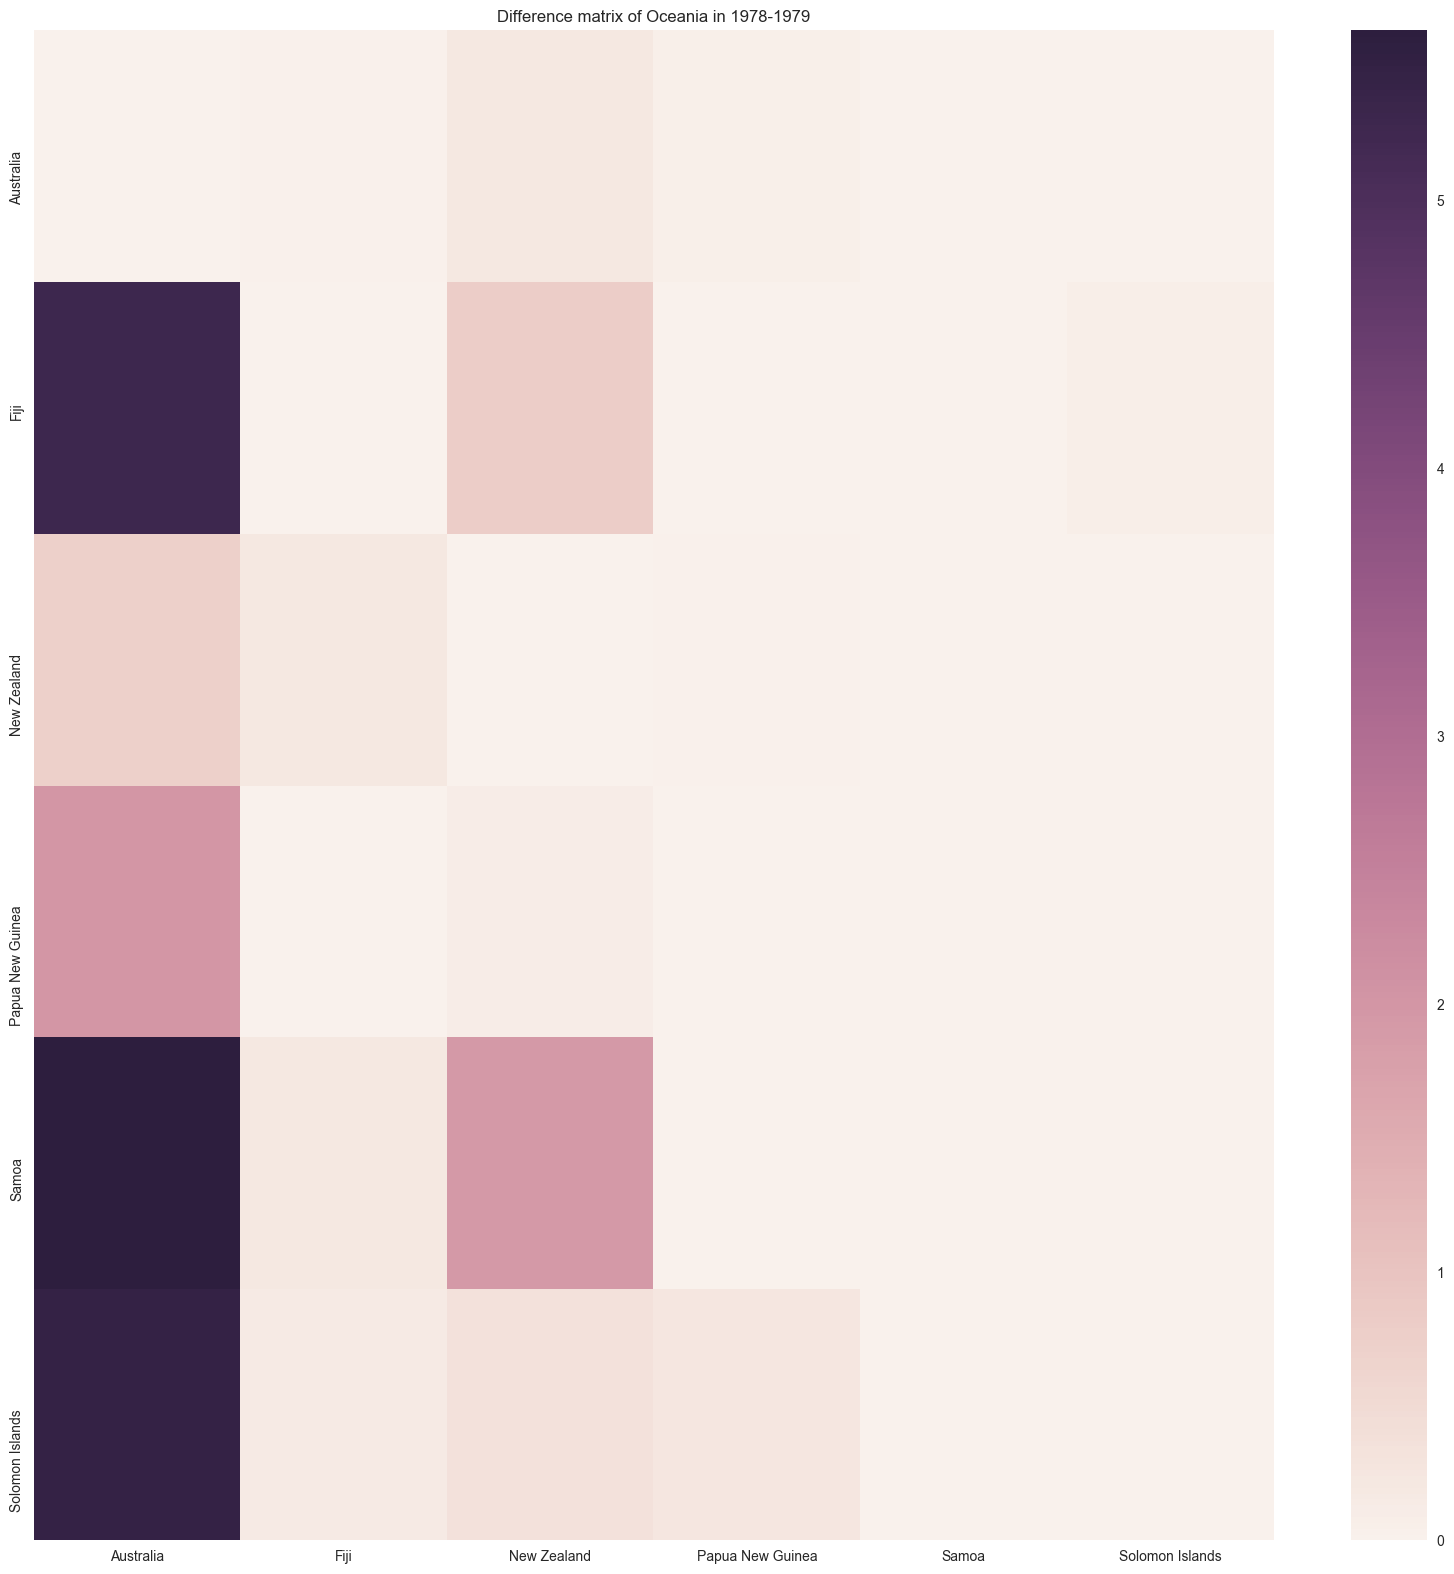

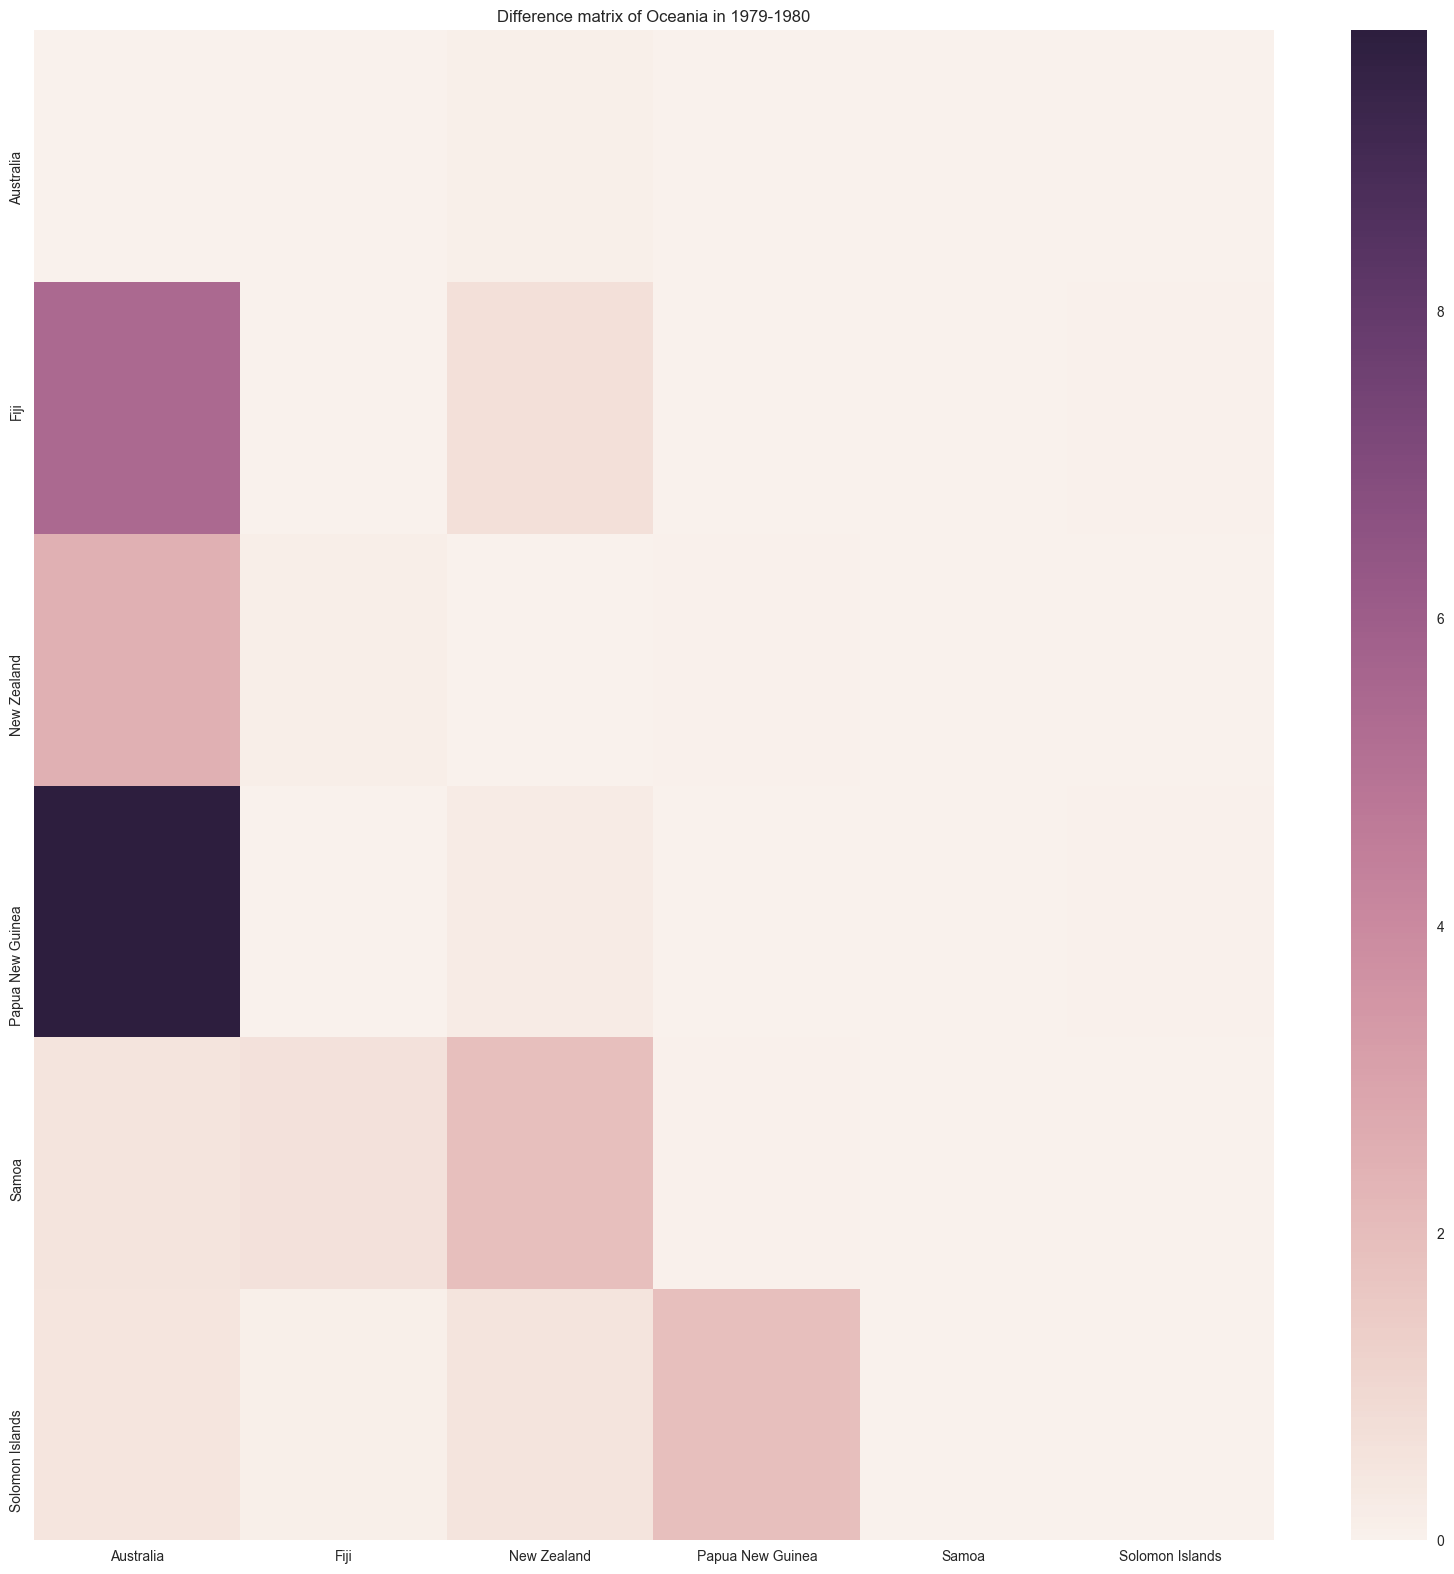

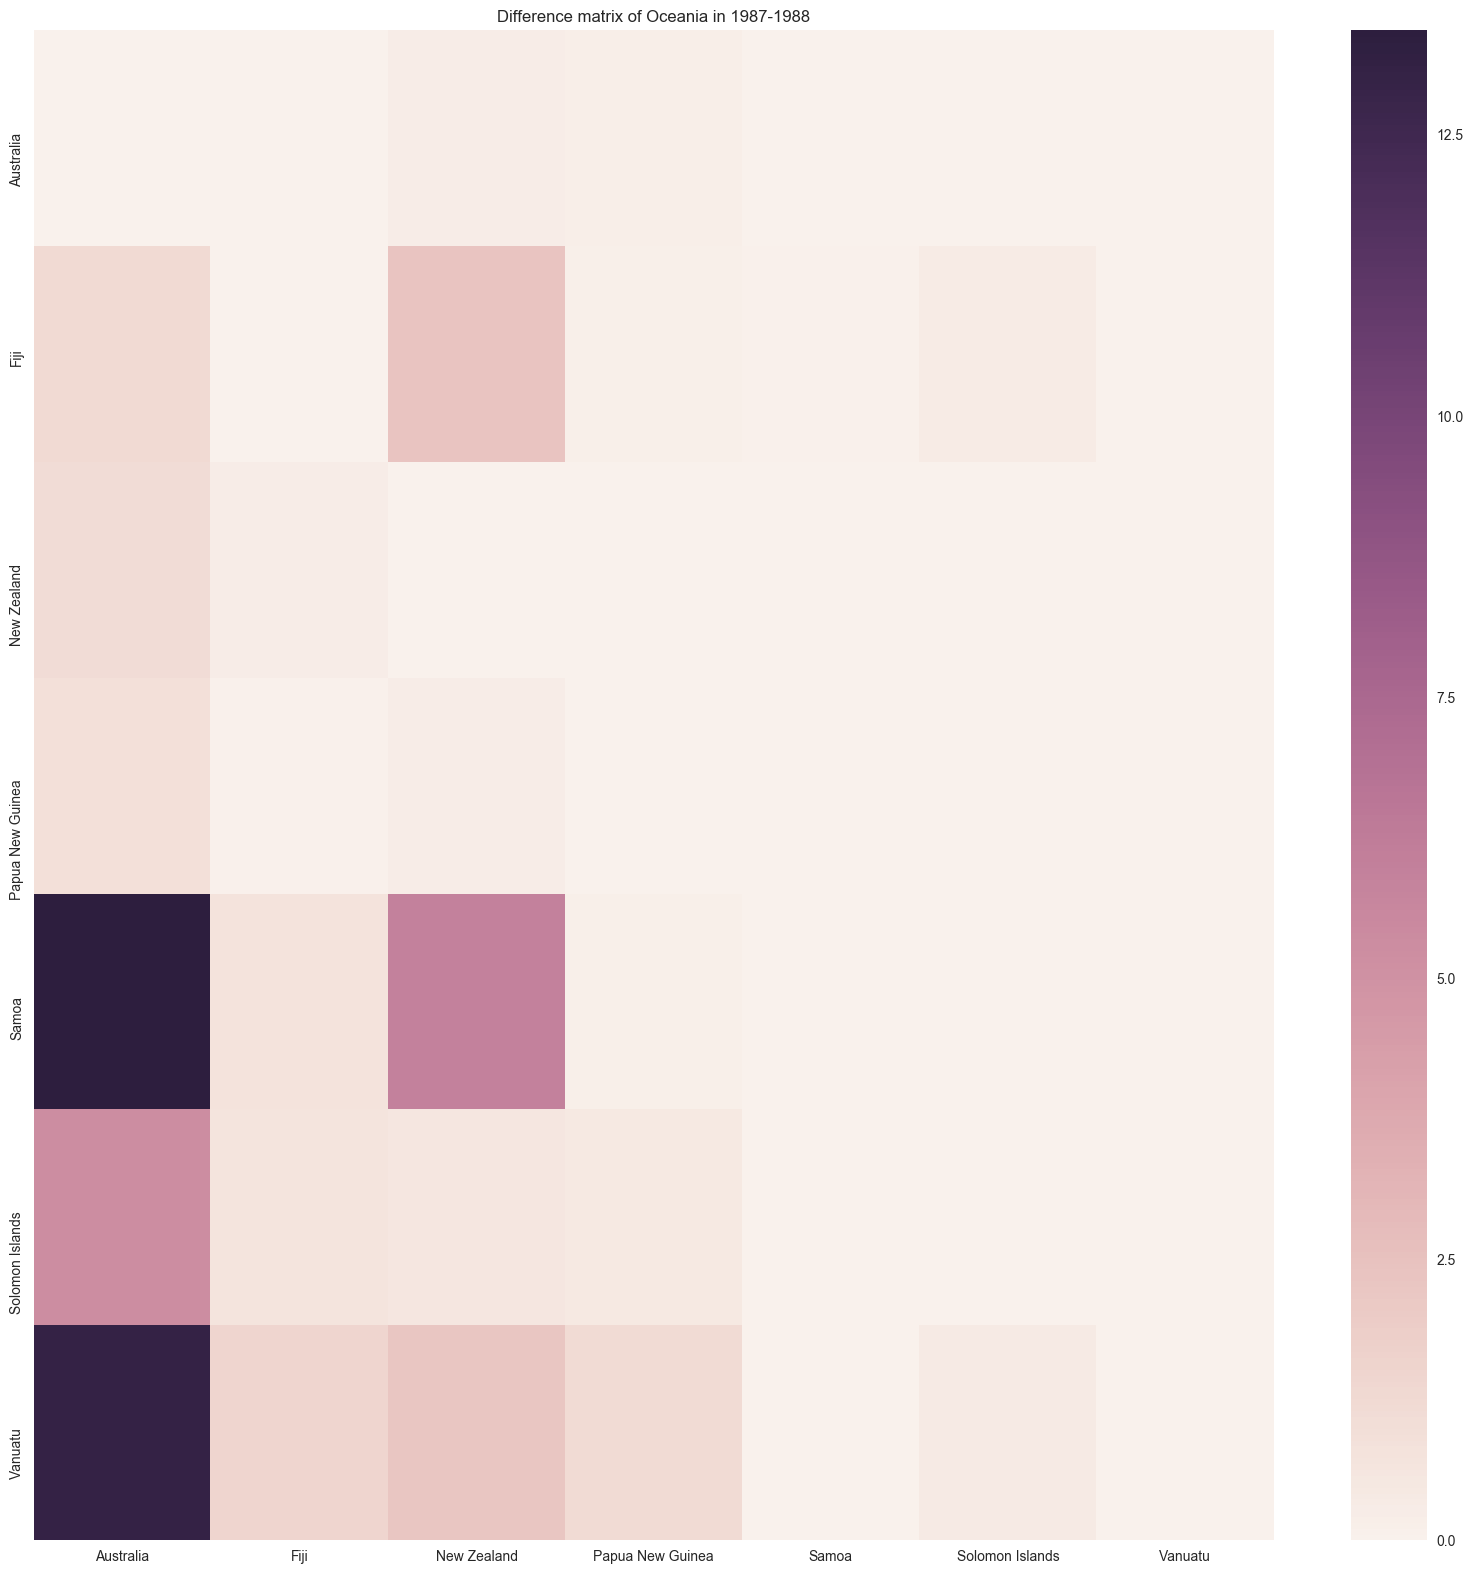

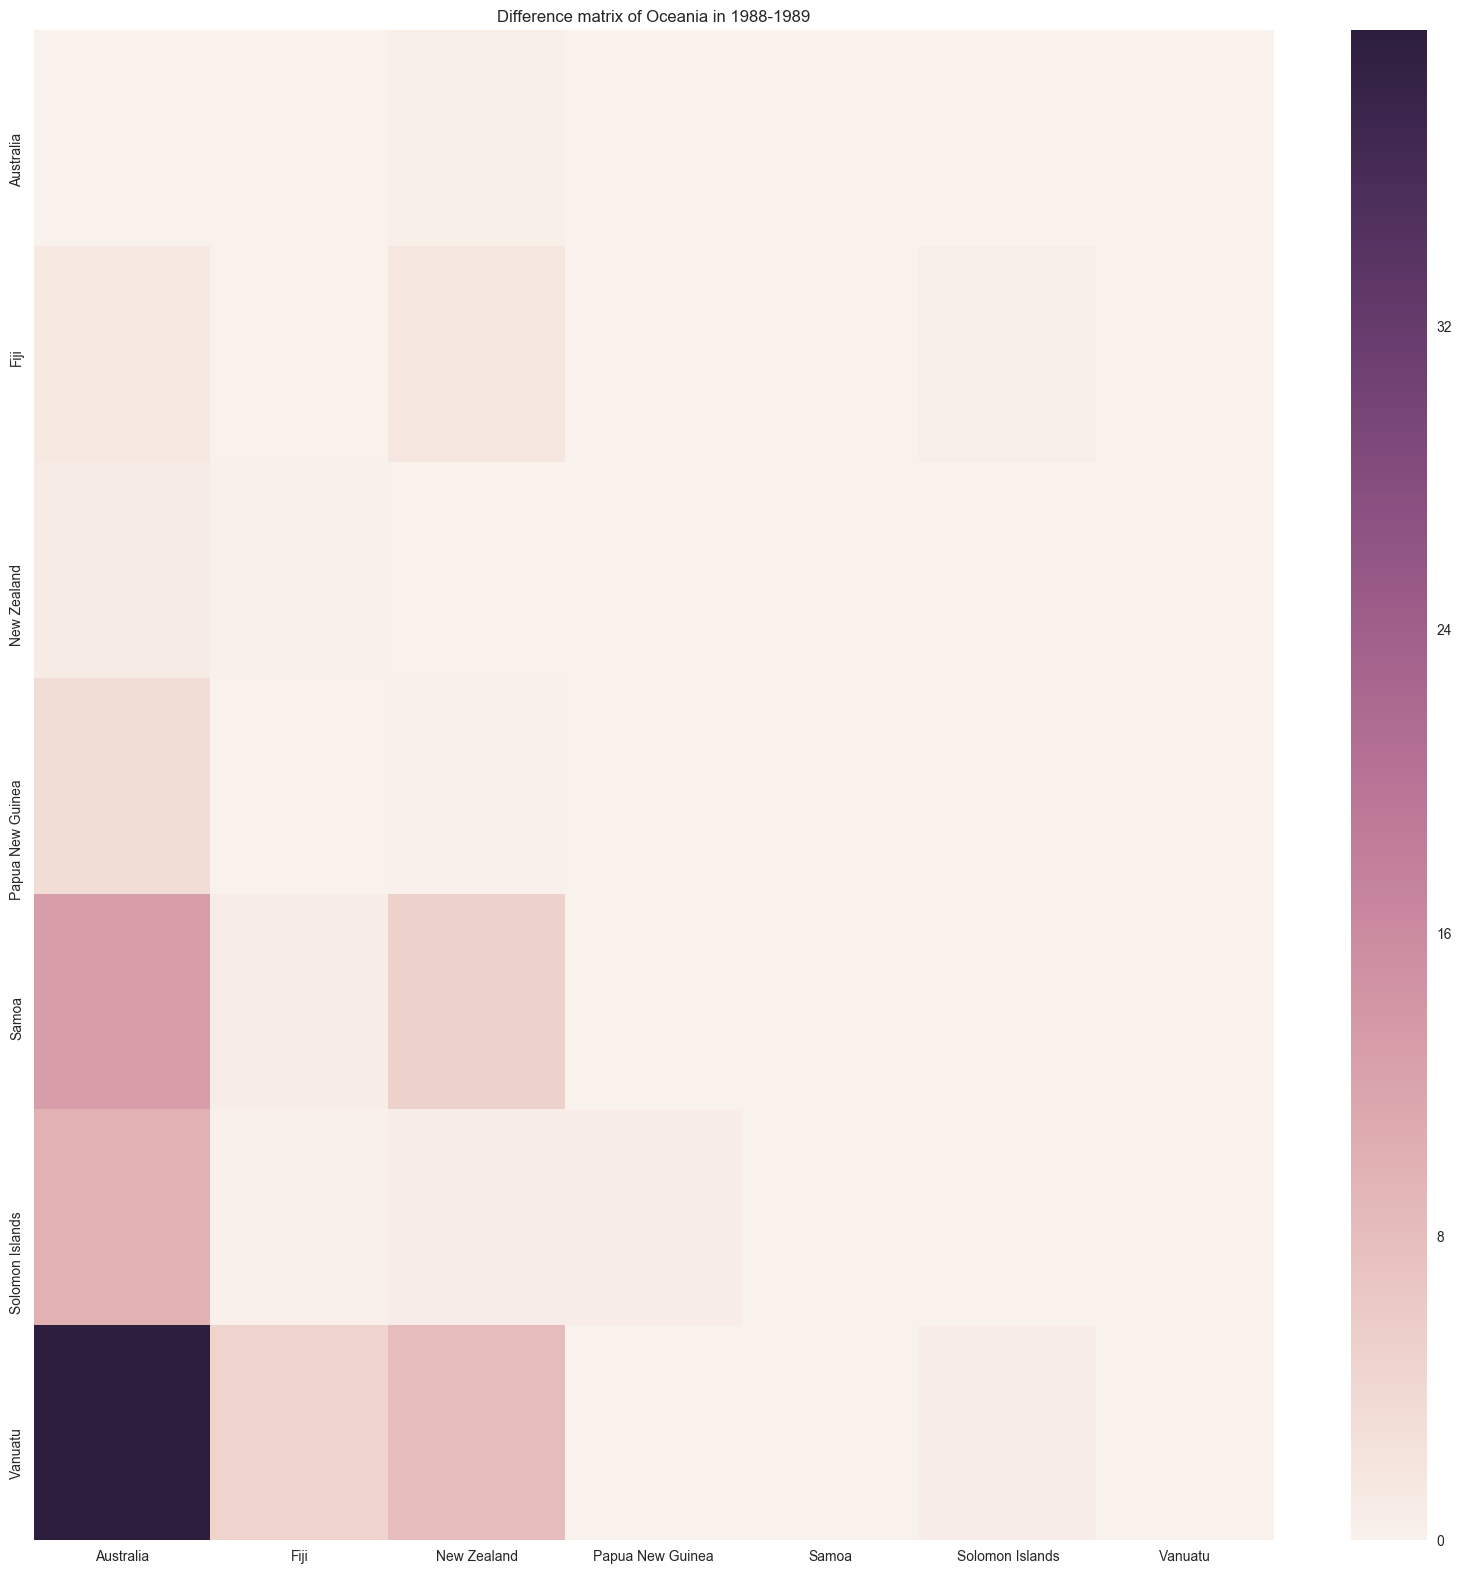

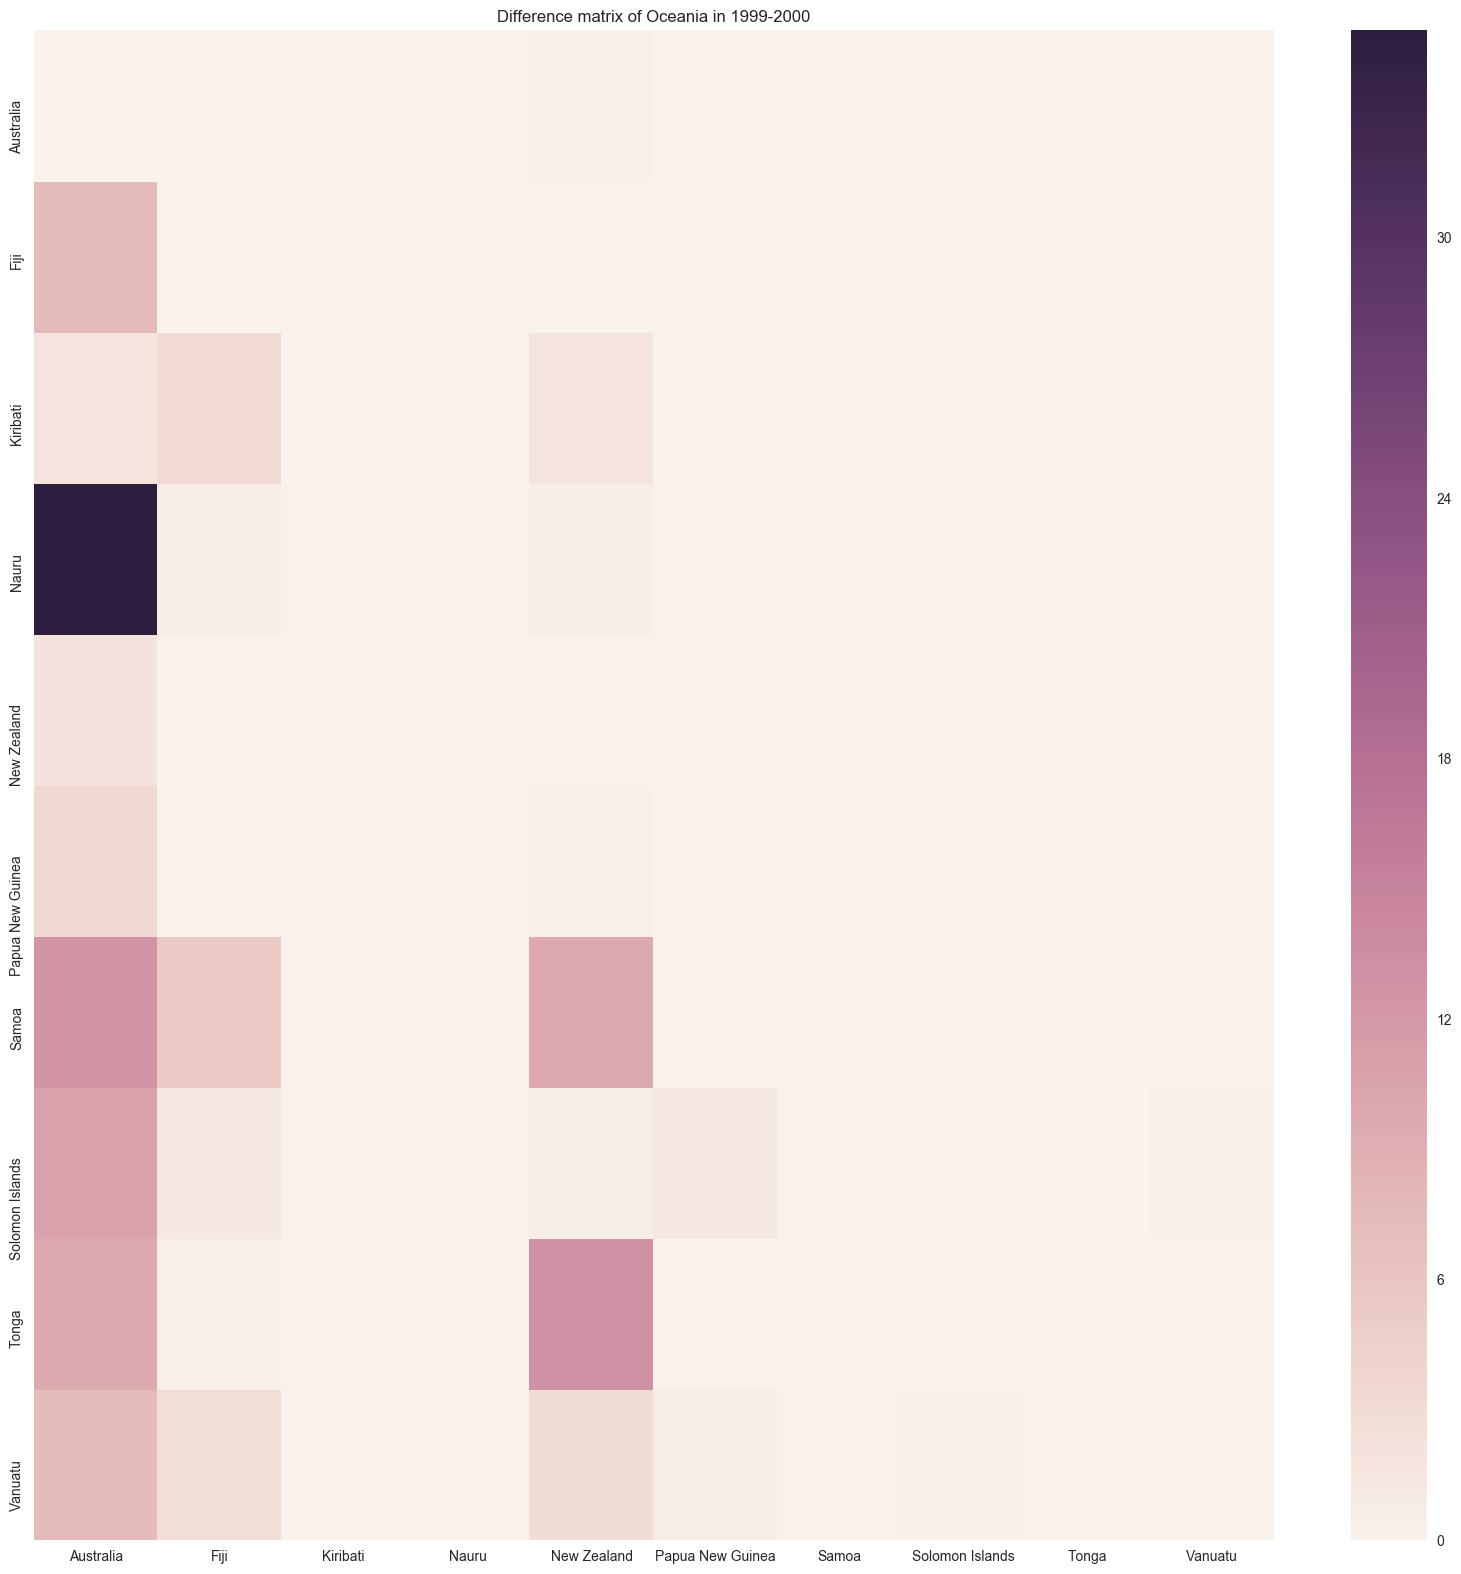

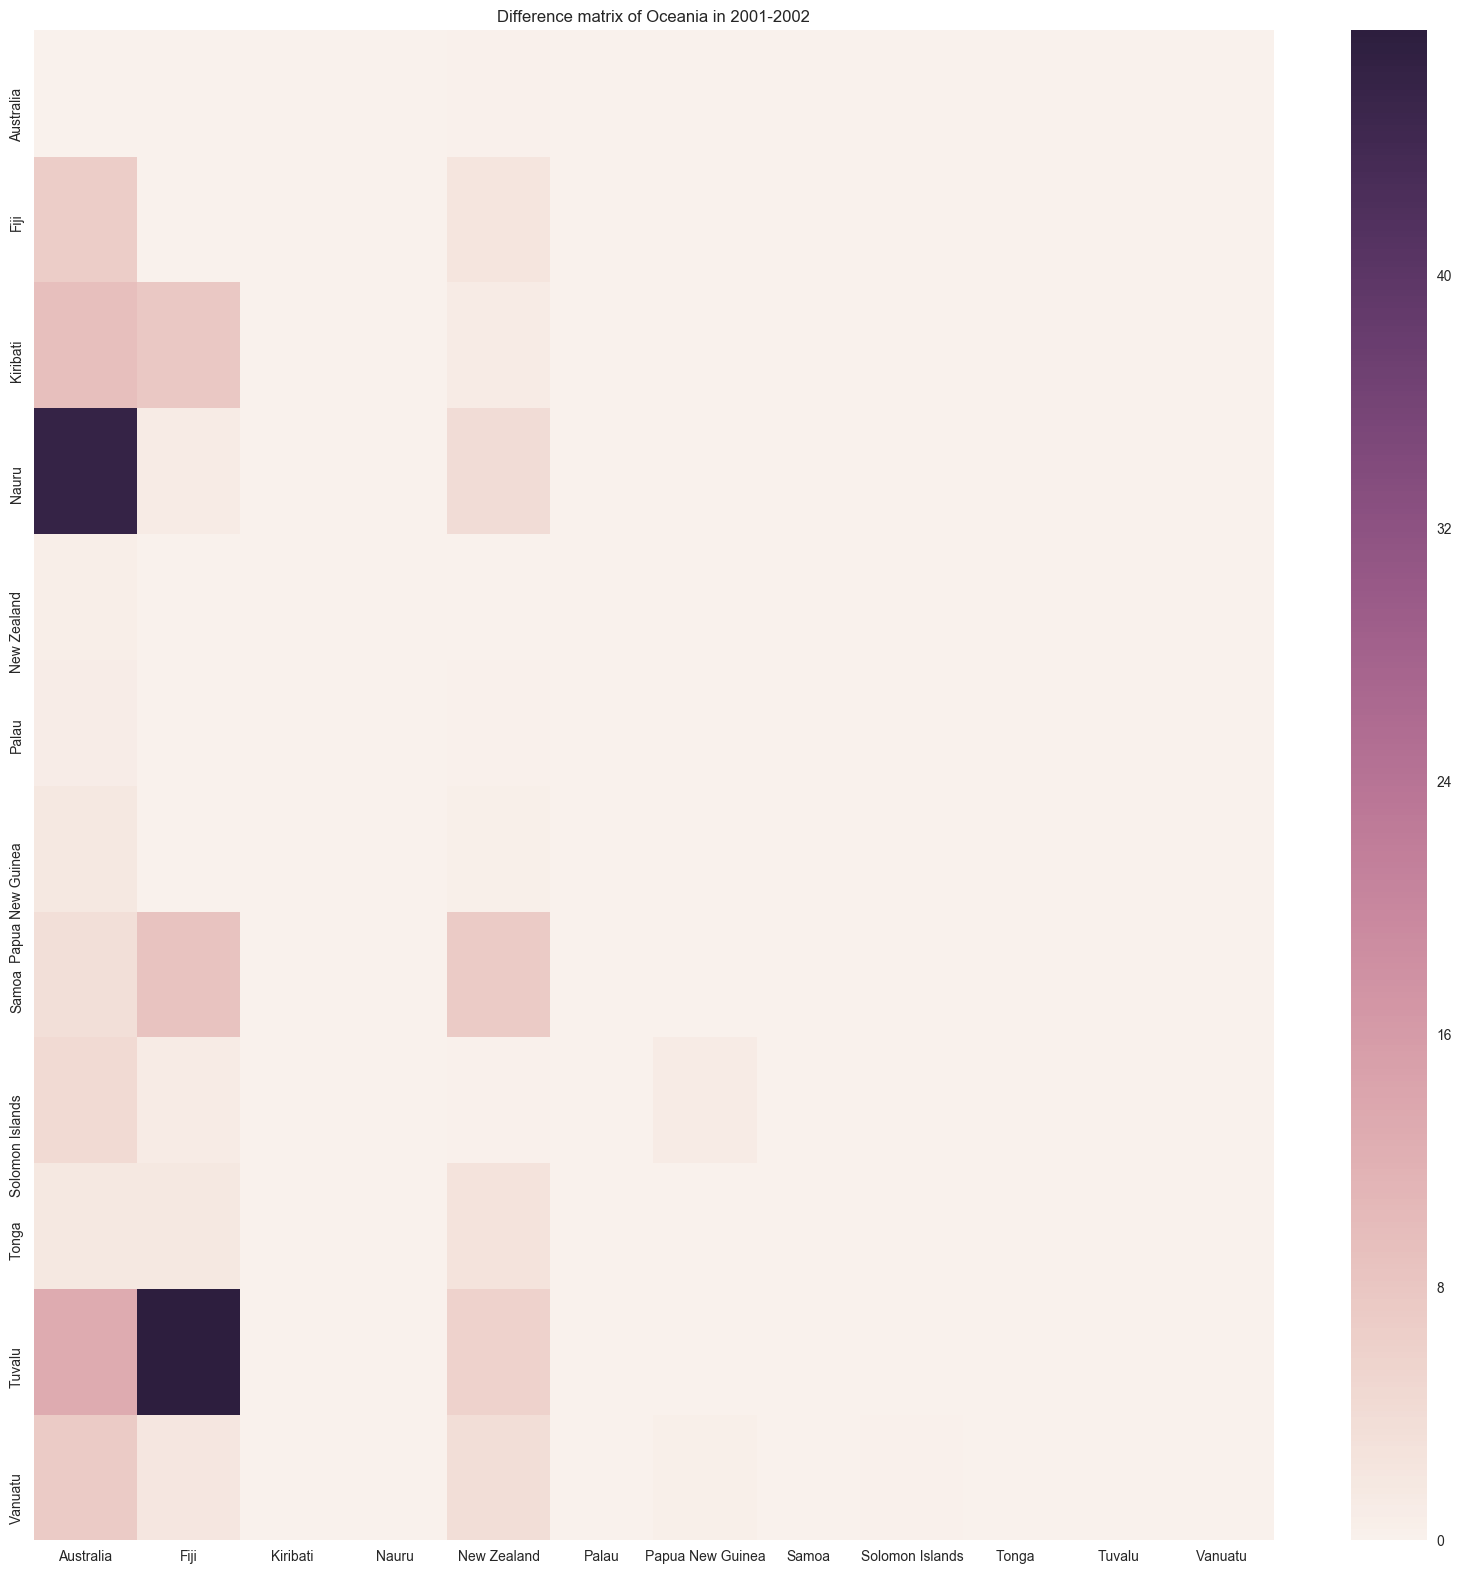

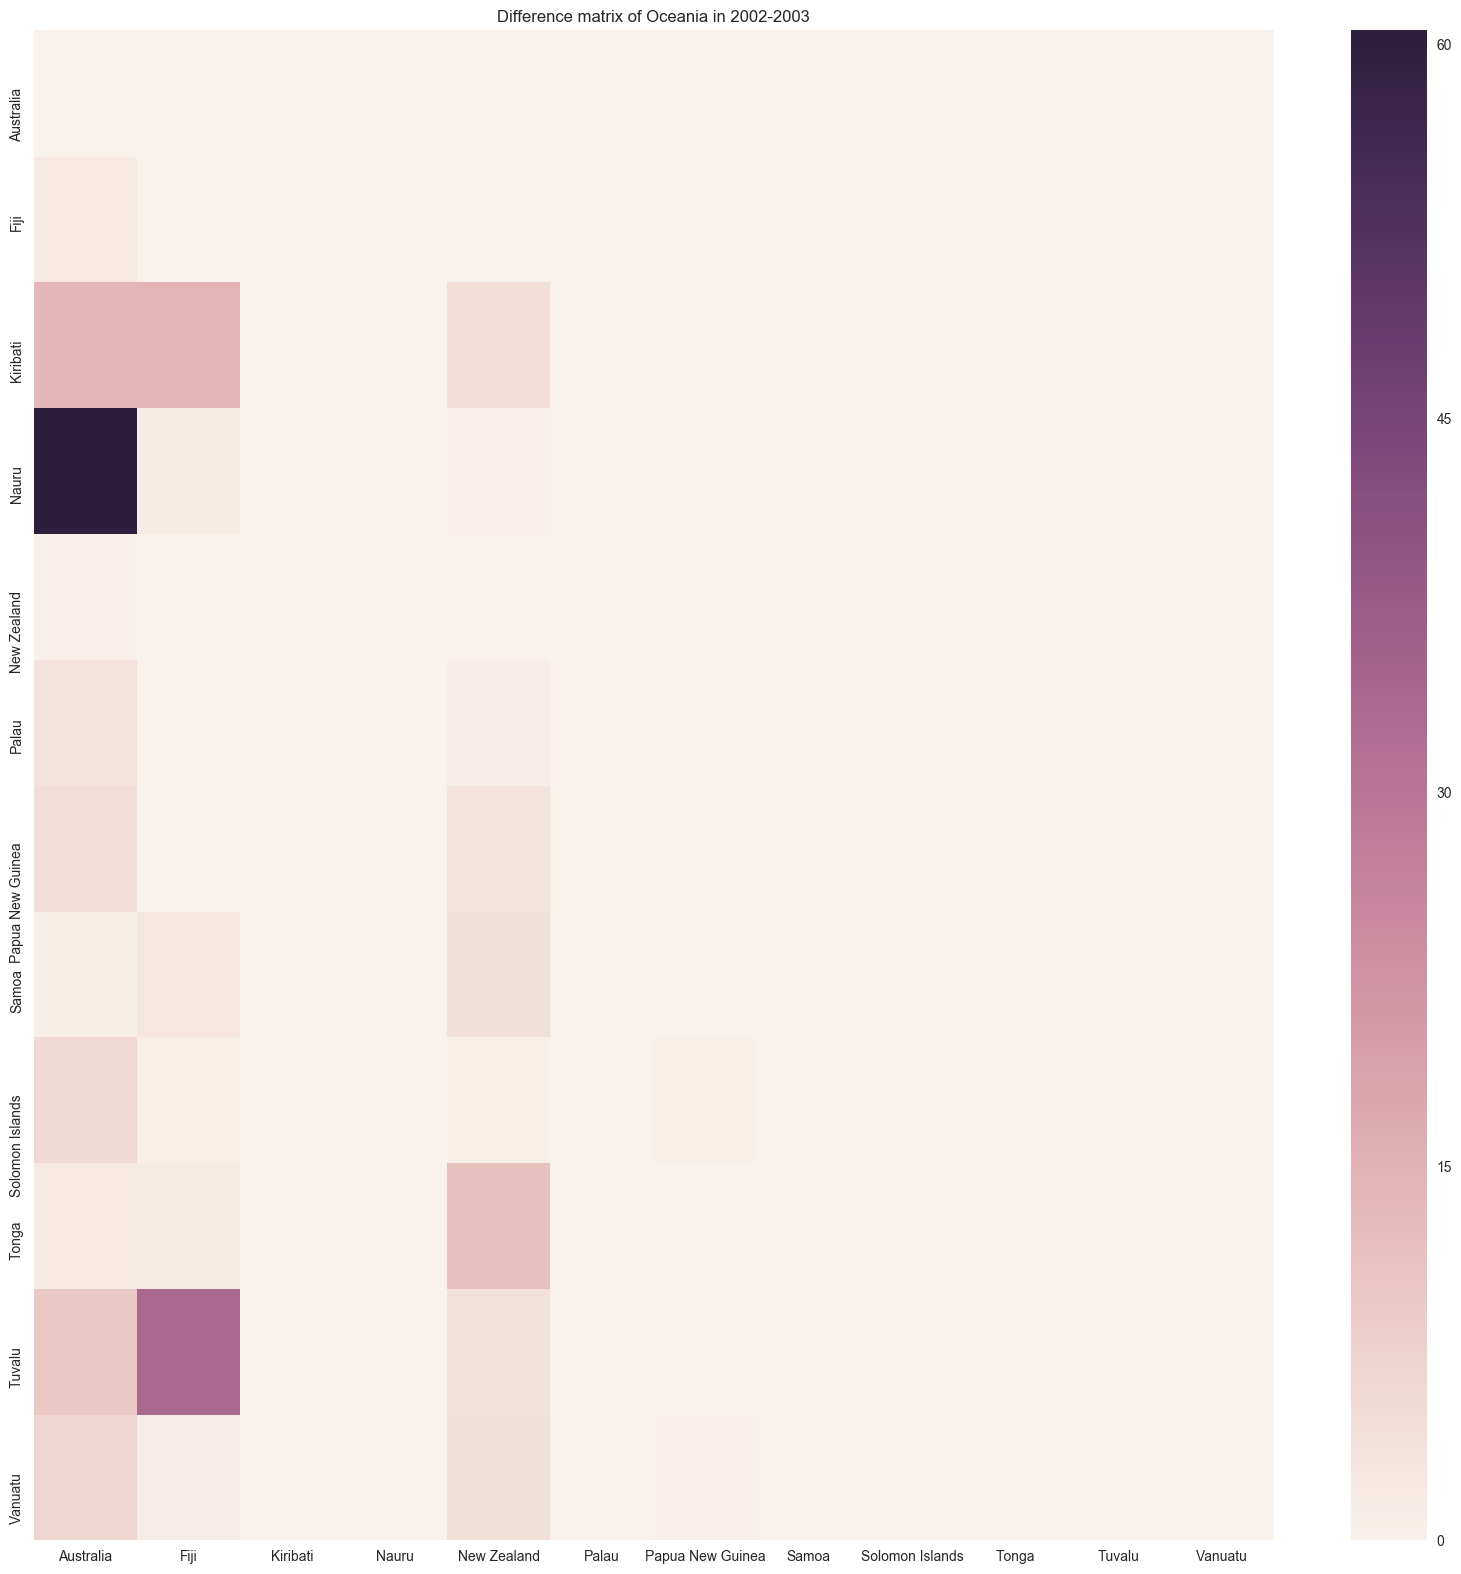

In [24]:
for data in df_sub_cont:
    continent = data.continent.unique()[0]
    years_pic = pics[continent][0]
    for k in years_pic:
        loc = np.where(np.array(years)==k)[0][0]
        mat_1 = list_intensity_matrix[continent][loc]
        mat_2 = list_intensity_matrix[continent][loc+1]
        aligned_mat_1 = mat_1.align(mat_2, join='inner')[0].as_matrix()
        aligned_mat_2 = mat_1.align(mat_2, join='inner')[1].as_matrix()
        plt.figure(figsize=(20,20))
        sns.heatmap(abs(aligned_mat_1-aligned_mat_2), xticklabels = list_intensity_matrix_col[continent][loc],
                   yticklabels = list_intensity_matrix_index[continent][loc])
        plt.title('Difference matrix of {} in {}-{}'.format(continent, k, k+1))
        plt.show()

__Explanation African spike__

Le pic en Afrique entre 2009 et 2010 est dû à 4 pays d'Afrique qui se sont mis à beaucoup commercer avec l'Afrique du Sud. Ces 4 pays sont le Botswana, le Lesotho, la Namibia et le Swaziland. Avec l'Afrique du Sud, ces 5 pays forment l'Union douanière d'Afrique australe (Southern African Custom Union (SACU) en anglais). Nous pouvons donc penser qu'un accord au sein de cette union pourrait être à l'initiative de ce changement.

/Users/Linger/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



Text(0.7,0,'Exporter')

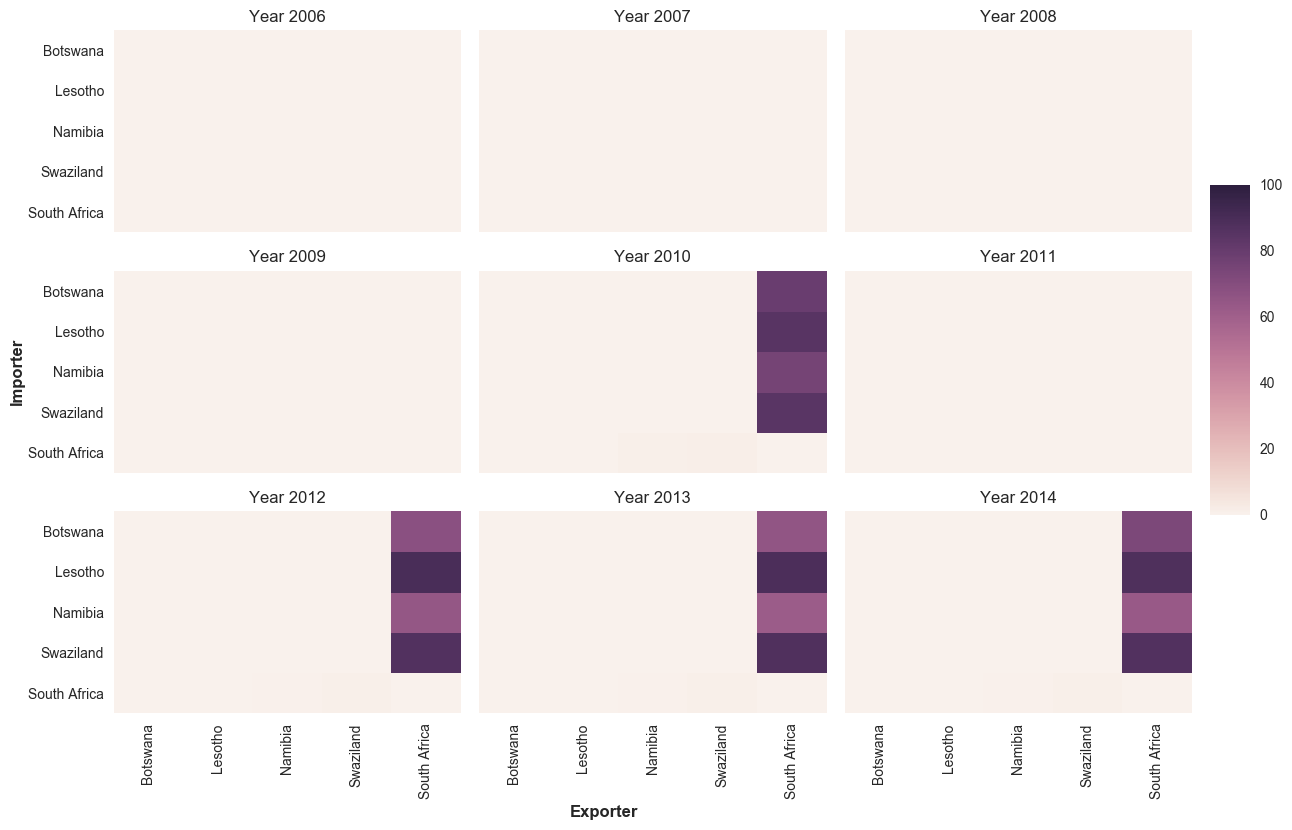

In [25]:
fig,axn = plt.subplots(3, 3, sharex=True, sharey=True)

ax = axn.flat
cbar_ax = fig.add_axes([1.5, .55, .05, .6])
    
for i, k in enumerate([l for l in range(2006,2015)]):
    loc = np.where(np.array(years)==k)[0][0]
    inter_df = list_intensity_matrix['Africa'][loc].loc[['Botswana', 'Lesotho', 'Namibia', 'Swaziland', 'South Africa'],
                                ['Botswana', 'Lesotho', 'Namibia', 'Swaziland', 'South Africa']]
    inter_df.columns.name = ''
    inter_df.index.name = ''
    sns.heatmap(inter_df, vmin=0, vmax=100, ax = ax[i], cbar=i == 0, cbar_ax=None if i else cbar_ax)
    ax[i].set_title('Year {}'.format(k))
    
fig.tight_layout(rect=[0, 0, 1.5, 1.5])
fig.text(0,.85,'Importer', rotation='vertical', weight = 'heavy')
fig.text(.7,0,'Exporter', weight = 'heavy')

The spikes around 2010 are explained by the fact that countries inside SACU started to report their exchanges between each others. Before, the 5 countries inside SECU didn't report their exchanges between each other.

___Explanation European spike in 1984-1985___

18.560505873537565


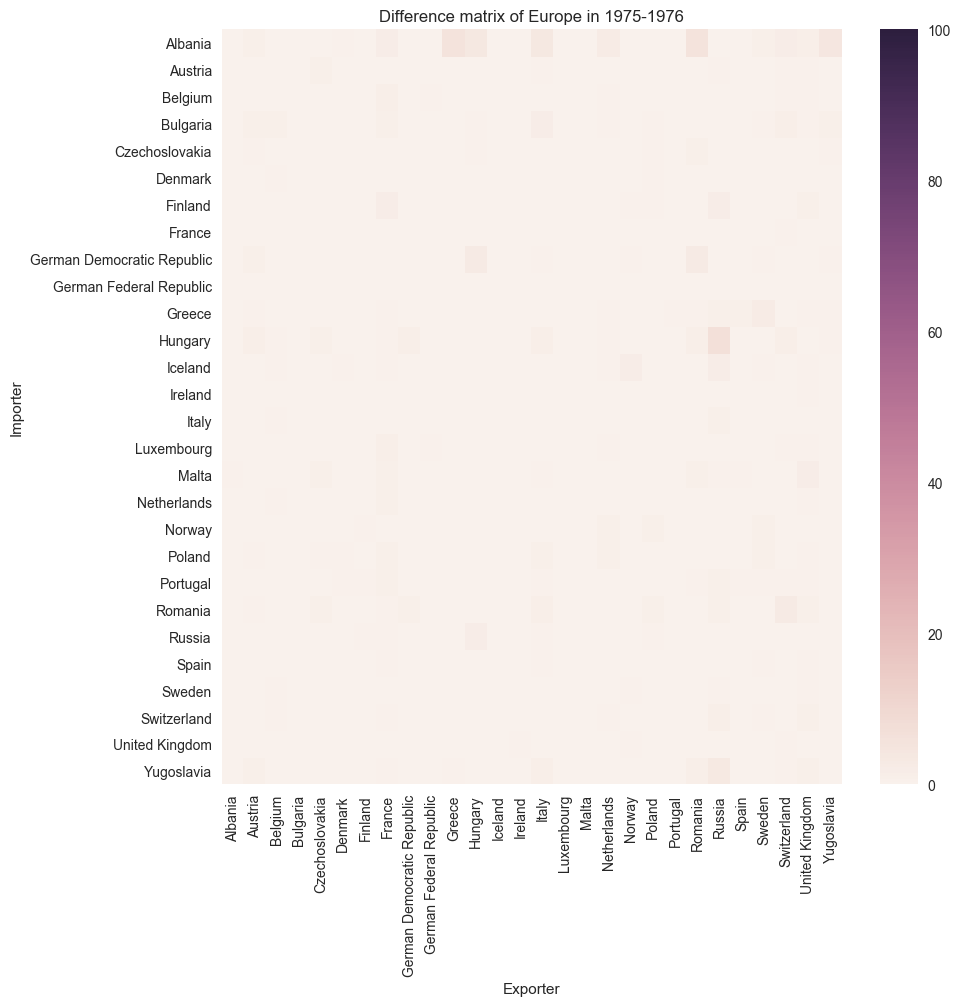

16.650510021975624


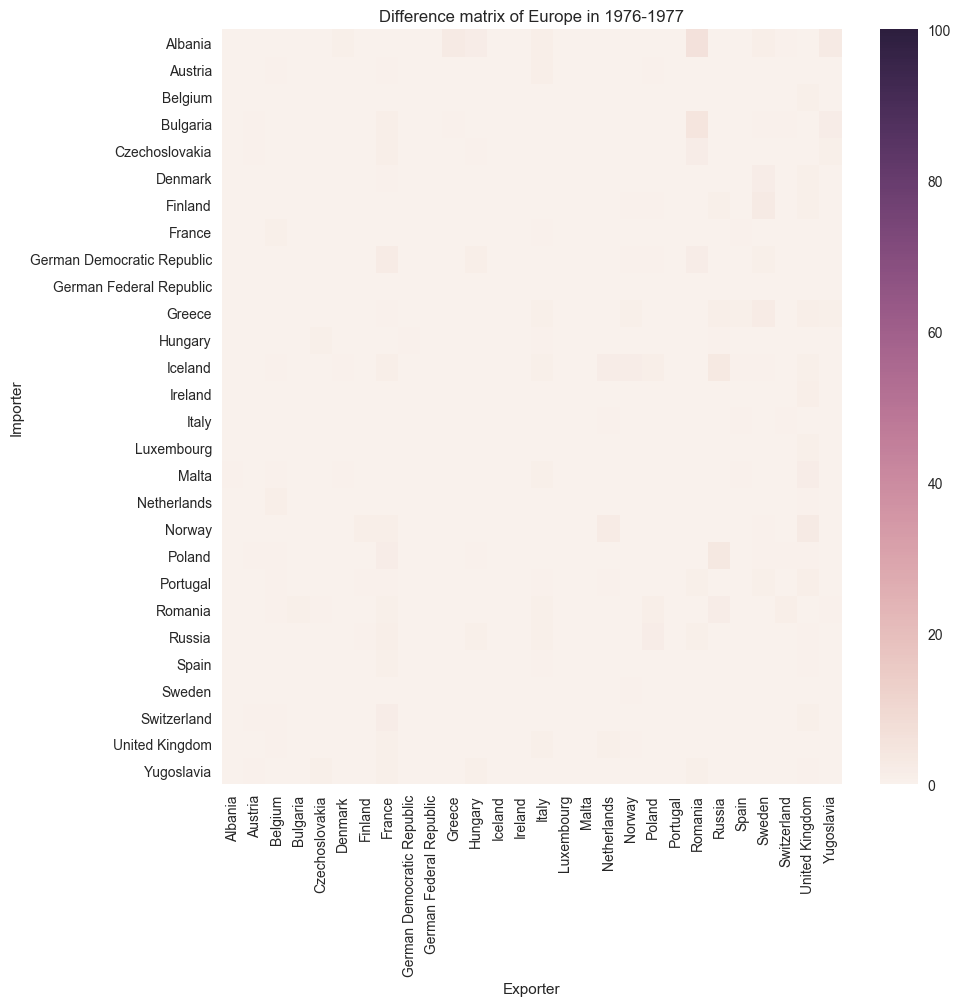

17.435503764334044


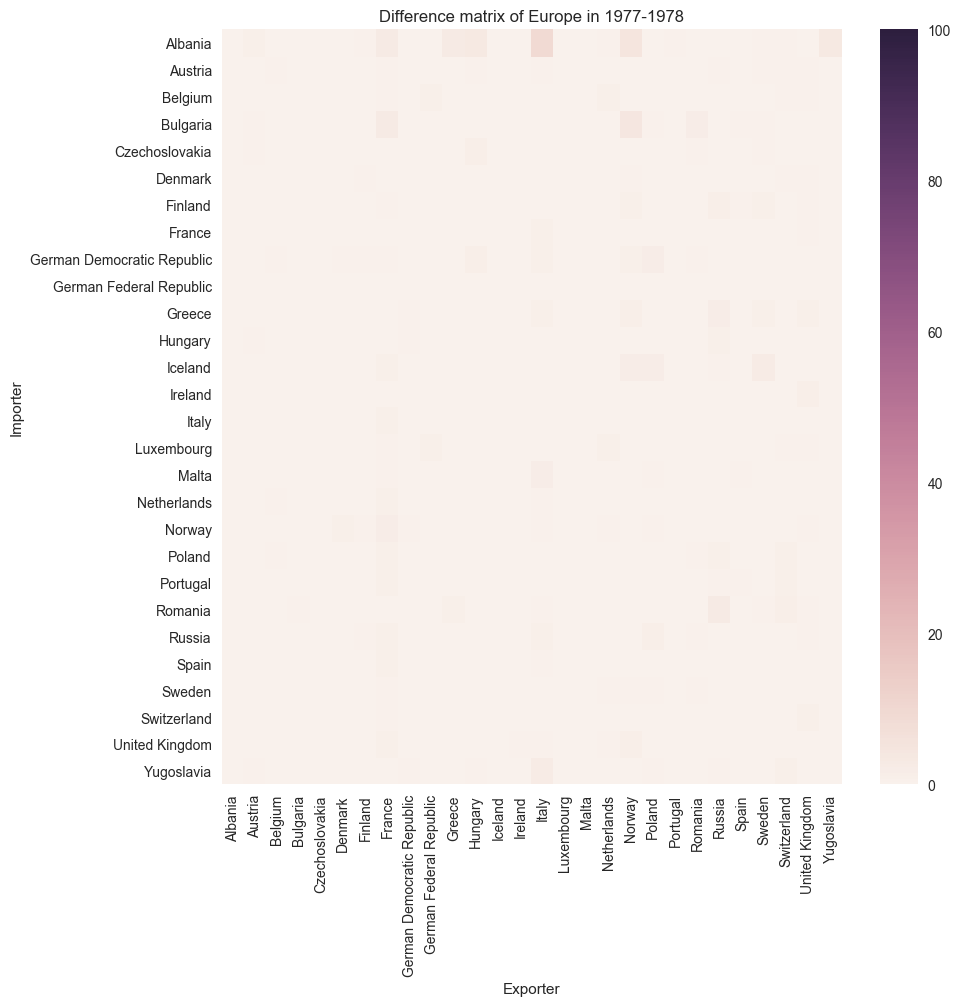

23.727668292280878


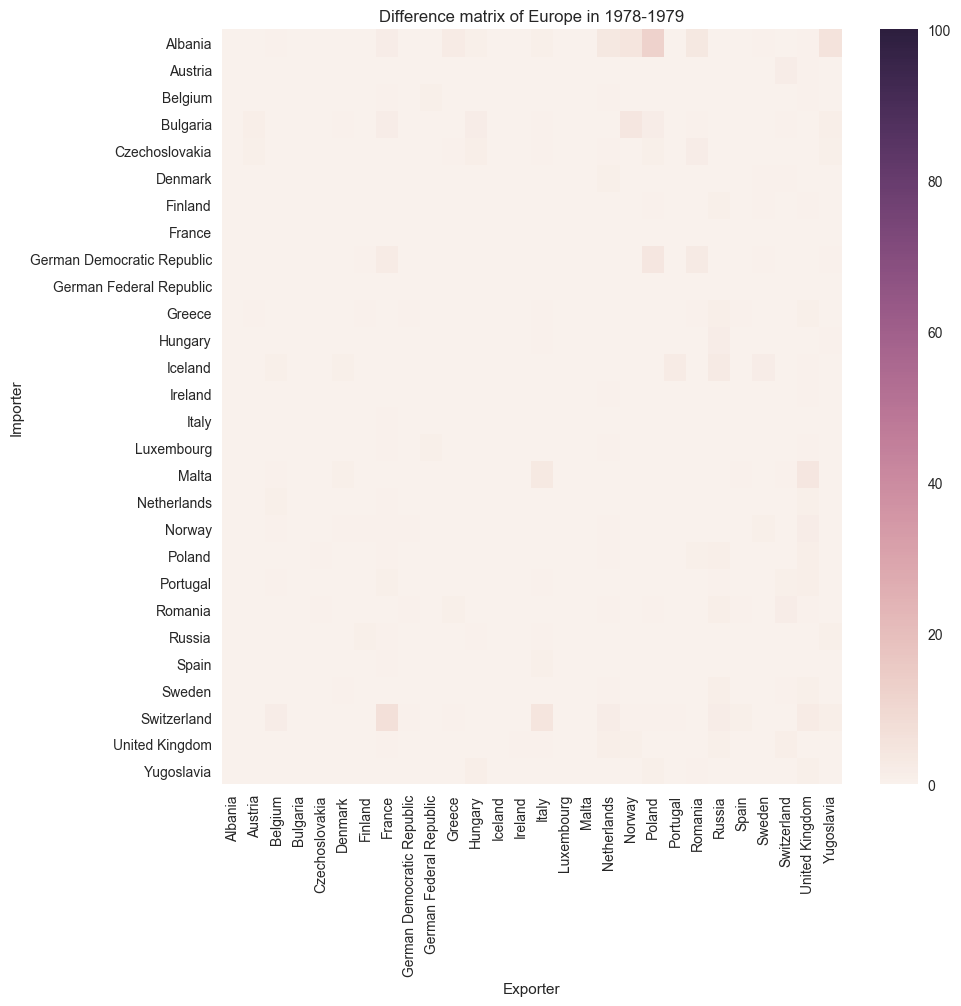

57.26326074888292


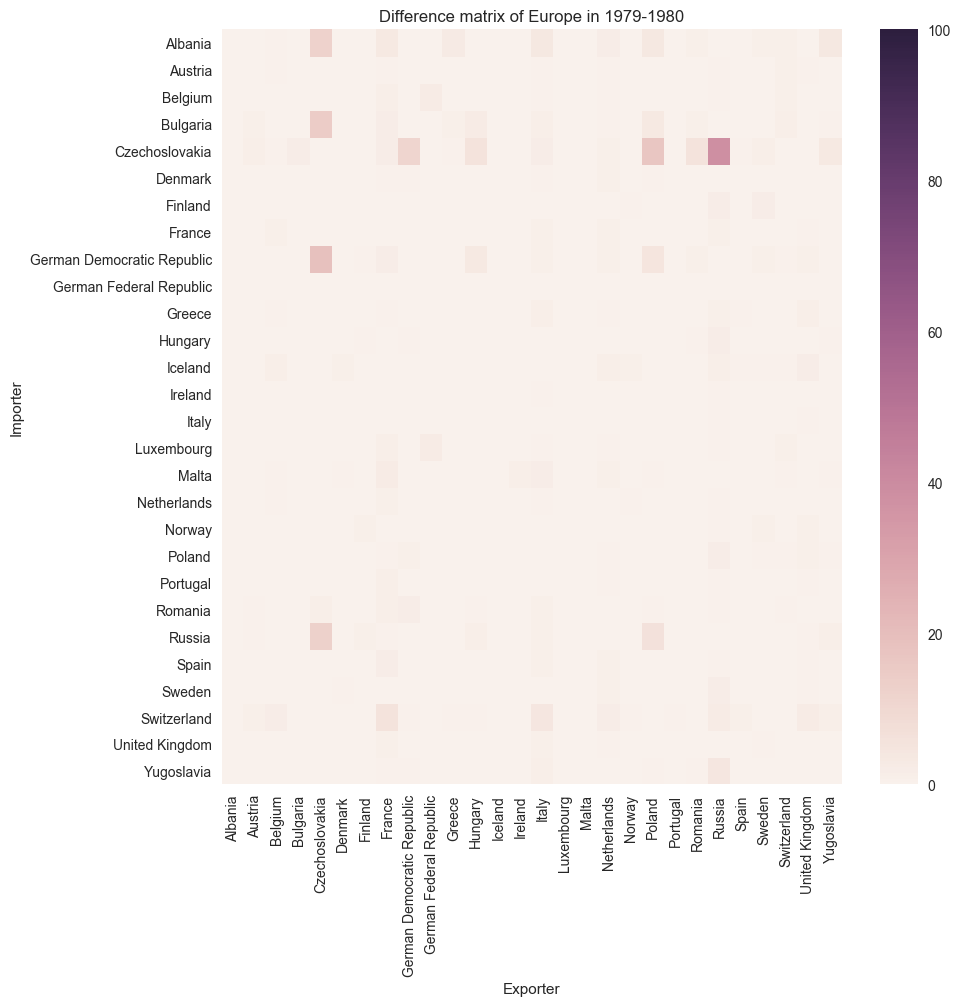

21.551753941476615


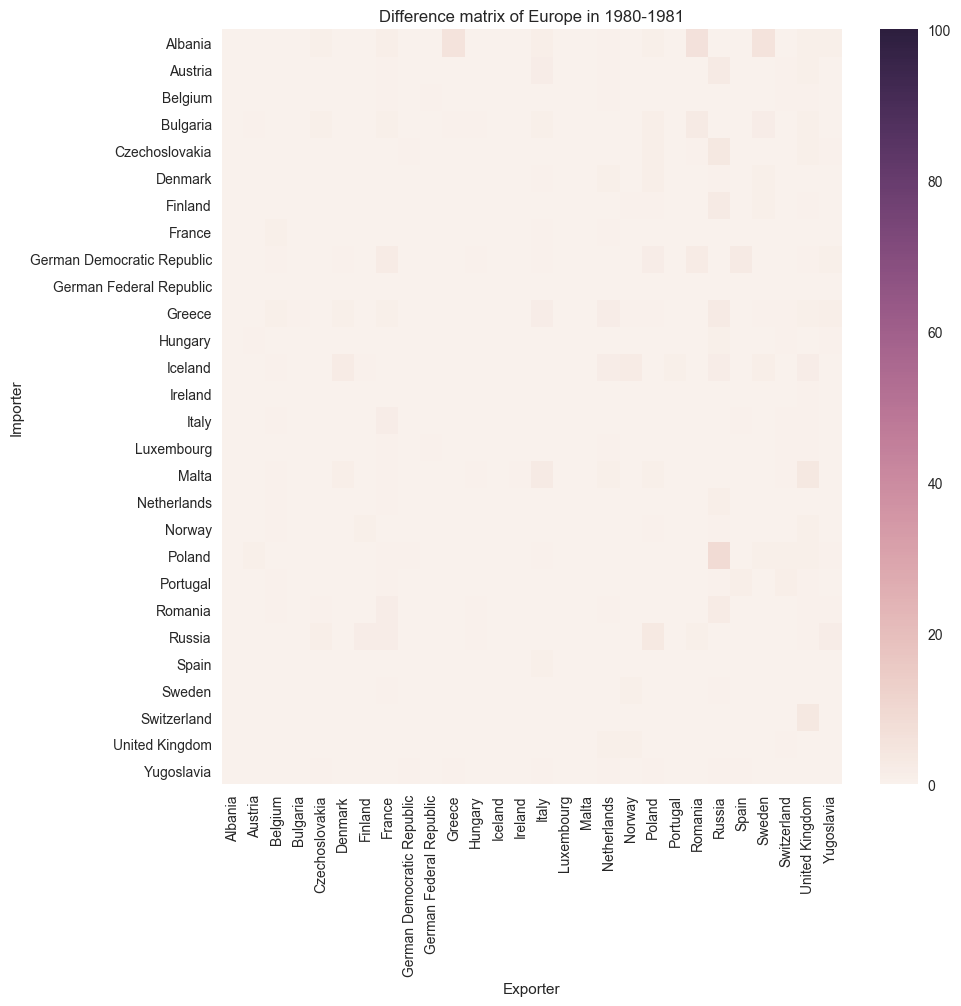

28.63619295344672


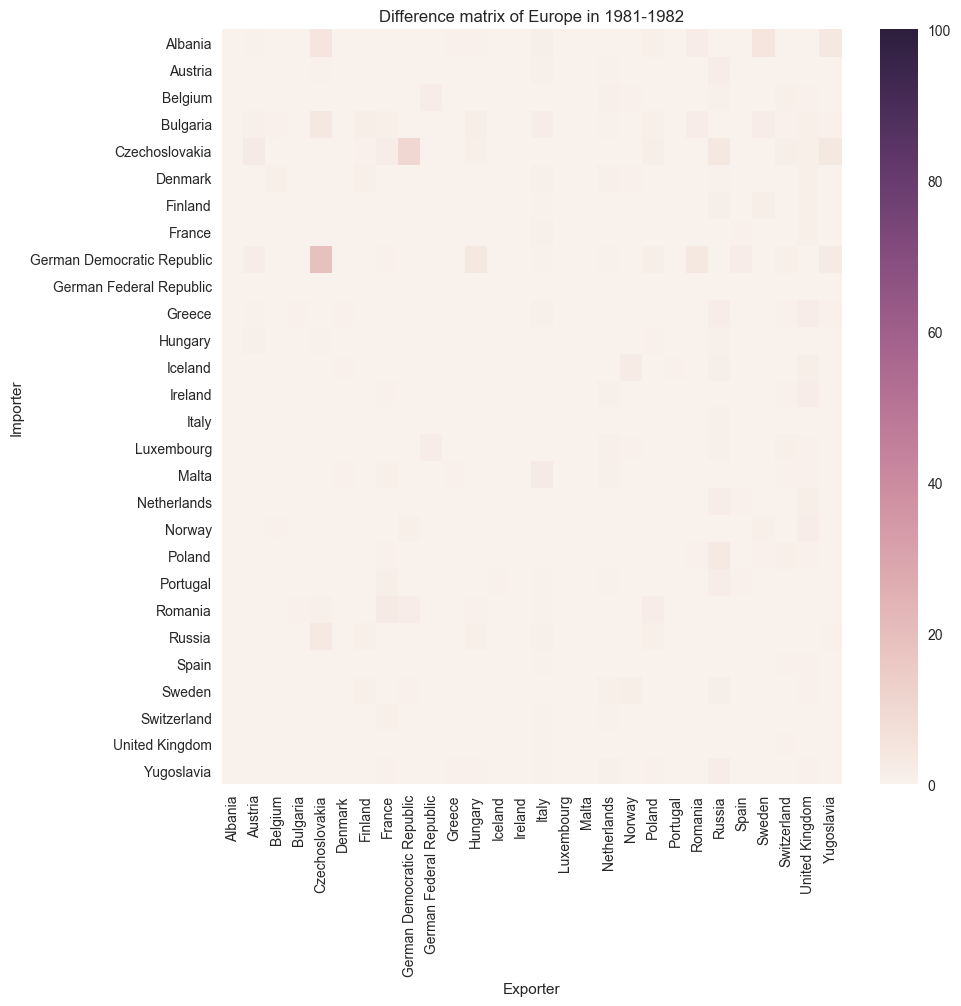

17.711531920122198


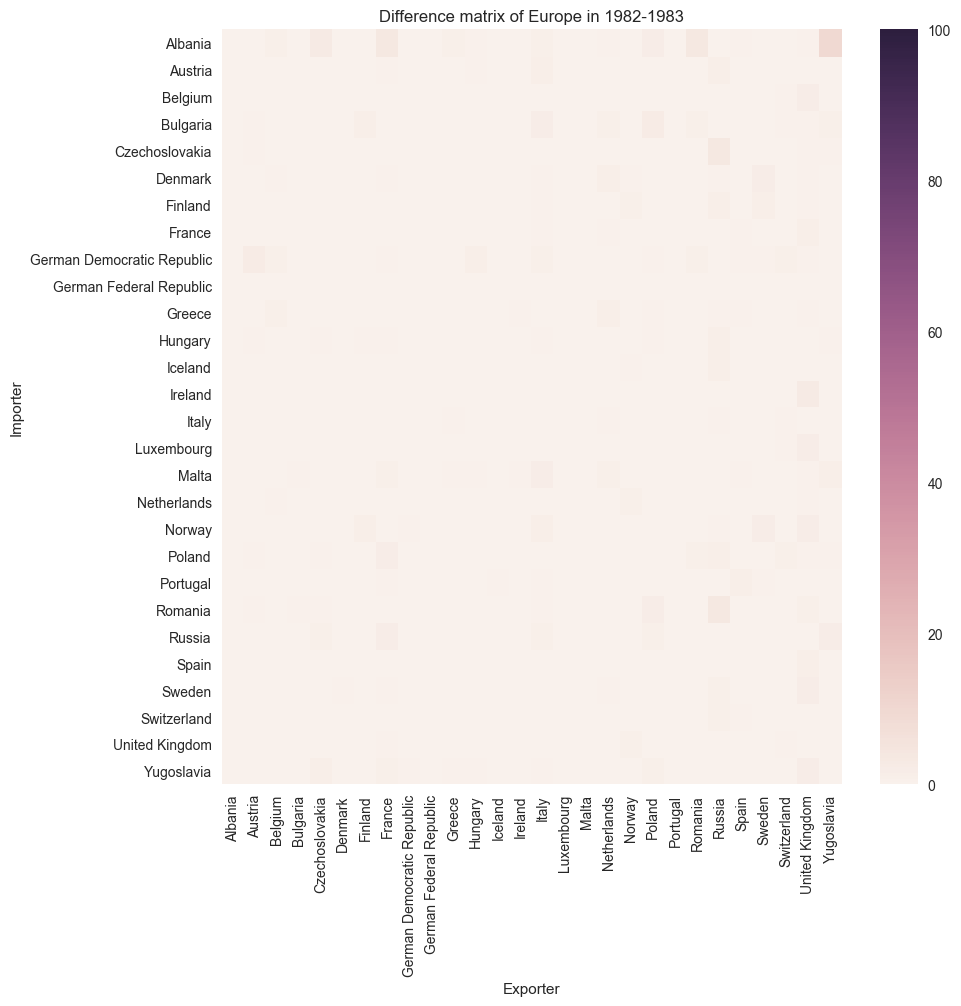

16.252168795064996


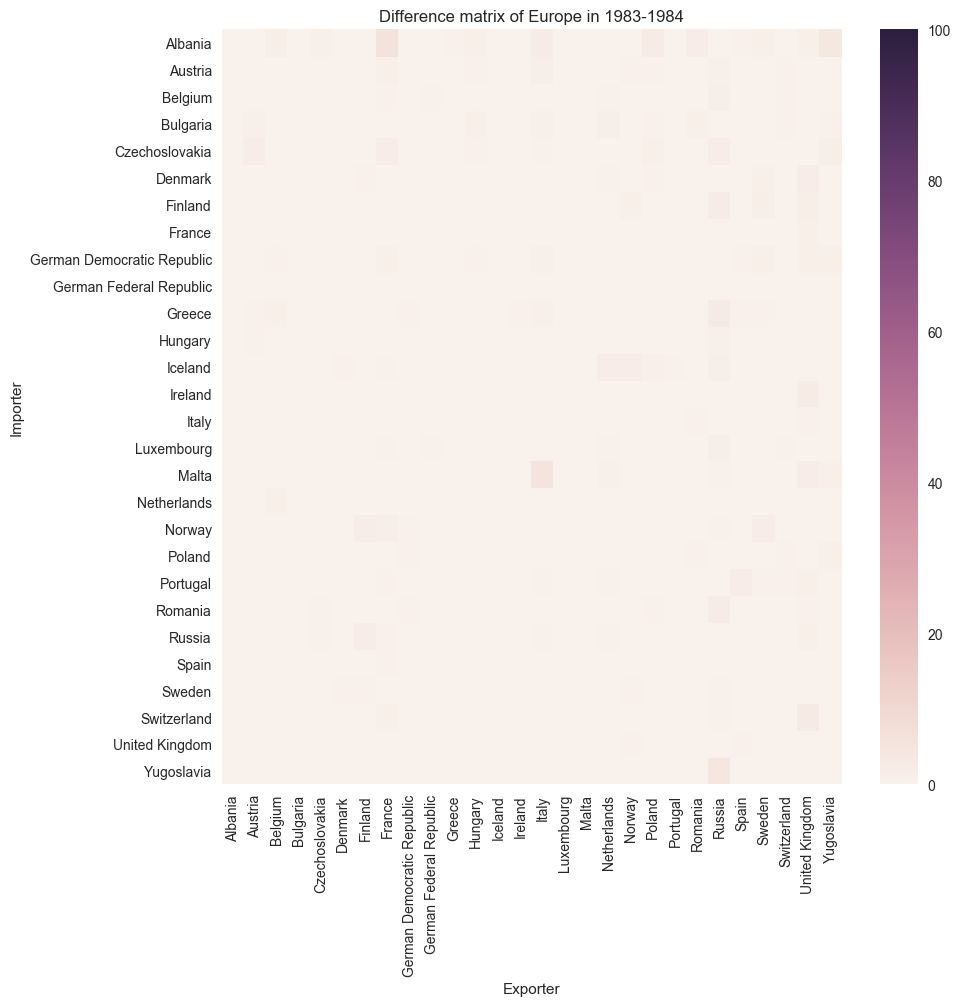

55.5630393451403


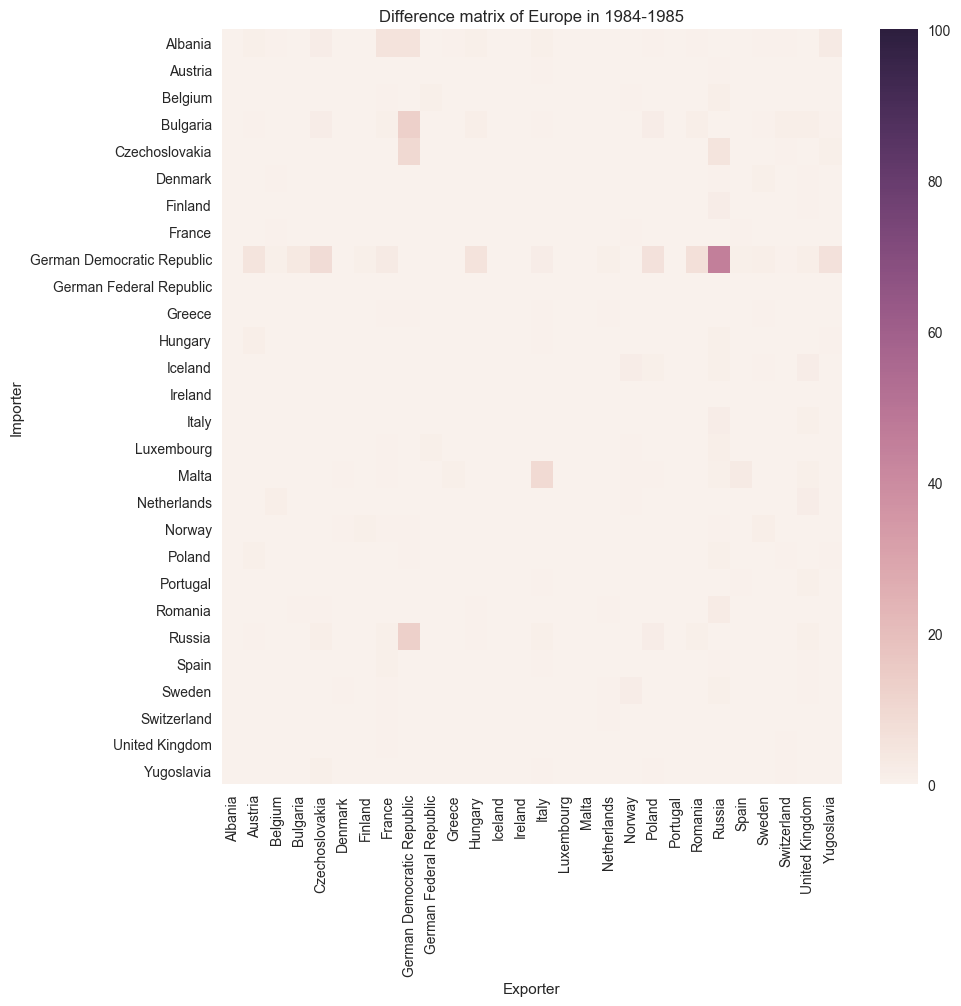

23.395740584726205


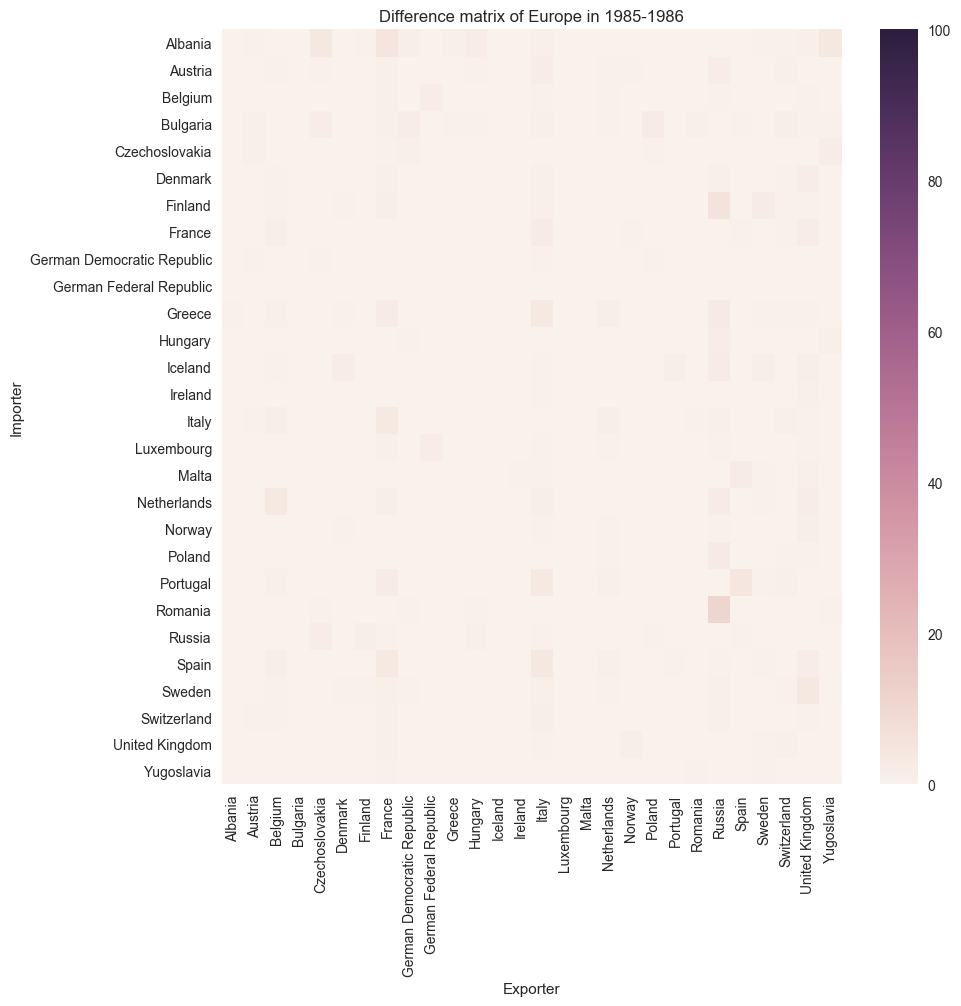

19.00493546928499


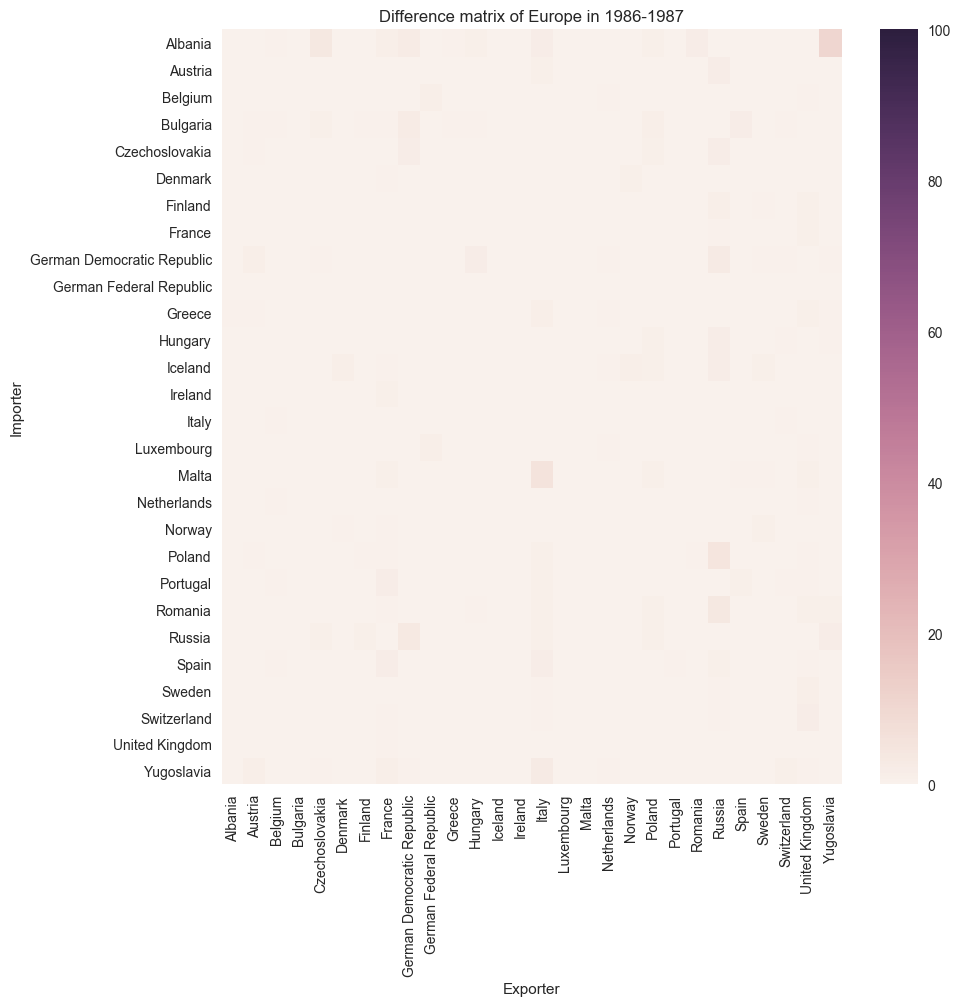

14.95693463714885


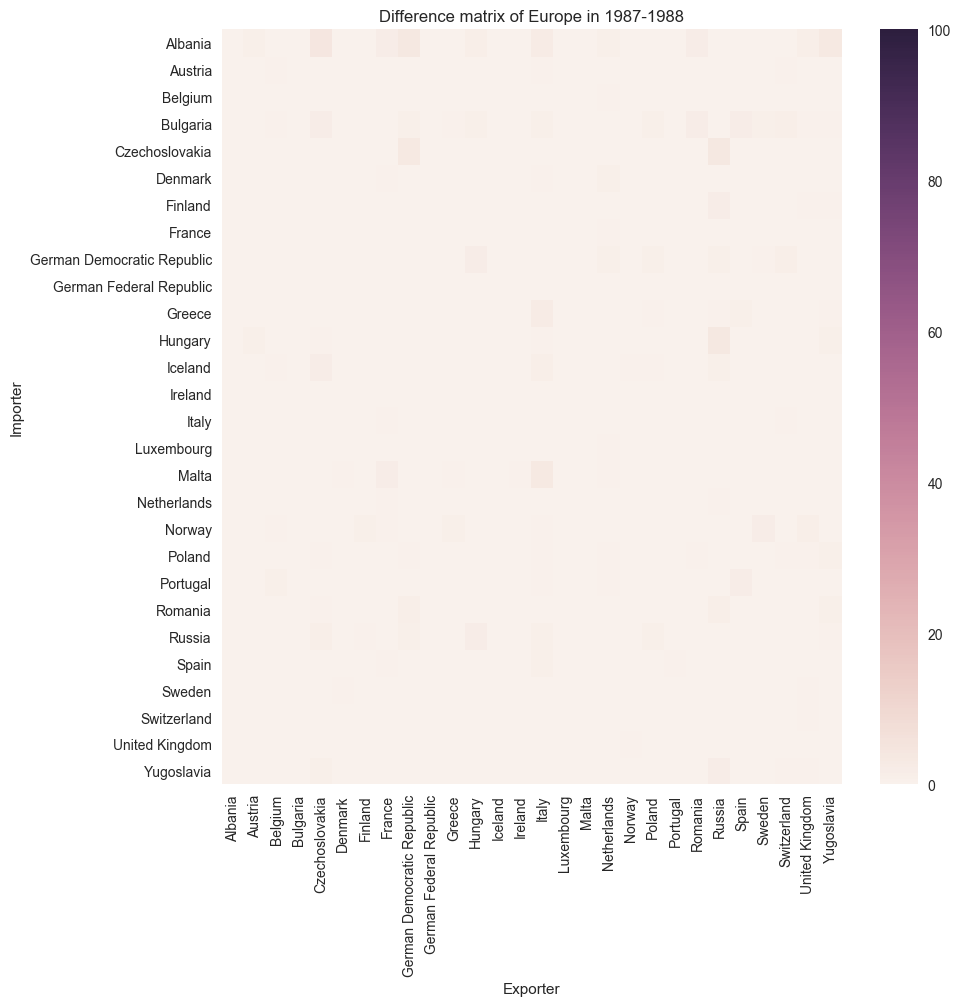

22.48724295428703


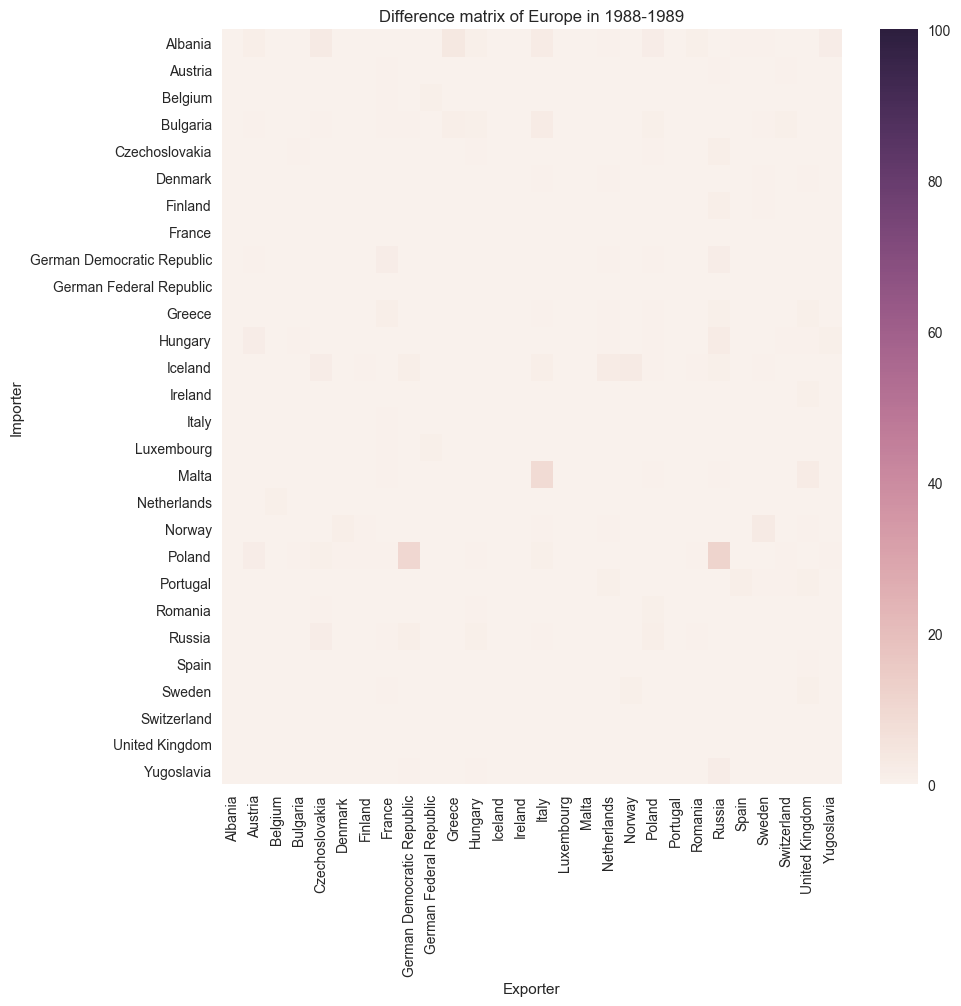

29.655038973331465


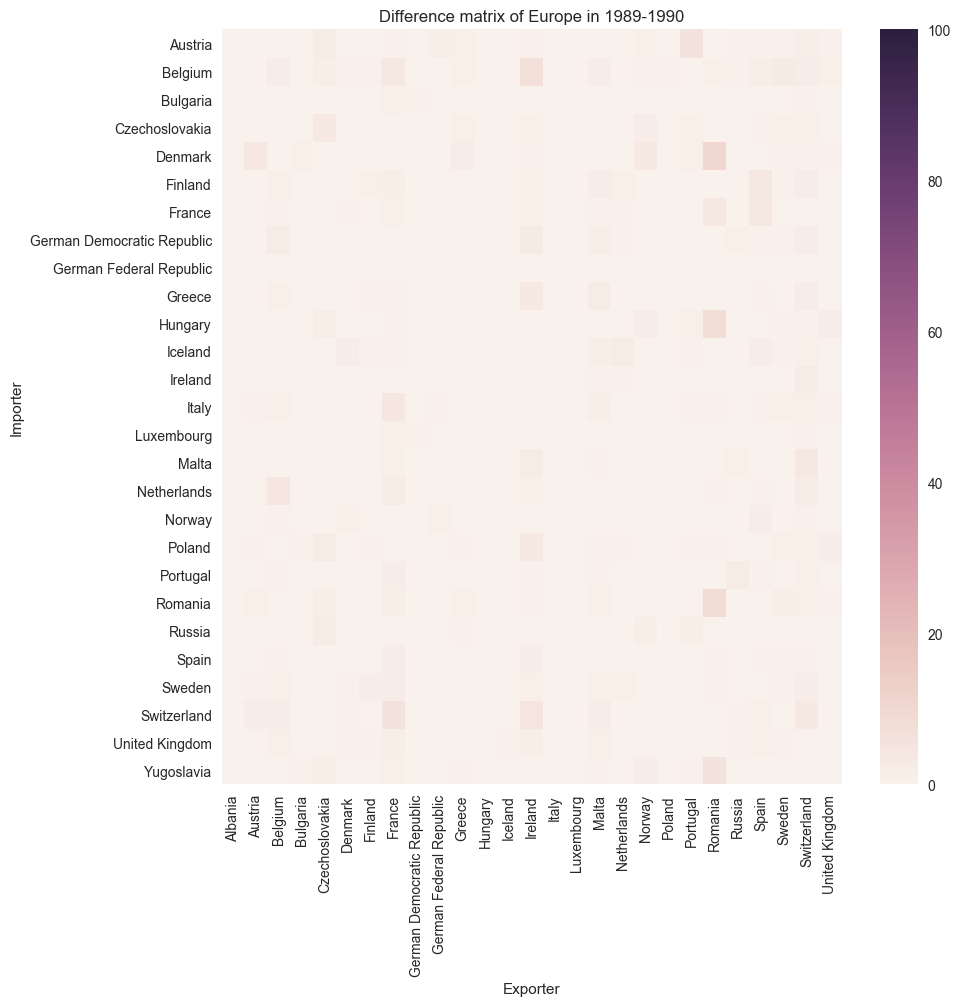

43.80217757563533


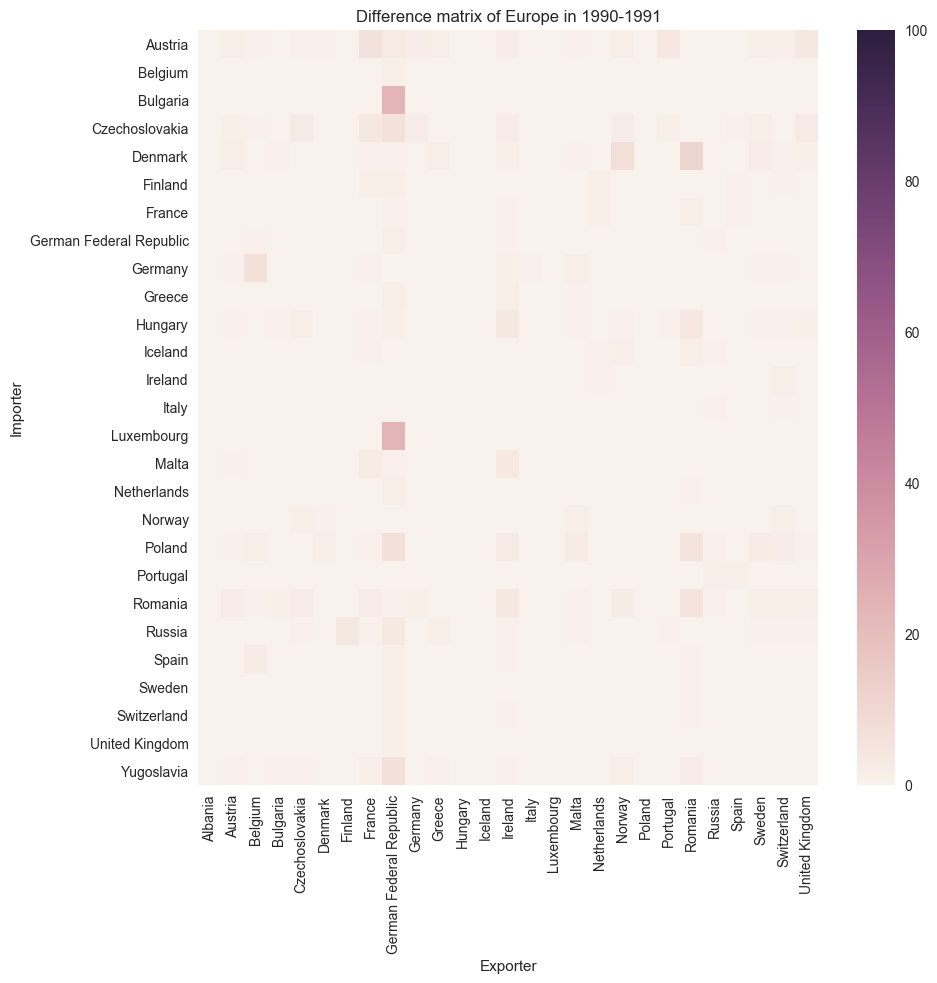

46.58921994903931


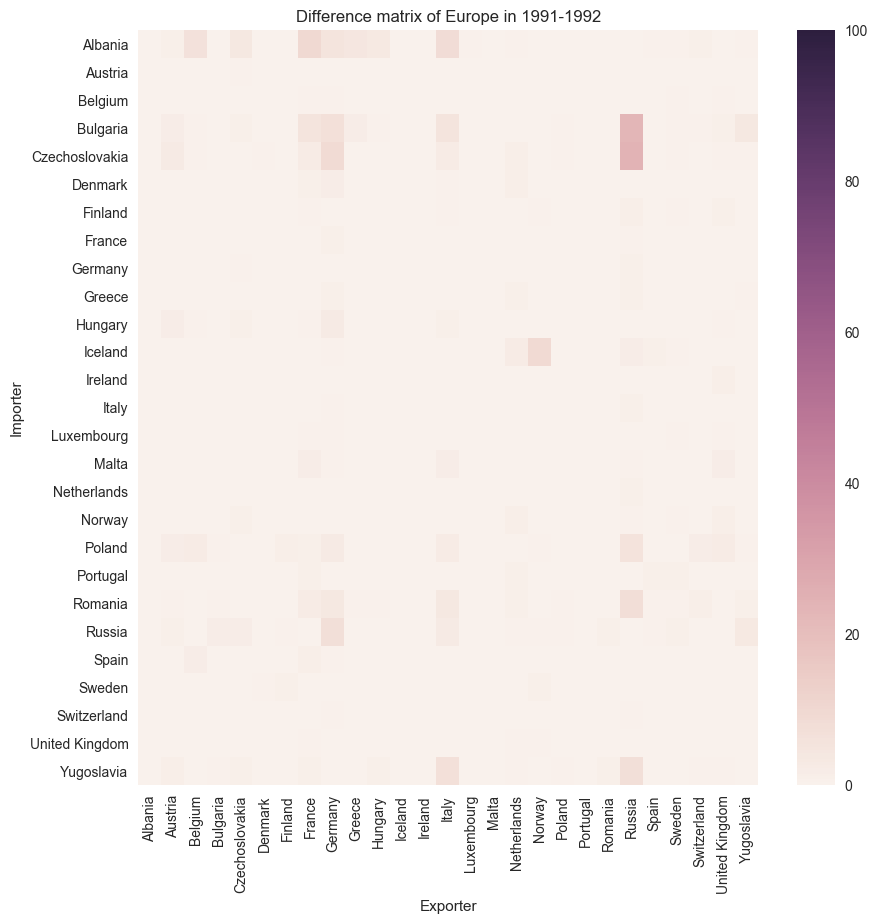

116.12544784000522


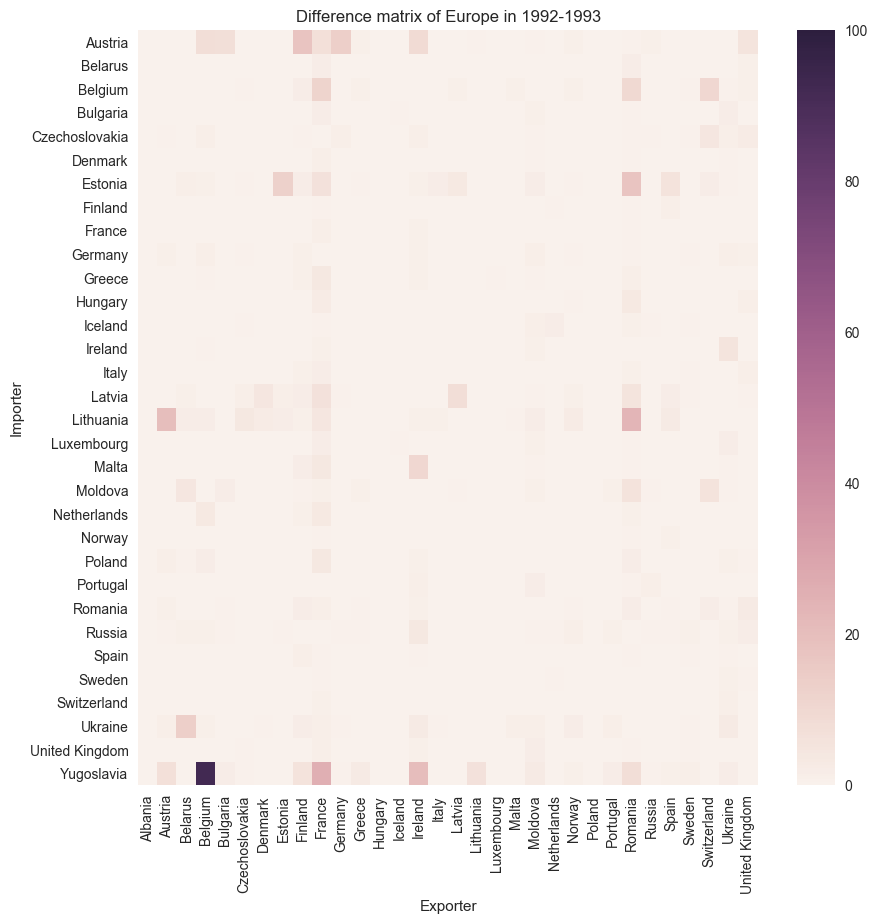

79.89259258135965


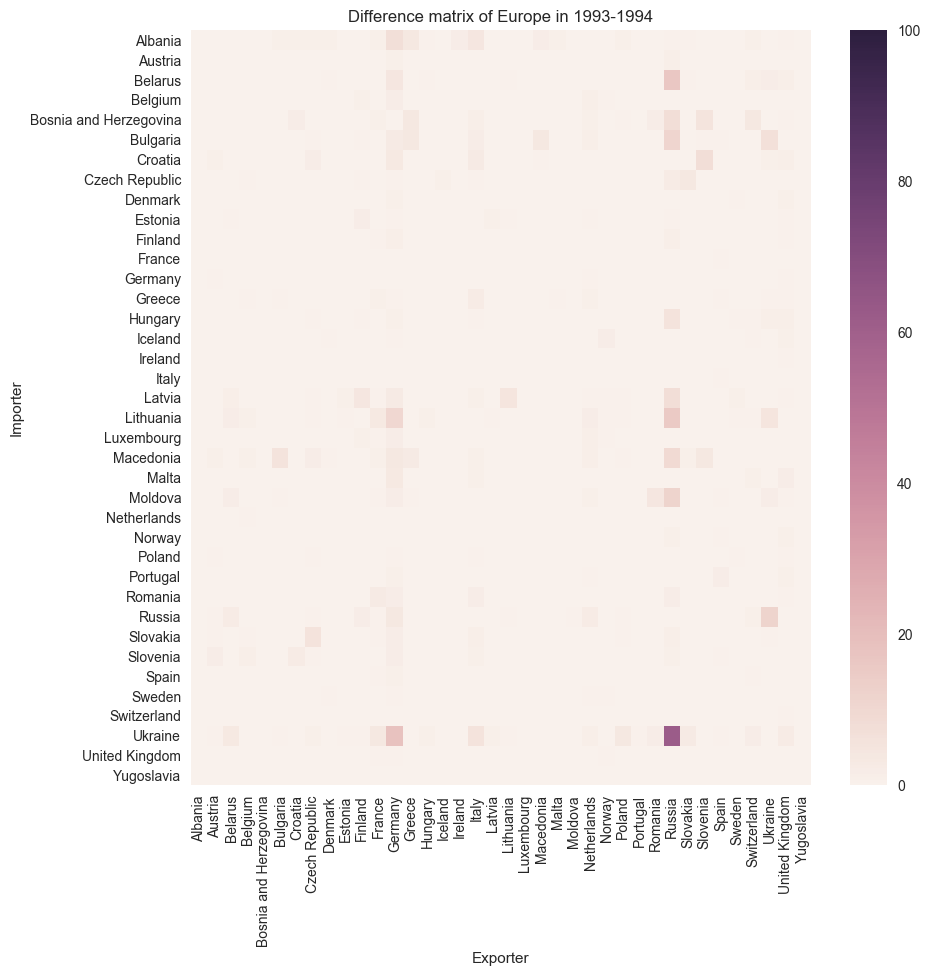

37.95202666858278


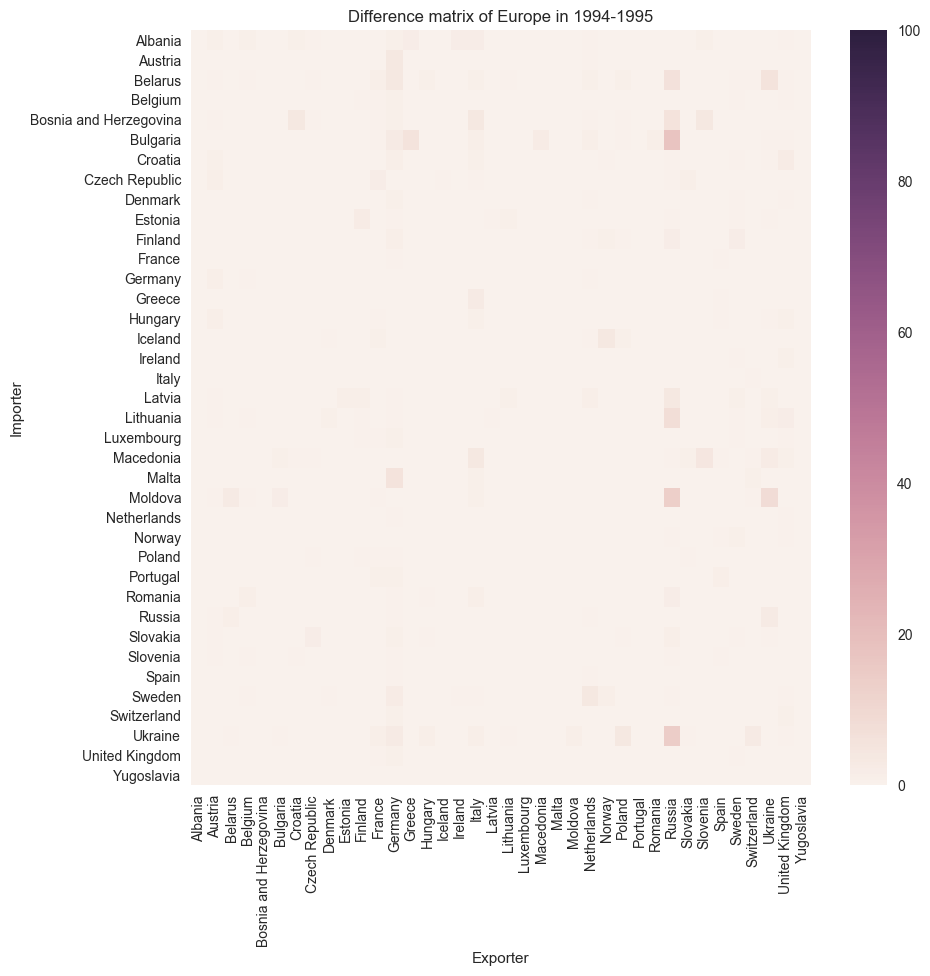

32.51363350307377


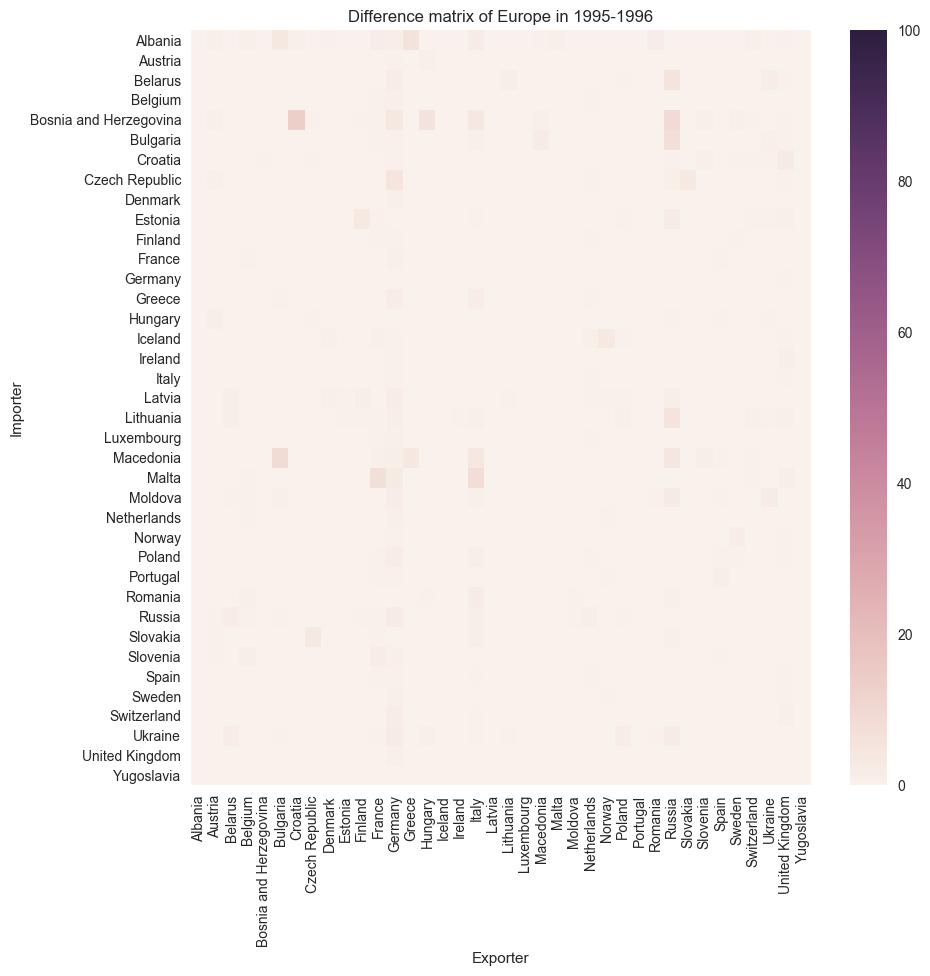

49.52669530337584


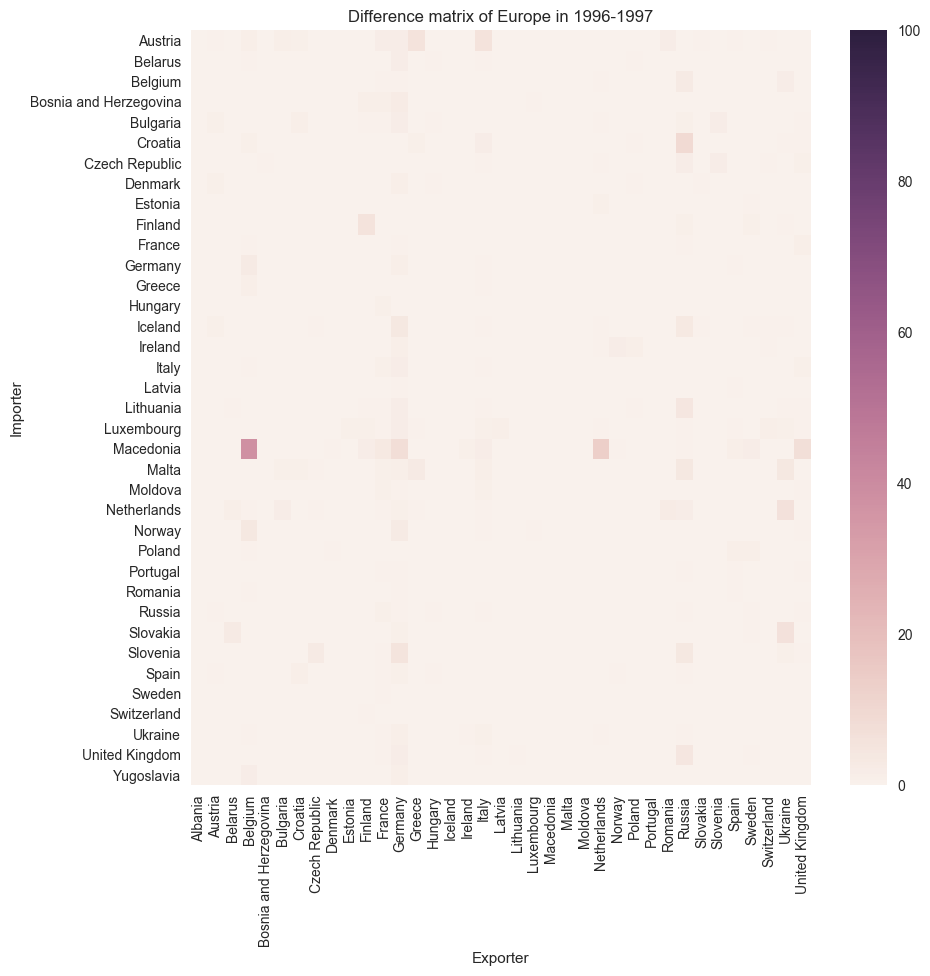

21.861642186277443


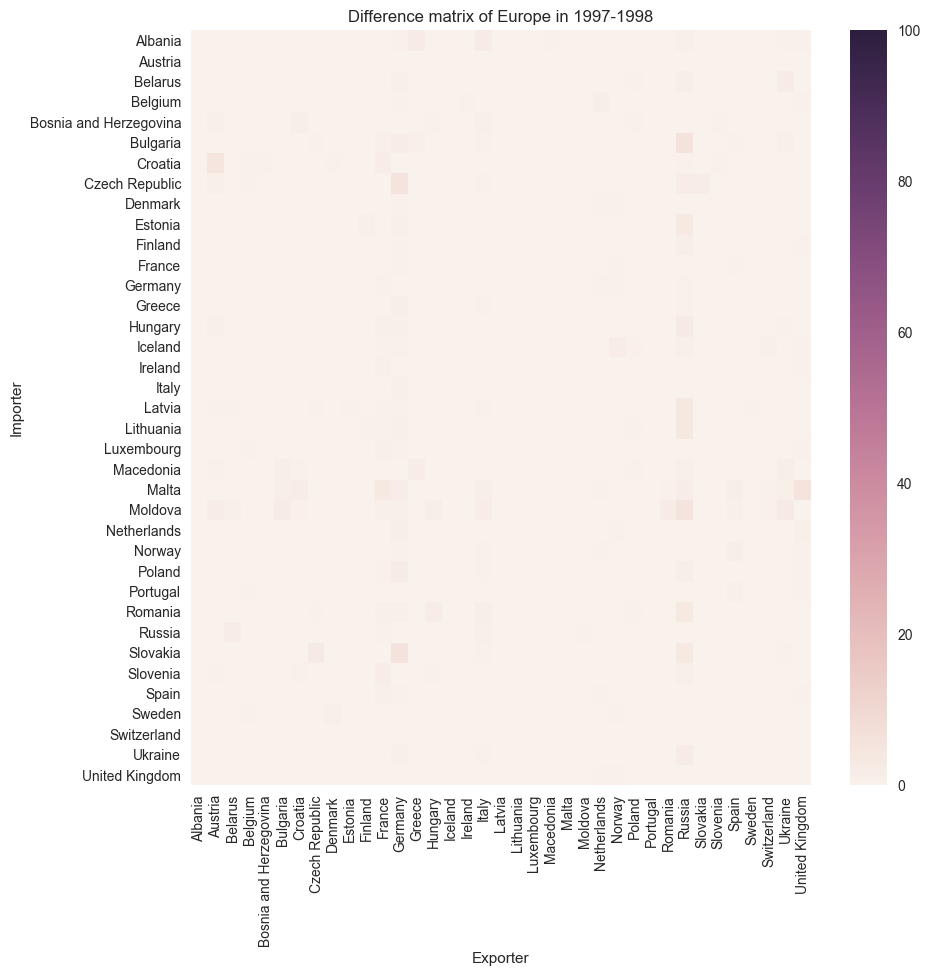

22.22977760425606


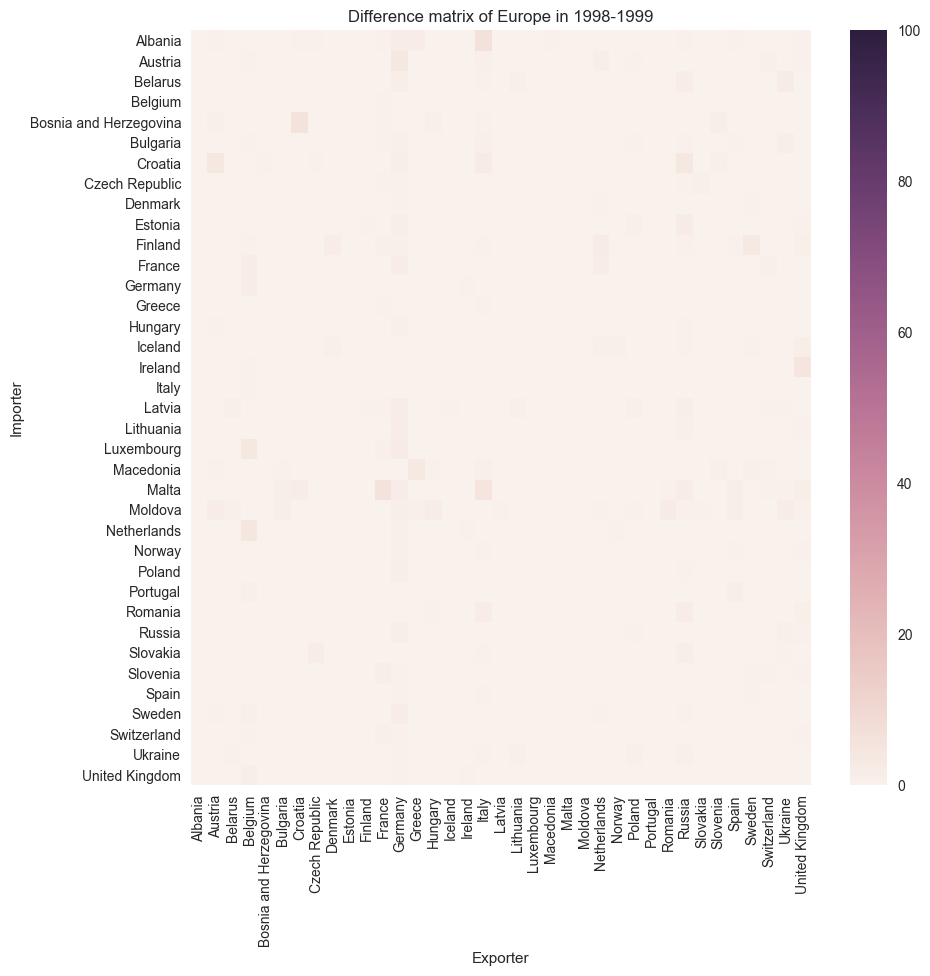

25.10178917936769


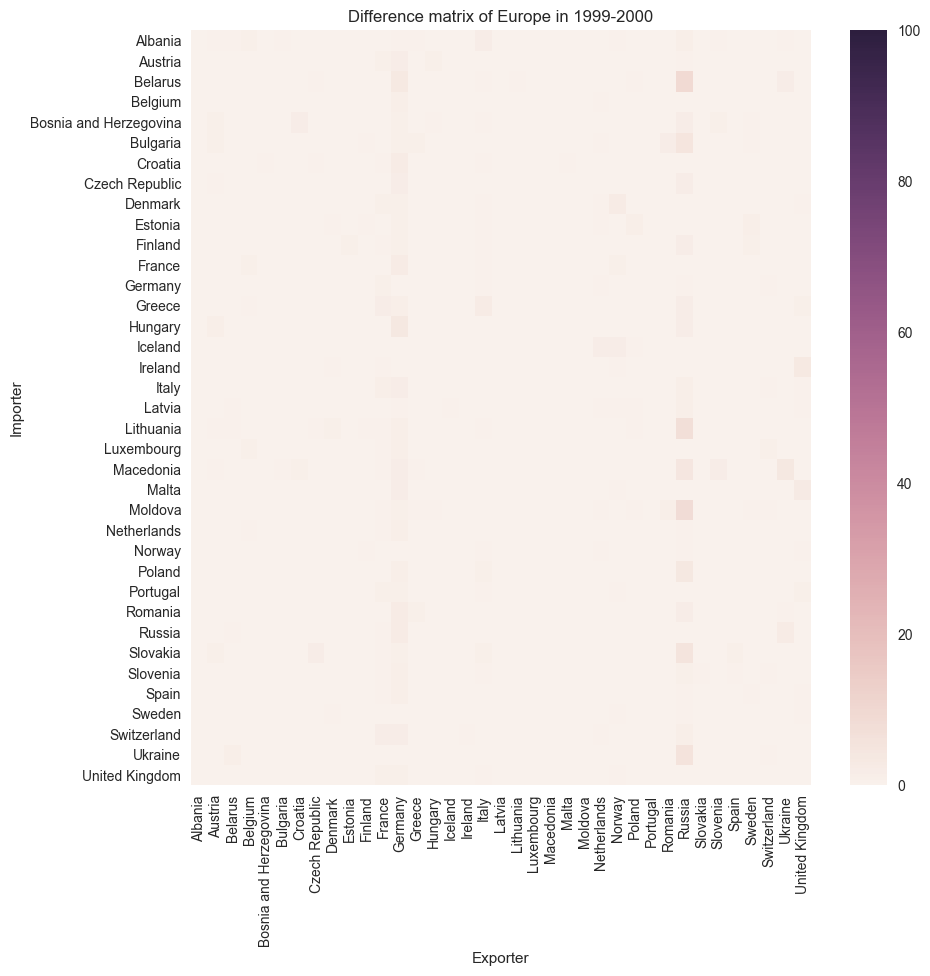

22.194551529837558


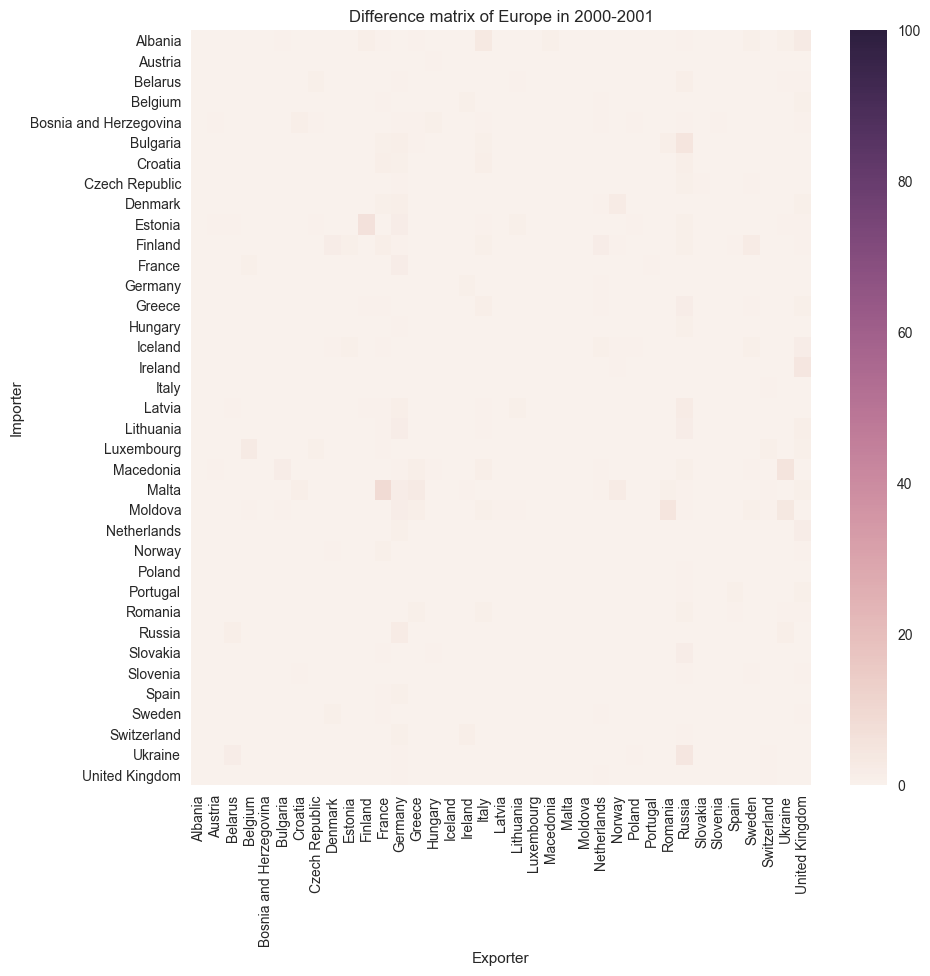

18.468031964652


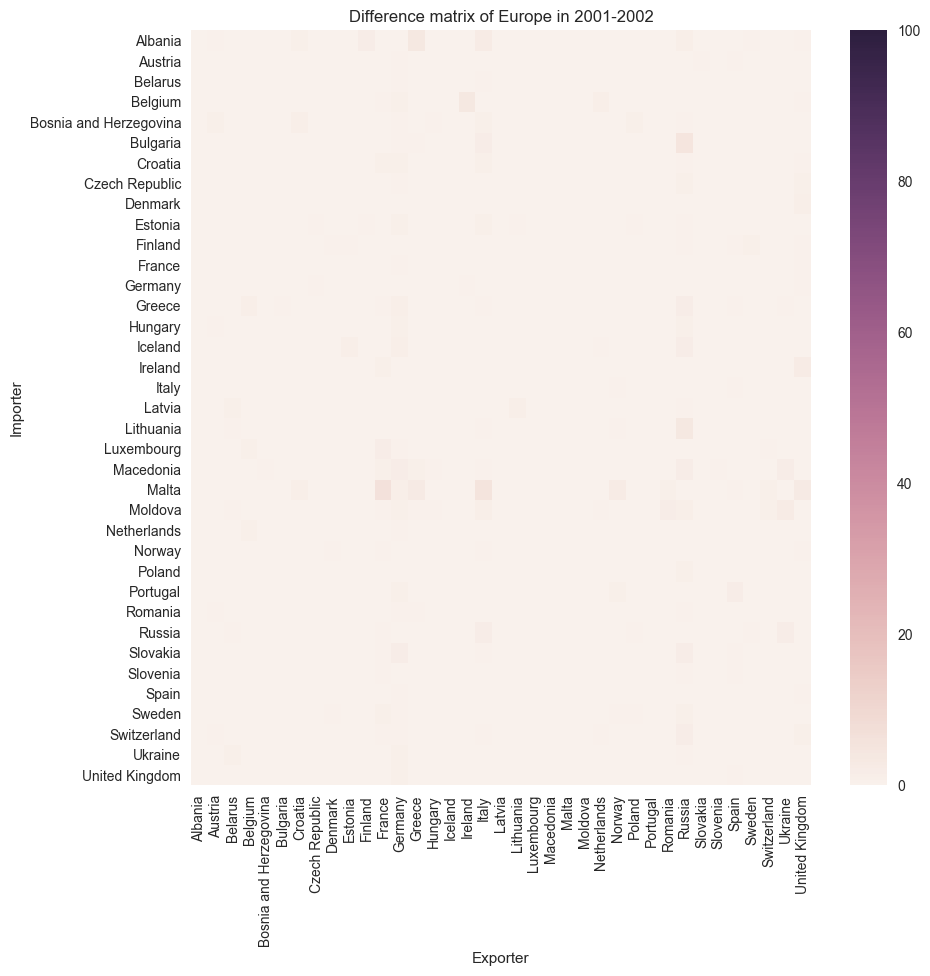

15.694503579625378


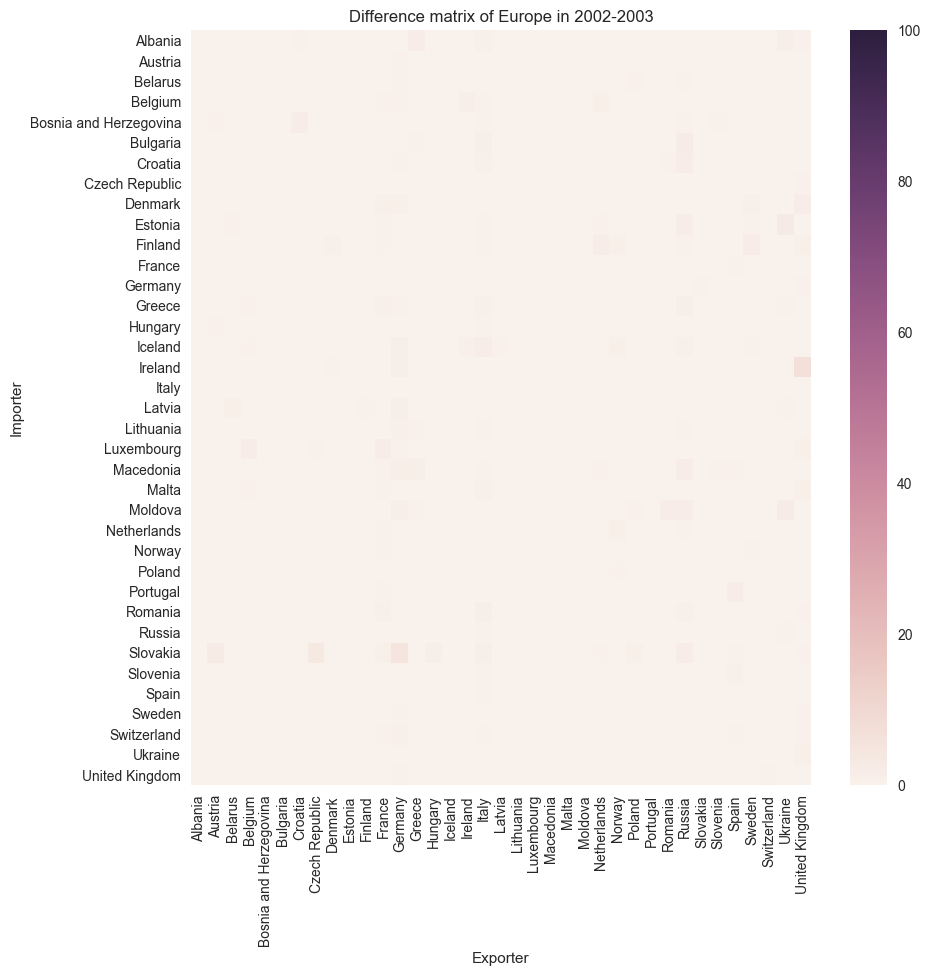

20.71806323306827


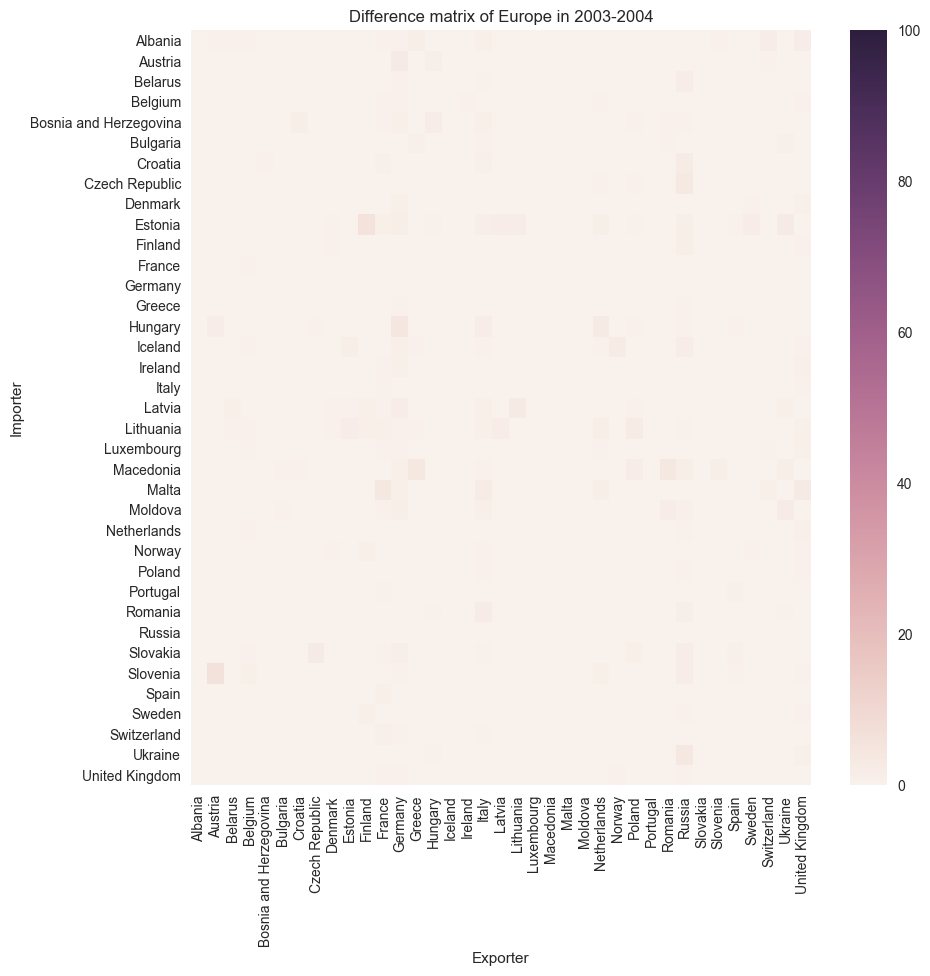

22.610103331290976


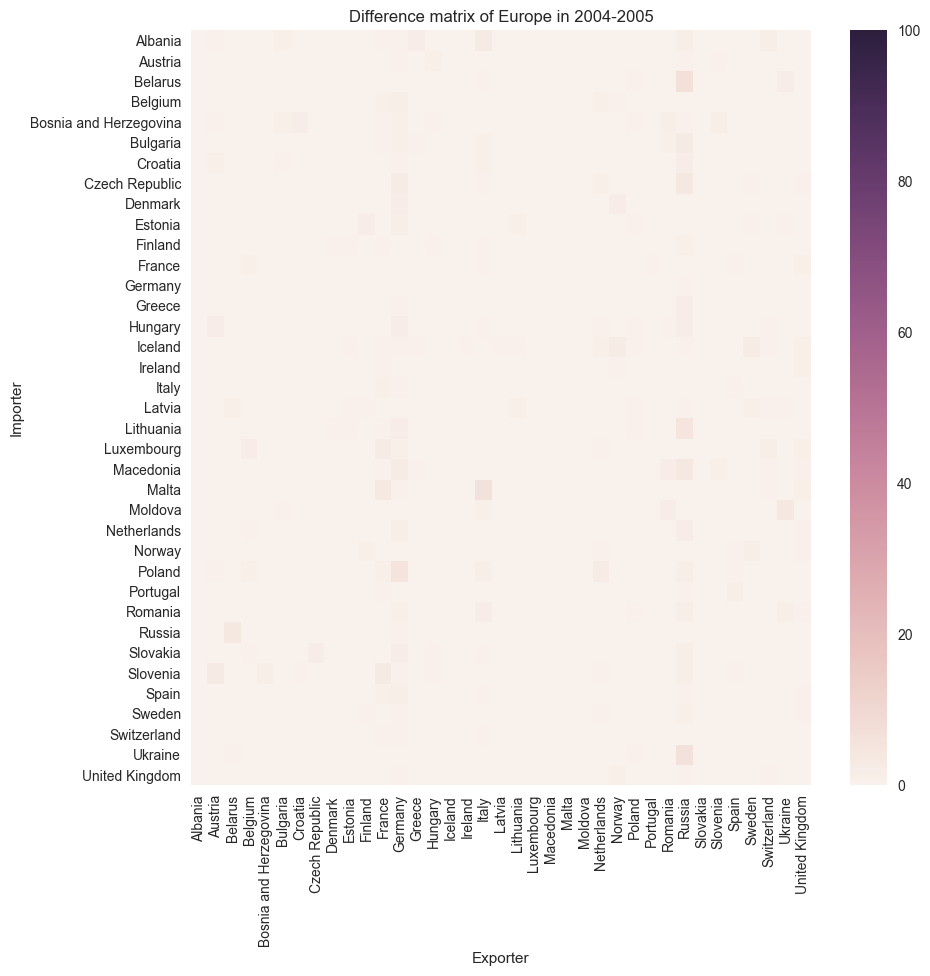

21.16178655653509


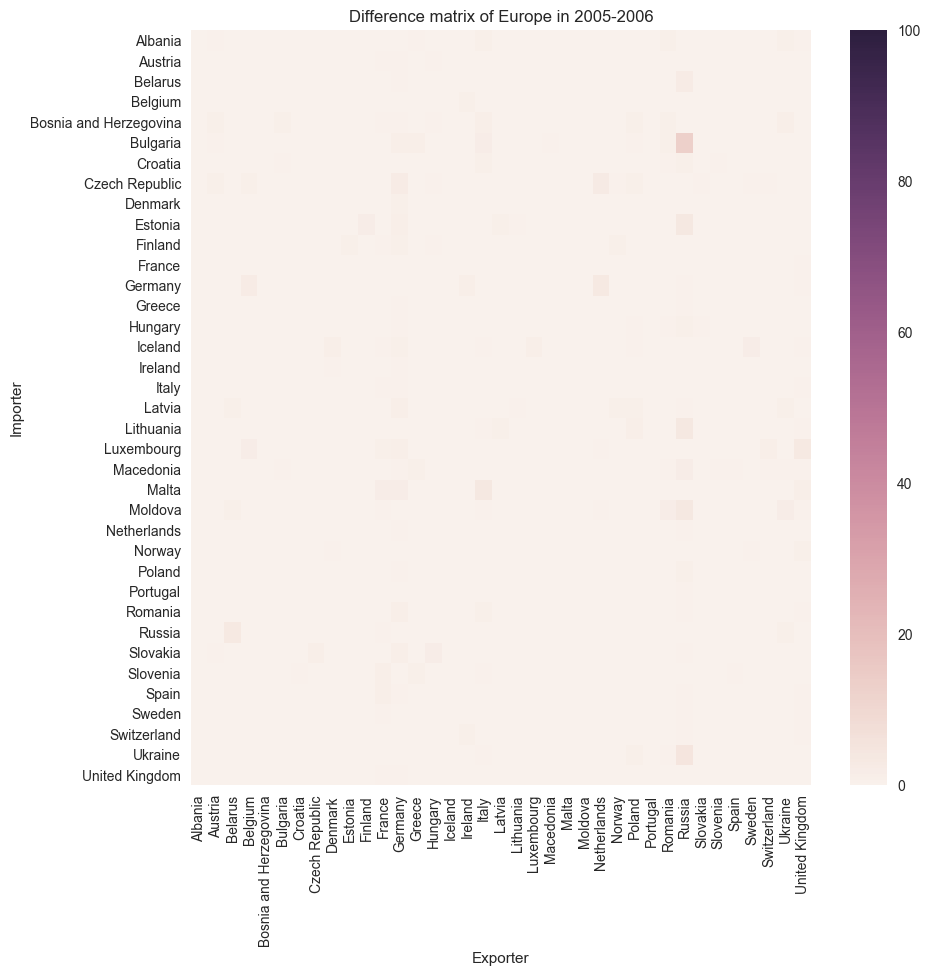

21.23333616371947


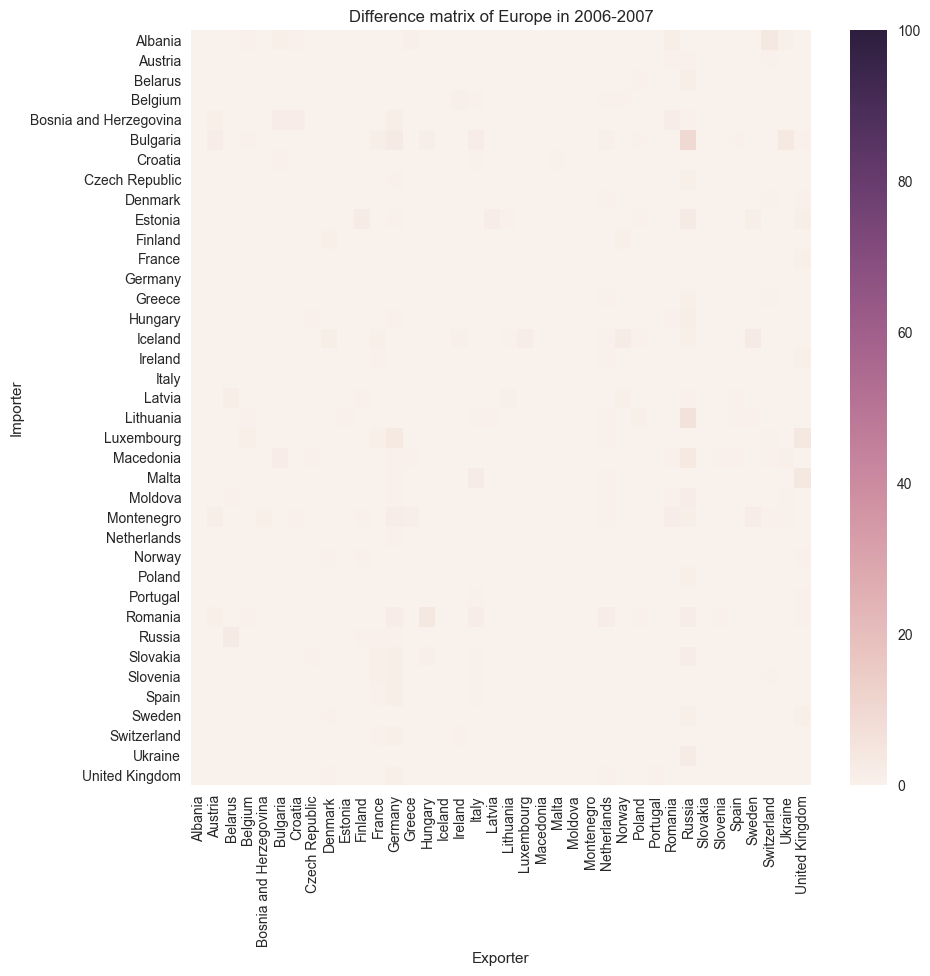

21.128644387553752


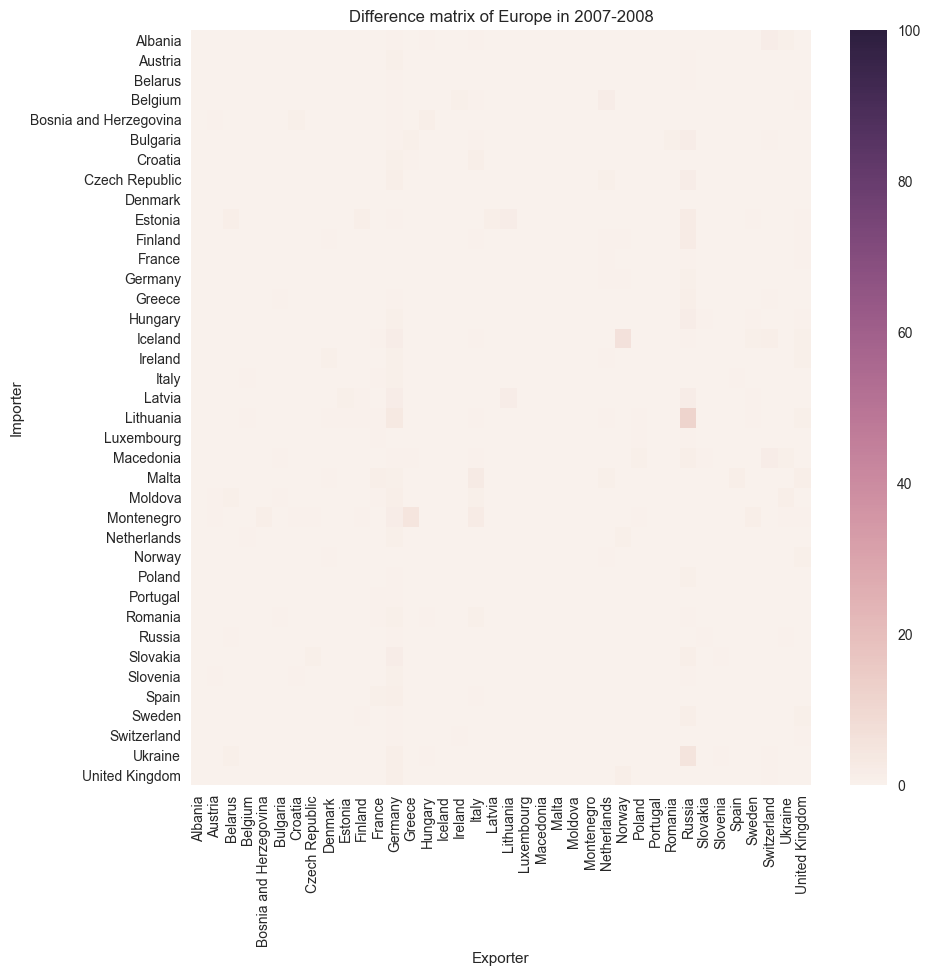

27.415544714777354


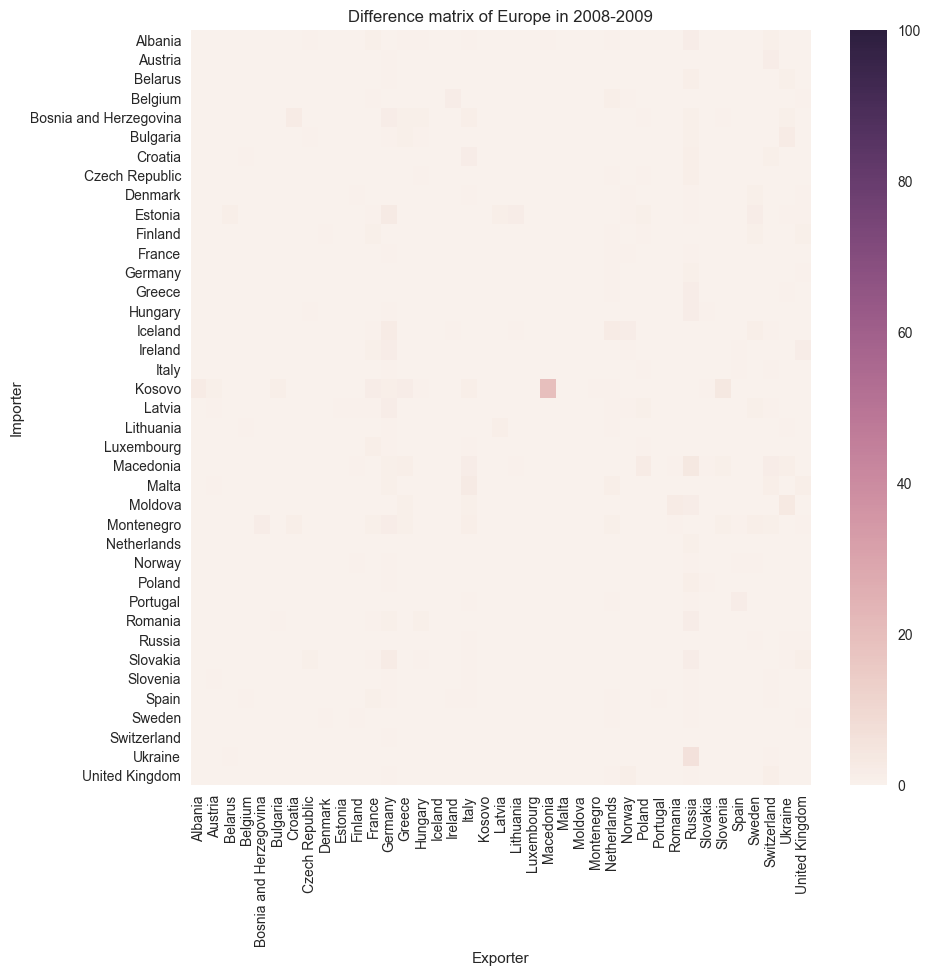

22.009622862086232


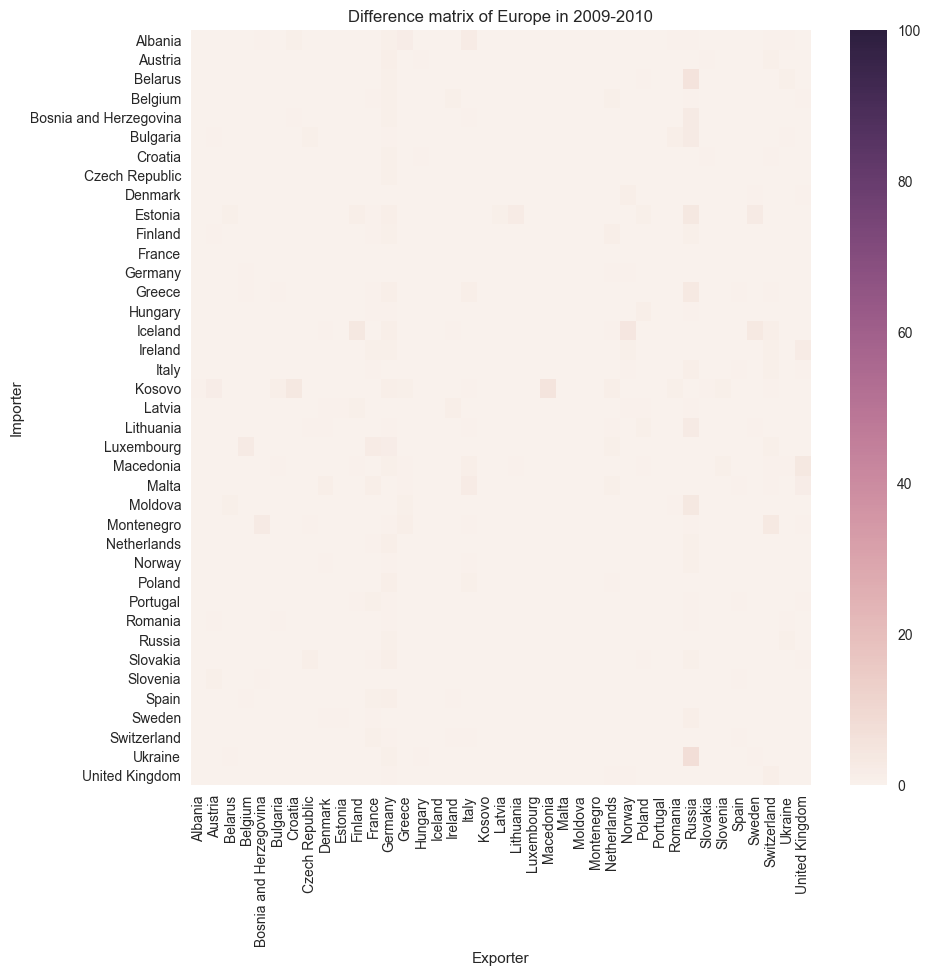

22.662867677708032


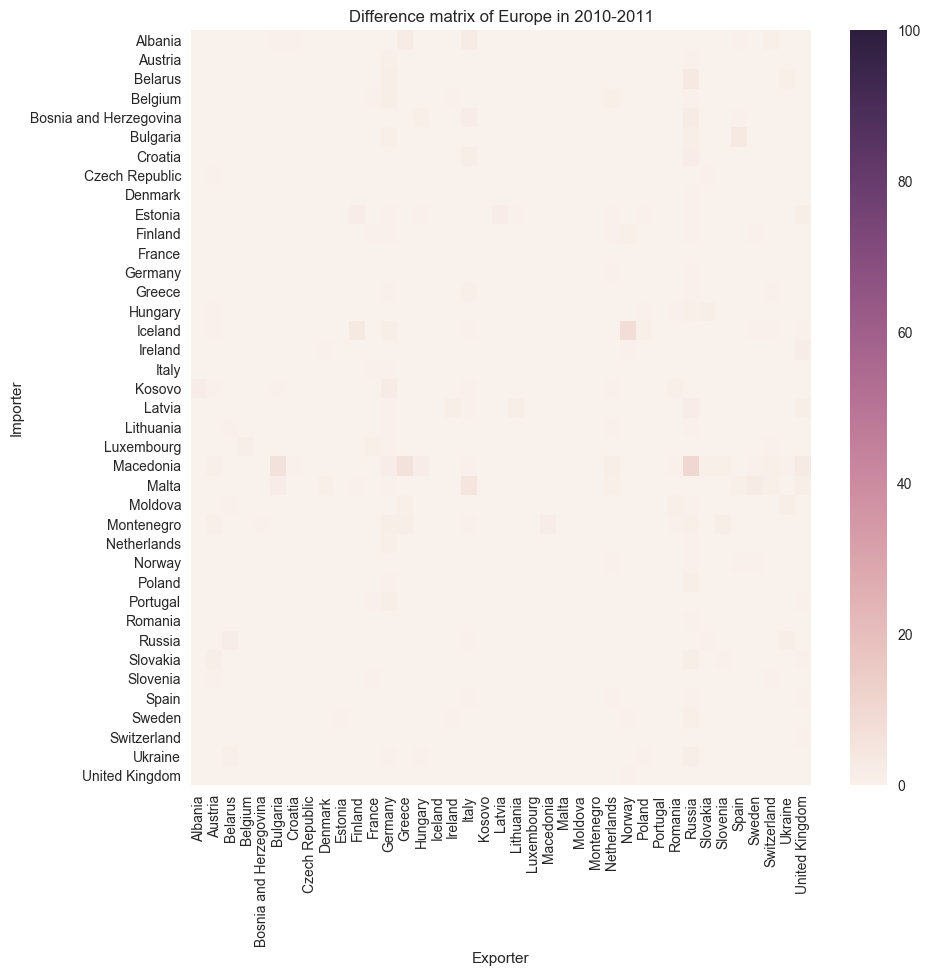

16.198698398573537


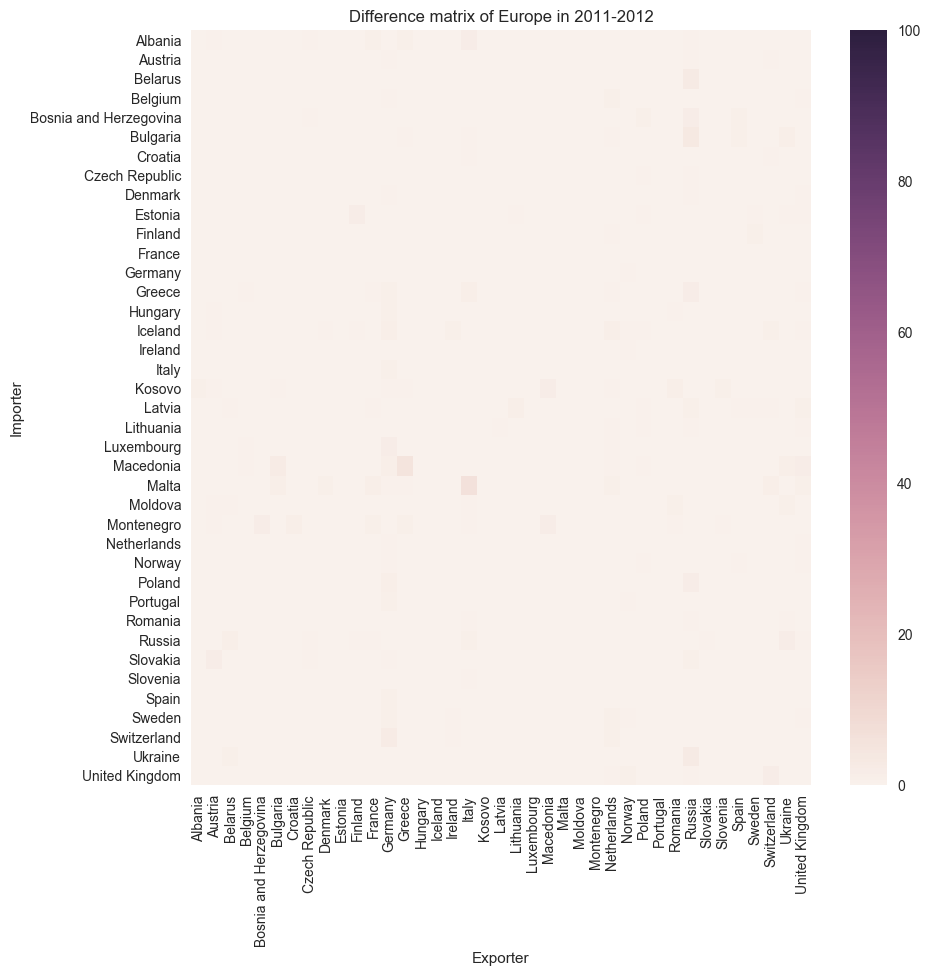

17.507979626881514


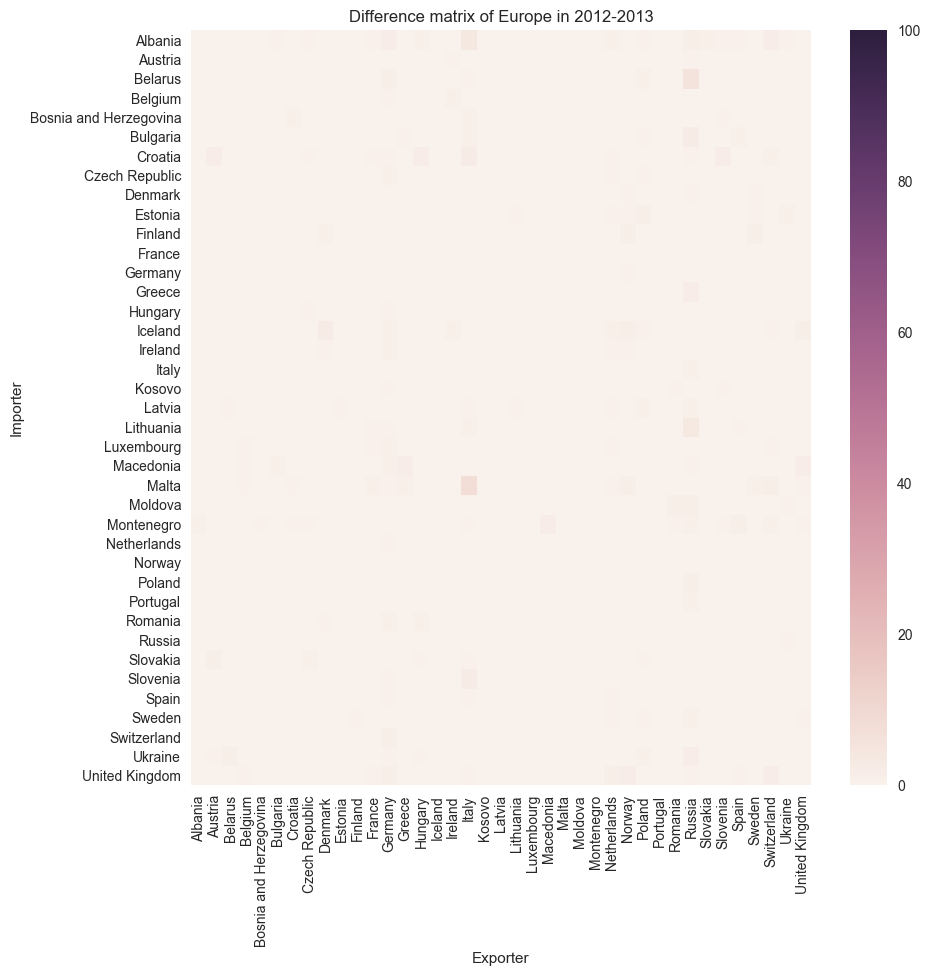

22.914450411254453


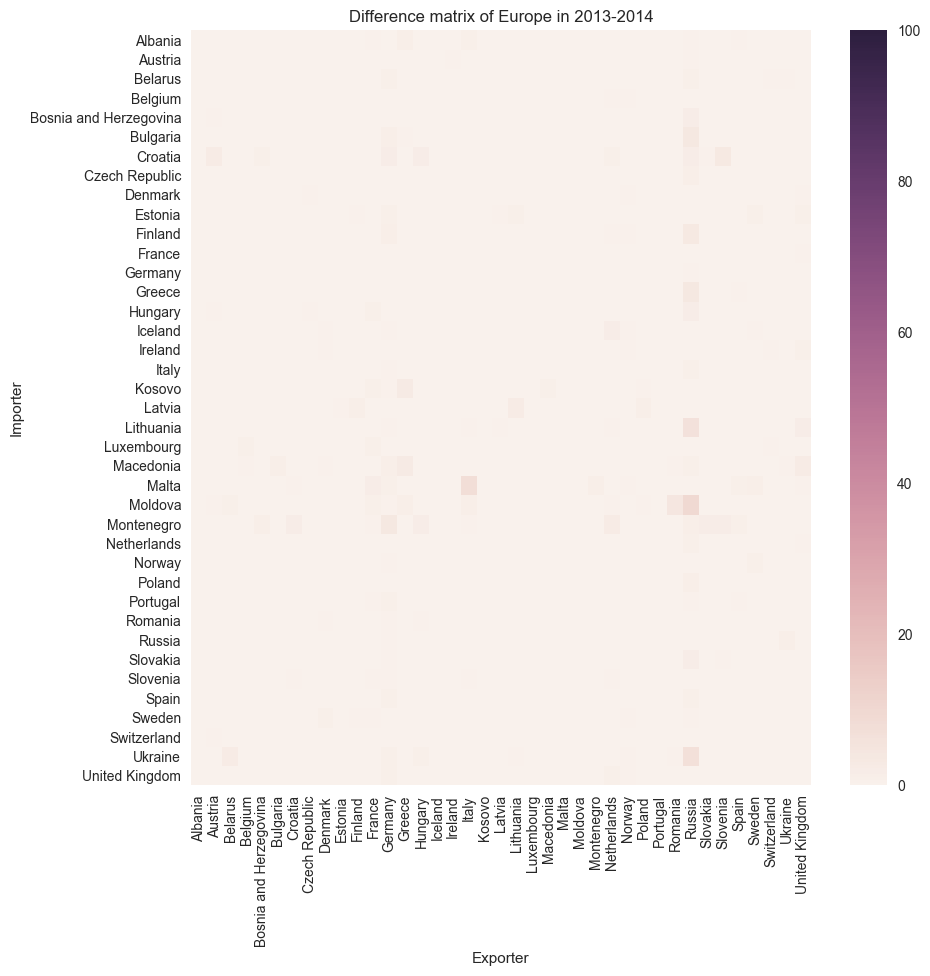

IndexError: list index out of range

In [33]:
continent = 'Europe'
for i, k in enumerate([l for l in range(1975,2015)]):
    loc = np.where(np.array(years)==k)[0][0]
    mat_1 = list_intensity_matrix[continent][loc]
    mat_2 = list_intensity_matrix[continent][loc+1]
    aligned_mat_1 = mat_1.align(mat_2, join='inner')[0].as_matrix()
    aligned_mat_2 = mat_1.align(mat_2, join='inner')[1].as_matrix()
    plt.figure(figsize=(10,10))
    df_inter = abs(aligned_mat_1-aligned_mat_2)
    print(np.linalg.norm(df_inter))
    sns.heatmap(df_inter, xticklabels = list_intensity_matrix_col[continent][loc],
               yticklabels = list_intensity_matrix_index[continent][loc], vmin=0, vmax=100)
    plt.title('Difference matrix of Europe in {}-{}'.format(k, k+1))
    plt.xlabel('Exporter')
    plt.ylabel('Importer')
    plt.show()

We can see that the change in the strucutre of the exchanges between 1984 and 1985 probably comes from the German Democratic Republic.

In [136]:
loc = np.where(np.array(years)==1984)[0][0]
demo_german_1984 = list_intensity_matrix['Europe'][loc].loc['German Democratic Republic', :]
demo_german_1985 = list_intensity_matrix['Europe'][loc+1].loc['German Democratic Republic', :]

In [109]:
geolocator = Nominatim()
# Get coordinated of countries
coordinates_countries = {}
for i in list(demo_german_1984.index):
    try:
        location = geolocator.geocode(i)
        coordinates_countries.update({i: (location.latitude, location.longitude)})
    except:
        coordinates_countries.update({i: ('lat not found', 'lon not found')})

In [110]:
coordinates_countries['United Kingdom'] = (53.067484, -2.650098)
coordinates_countries['Yugoslavia'] = (43.459501, 19.310925)
coordinates_countries['Czechoslovakia'] = (48.940088, 17.626917)
coordinates_countries['Russia'] = (54.655063, 35.882270)

In [137]:
# 1984
demo_german_1984 = pd.DataFrame(demo_german_1984).reset_index()
demo_german_1984['lat'] = [j[0] for j in list(map(coordinates_countries.get, demo_german_1984.Country_B))]
demo_german_1984['lon'] = [j[1] for j in list(map(coordinates_countries.get, demo_german_1984.Country_B))]
demo_german_1984.columns = ['Exporter', 'Flow', 'lat', 'lon']
demo_german_1984['text'] = demo_german_1984.apply(lambda x: str(np.round(x['Flow'], 2)) + '% of GRD imports comes from ' + x['Exporter'], axis = 1)

# 1985
demo_german_1985 = pd.DataFrame(demo_german_1985).reset_index()
demo_german_1985['lat'] = [j[0] for j in list(map(coordinates_countries.get, demo_german_1985.Country_B))]
demo_german_1985['lon'] = [j[1] for j in list(map(coordinates_countries.get, demo_german_1985.Country_B))]
demo_german_1985.columns = ['Exporter', 'Flow', 'lat', 'lon']
demo_german_1985['text'] = demo_german_1985.apply(lambda x: str(np.round(x['Flow'], 2)) + '% of GRD imports comes from ' + x['Exporter'], axis = 1)

In [142]:
# Map in 1984
data = [ dict(
        type = 'scattergeo',
        lon = demo_german_1984['lon'],
        lat = demo_german_1984['lat'],
        text = demo_german_1984['text'],
        mode = 'markers',
        marker = dict(
            size = demo_german_1984['Flow'],
            opacity = 1,
            reversescale = True,
            autocolorscale = False,
            symbol = 'circle',
            color='red'
        ))]

layout = dict(
        title = 'Exportater of German Democratic Republic in 1984',
        colorbar = True,
        geo = dict(
            scope = 'europe',
            projection=dict( type='mollweide' ),
            showland = True,
            landcolor = "rgb(250, 250, 250)",
            subunitcolor = "rgb(217, 217, 217)",
            countrycolor = "rgb(217, 217, 217)",
            countrywidth = 0.5,
            subunitwidth = 0.5
        ),
    )

fig = dict( data=data, layout=layout )
plotly.offline.iplot( fig, validate=False)

In [141]:
# Map in 1984
data = [ dict(
        type = 'scattergeo',
        lon = demo_german_1985['lon'],
        lat = demo_german_1985['lat'],
        text = demo_german_1985['text'],
        mode = 'markers',
        marker = dict(
            size = demo_german_1985['Flow'],
            opacity = 1,
            reversescale = True,
            autocolorscale = False,
            symbol = 'circle',
            color='red'
        ))]

layout = dict(
        title = 'Exportater of German Democratic Republic in 1985',
        colorbar = True,
        geo = dict(
            scope = 'europe',
            projection=dict( type='mollweide' ),
            showland = True,
            landcolor = "rgb(250, 250, 250)",
            subunitcolor = "rgb(217, 217, 217)",
            countrycolor = "rgb(217, 217, 217)",
            countrywidth = 0.5,
            subunitwidth = 0.5
        ),
    )

fig = dict( data=data, layout=layout )
plotly.offline.iplot( fig, validate=False)

In [148]:
for k in range(1980,2000):
    try:
        loc = np.where(np.array(years)==k)[0][0]
        df_inter = list_intensity_matrix['Europe'][loc].loc['German Democratic Republic', 'Russia']
        print('In {}, the imports of GDR from Russia were {}'.format(k, np.round(df_inter.sum(), 2)))
    except:
        continue

In 1980, the imports of GDR from Russia were 0.0
In 1981, the imports of GDR from Russia were 0.0
In 1982, the imports of GDR from Russia were 0.0
In 1983, the imports of GDR from Russia were 0.0
In 1984, the imports of GDR from Russia were 0.0
In 1985, the imports of GDR from Russia were 45.27
In 1986, the imports of GDR from Russia were 45.45
In 1987, the imports of GDR from Russia were 42.63
In 1988, the imports of GDR from Russia were 41.82
In 1989, the imports of GDR from Russia were 39.52


Again here, the spike in 1984-1985 doesn't come from a real change in the network's structure, but from the fact that GDR and Russia started to be transparent regarding their exchanges.

### Communities detection

In [262]:
data = pd.read_csv('Dyadic_COW_4.0.csv')
data = data.iloc[:,2:7]

# Data flow1
data_flow_1 = data.loc[:, ['year', 'importer1', 'importer2', 'flow1']]
data_flow_2 = data.loc[:, ['year', 'importer1', 'importer2', 'flow2']]
data_flow_1.columns = ['year', 'Country_A', 'Country_B', 'flow']
data_flow_1['key'] = data_flow_1['Country_A'] + '-' + data_flow_1['Country_B']
data_flow_2.columns = ['year', 'Country_B', 'Country_A', 'flow']
data_flow_2['key'] = data_flow_2['Country_B'] + '-' + data_flow_2['Country_A']
# Dataset in good shape
df = pd.concat([data_flow_1, data_flow_2]).sort_index().reset_index(drop=True)
# Replace -9 by NaN
df = df.replace({'flow': {-9: np.nan}})
# drop nan
df = df.dropna()
# We keep years from 1950
df = df[df.year>=1950].reset_index(drop=True)

# This gives us the proportion of importation of Country_A from Country_B at for each yer
df['flow'] = df['flow'] / df.groupby(['year', 'Country_A'])['flow'].transform(sum) * 100
# drop nan
df = df.dropna().reset_index(drop=True)

In [246]:
list_intensity_matrix = []
list_intensity_matrix_col = []
list_intensity_matrix_index = []
for i in list(df.year.unique()):
    inter_df = df[df.year==i]
    # Get squared similarity matrix
    data = pd.pivot_table(inter_df, values='flow', index=['Country_A'], columns=['Country_B'], fill_value=0)
    data = data.drop(list(set(data.columns) - set(data.index)), axis = 1)
    list_intensity_matrix.append(data.as_matrix())
    list_intensity_matrix_col.append(list(data.columns))
    list_intensity_matrix_index.append(list(data.index))

In [306]:
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import SpectralClustering

aff_clust = AffinityPropagation(damping = .5, affinity='precomputed')
spec_clust = SpectralClustering(6, affinity='precomputed')

for i in range(len(list_intensity_matrix)):
    print('Spec and Affi in {}'.format(years[i]))
    print(Counter(aff_clust.fit_predict(list_intensity_matrix[i])))
    print(Counter(spec_clust.fit_predict(list_intensity_matrix[i])))

Spec and Affi in 1950
Counter({3: 39, 2: 19, 1: 5, 0: 3})
Counter({0: 38, 4: 17, 3: 7, 5: 2, 1: 1, 2: 1})
Spec and Affi in 1951
Counter({2: 41, 1: 22, 0: 6})
Counter({2: 50, 3: 10, 0: 6, 1: 1, 4: 1, 5: 1})
Spec and Affi in 1952
Counter({3: 44, 2: 19, 0: 4, 1: 2})
Counter({1: 39, 0: 23, 5: 3, 4: 2, 2: 1, 3: 1})
Spec and Affi in 1953
Counter({4: 42, 3: 20, 2: 4, 0: 2, 1: 2})


/Users/Linger/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:678: UserWarning:

Array is not symmetric, and will be converted to symmetric by average with its transpose.

/Users/Linger/anaconda/lib/python3.5/site-packages/scipy/sparse/csgraph/_laplacian.py:72: FutureWarning:

Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.



Counter({0: 56, 3: 7, 5: 3, 4: 2, 1: 1, 2: 1})
Spec and Affi in 1954
Counter({2: 40, 1: 26, 0: 5})
Counter({0: 37, 1: 22, 5: 9, 2: 1, 3: 1, 4: 1})
Spec and Affi in 1955
Counter({5: 37, 4: 19, 3: 10, 2: 8, 1: 4, 0: 2})
Counter({0: 69, 5: 6, 4: 2, 1: 1, 2: 1, 3: 1})
Spec and Affi in 1956
Counter({4: 37, 3: 19, 1: 10, 2: 10, 0: 5})
Counter({0: 49, 3: 28, 1: 1, 2: 1, 4: 1, 5: 1})
Spec and Affi in 1957
Counter({4: 38, 3: 17, 2: 13, 1: 10, 0: 5})
Counter({0: 70, 4: 9, 1: 1, 2: 1, 3: 1, 5: 1})
Spec and Affi in 1958
Counter({5: 37, 1: 16, 4: 16, 0: 6, 2: 5, 3: 5})
Counter({0: 78, 4: 3, 1: 1, 2: 1, 3: 1, 5: 1})
Spec and Affi in 1959
Counter({5: 39, 1: 21, 4: 12, 0: 5, 2: 5, 3: 3})
Counter({0: 55, 4: 26, 1: 1, 2: 1, 3: 1, 5: 1})
Spec and Affi in 1960
Counter({5: 45, 1: 21, 4: 20, 3: 8, 2: 7, 0: 4})
Counter({3: 98, 0: 2, 4: 2, 1: 1, 2: 1, 5: 1})
Spec and Affi in 1961
Counter({6: 46, 1: 22, 5: 20, 3: 7, 4: 7, 0: 4, 2: 3})
Counter({0: 103, 3: 2, 1: 1, 2: 1, 4: 1, 5: 1})
Spec and Affi in 1962
Counte